In [ ]:
import sys, pathlib


sys.path.append(str(pathlib.Path('.').resolve()))

from pyhrt import utils
from pyhrt.hrt import hrt 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, RegressorMixin 
from sklearn.exceptions import NotFittedError 


try:
    from pygam import LinearGAM
except ImportError:
    LinearGAM = None

from typing import Type, Dict, Any, List, Union, Optional, Tuple 
import warnings
import joblib
import inspect

class GhostVariableEstimator:
    SUPPORTED_ESTIMATORS: Dict[str, Optional[Type[BaseEstimator]]] = {
        'lm': LinearRegression,
        'rf': RandomForestRegressor,
        'gam': LinearGAM
    }

    DEFAULT_PARAMS: Dict[str, Dict[str, Any]] = {
        'lm': {'n_jobs': None},
        'rf': {'n_estimators': 100, 'random_state': 42, 'n_jobs': 1, 'max_depth': 10, 'min_samples_leaf': 5},
        'gam': {'n_splines': 10, 'max_iter': 100, 'tol': 1e-3}
    }

    def __init__(self, estimator_type: str = 'rf', n_jobs: Optional[int] = 1, **estimator_params):
        estimator_key = estimator_type.lower()
        if estimator_key not in self.SUPPORTED_ESTIMATORS:
            raise ValueError(f"Invalid estimator_type '{estimator_type}'. Choose from {list(k for k,v in self.SUPPORTED_ESTIMATORS.items() if v is not None)}.")
        if self.SUPPORTED_ESTIMATORS[estimator_key] is None:
            print(f"Optional dependency for estimator type '{estimator_key}' not found. Please install it (e.g., pip install pygam).")
            raise ImportError(f"Estimator type '{estimator_key}' requires an optional dependency that is not installed.")

        self.estimator_key: str = estimator_key
        self.estimator_class: Type[BaseEstimator] = self.SUPPORTED_ESTIMATORS[estimator_key]

        merged_params = self.DEFAULT_PARAMS.get(estimator_key, {}).copy()
        merged_params.update(estimator_params)
        self.estimator_params: Dict[str, Any] = merged_params
        self.n_jobs = n_jobs
        self._fitted_estimators: Dict[str, BaseEstimator] = {} 

        print(f"Initialized GhostVariableEstimator with {self.estimator_key.upper()} (params: {self.estimator_params}, requested n_jobs={self.n_jobs})")
        if self.n_jobs != 1:
            print("Note: Using n_jobs != 1 may cause serialization errors depending on the environment/estimators.")


    def _get_estimator_instance(self) -> BaseEstimator: 
        """Instantiates a new underlying estimator model with configured parameters."""
        sig = inspect.signature(self.estimator_class.__init__)
        valid_keys = {p.name for p in sig.parameters.values() if p.kind == p.POSITIONAL_OR_KEYWORD or p.kind == p.KEYWORD_ONLY}
        if 'self' not in valid_keys and any(p.name == 'self' for p in sig.parameters.values()):
            valid_keys.add('self') 
        init_params = {k: v for k, v in self.estimator_params.items() if k in valid_keys}
        try:
            return self.estimator_class(**init_params)
        except TypeError as e:
            warnings.warn(f"Error initializing {self.estimator_key.upper()} with filtered params {init_params}: {e}. Trying default.", UserWarning)
            try:
                return self.estimator_class()
            except Exception as e_def:
                raise RuntimeError(f"Failed to initialize {self.estimator_key.upper()} with both provided and default params.") from e_def

    def _estimate_single_ghost_job(self, X_df: pd.DataFrame, target_var_name: str) -> Optional[pd.Series]: 
        current_job_id = f"{target_var_name} (using {self.estimator_key})"
        try:
            if target_var_name not in X_df.columns:
                warnings.warn(f"[{current_job_id}] Target variable not found in DataFrame.", UserWarning)
                return None
            if X_df.shape[1] <= 1:
                warnings.warn(f"[{current_job_id}] Cannot estimate ghost with <= 1 feature. Returning original.", UserWarning)
                return X_df[target_var_name].astype(float)

            target_series = X_df[target_var_name]
            feature_df = X_df.drop(columns=[target_var_name])

            if not pd.api.types.is_numeric_dtype(target_series):
                warnings.warn(f"[{current_job_id}] Target is not numeric. Cannot estimate ghost. Returning original.", UserWarning)
                return target_series.astype(float)

            if self.estimator_key in ['lm', 'rf', 'gam']:
                numeric_features = feature_df.select_dtypes(include=np.number)
                if numeric_features.empty:
                    warnings.warn(f"[{current_job_id}] No numeric features found for {self.estimator_key}. Returning original.", UserWarning)
                    return target_series.astype(float)
                if numeric_features.shape[1] < feature_df.shape[1]:
                    warnings.warn(f"[{current_job_id}] Non-numeric features dropped for {self.estimator_key}.", UserWarning)
                feature_df_processed = numeric_features
            else:
                feature_df_processed = feature_df

            if feature_df_processed.isnull().any().any():
                warnings.warn(f"[{current_job_id}] Features contain NaNs after selection. Applying median imputation.", UserWarning)
                for col in feature_df_processed.columns[feature_df_processed.isnull().any()]: # Iterate only over columns with NaNs
                    median_val = feature_df_processed[col].median()
                    feature_df_processed.loc[:, col] = feature_df_processed[col].fillna(median_val)

            estimator = self._get_estimator_instance()
            estimator.fit(feature_df_processed.values, target_series.values)
            Z_ghost = estimator.predict(feature_df_processed.values)
            self._fitted_estimators[target_var_name] = estimator 
            return pd.Series(Z_ghost.astype(float), index=X_df.index, name=target_var_name)
        except Exception as e:
            warnings.warn(f"[{current_job_id}] Error during estimation: {e}. Returning None.", UserWarning)
            import traceback 
            print(f"Traceback for {current_job_id}:\n{traceback.format_exc()}")
            return None

    def estimate_all_ghosts(self, X_data: pd.DataFrame) -> pd.DataFrame: 
        if not isinstance(X_data, pd.DataFrame) or X_data.empty:
            raise ValueError("Input must be a non-empty pandas DataFrame.")
        if X_data.isnull().any().any():
            warnings.warn("Input data contains NaNs. Consider imputation before calling estimate_all_ghosts.", UserWarning)

        print(f"\nEstimating all ghost variables using {self.estimator_key.upper()}...")
        target_vars = list(X_data.columns)
        verbosity = 5 if self.n_jobs != 1 else 0
        try:
            
            with joblib.Parallel(n_jobs=self.n_jobs, backend='loky', verbose=verbosity) as parallel:
                results = parallel(
                    joblib.delayed(self._estimate_single_ghost_job)(X_data.copy(), var_name)
                    for var_name in target_vars
                )
        except Exception as e:
            warnings.warn(f"Joblib parallel execution failed: {e}. Attempting serial execution.", RuntimeWarning)
            results = [self._estimate_single_ghost_job(X_data.copy(), var_name) for var_name in target_vars]

        valid_results_map = {res.name: res for res in results if res is not None and hasattr(res, 'name')}

        if not valid_results_map:
            raise RuntimeError("All ghost variable estimations failed. Check warnings.")

        successful_cols = [col for col in target_vars if col in valid_results_map]
        if not successful_cols: 
             raise RuntimeError("No columns successfully processed for ghost estimation.")
        ghost_df = pd.concat([valid_results_map[col] for col in successful_cols], axis=1)

        failed_cols = set(target_vars) - set(successful_cols)
        if failed_cols:
            warnings.warn(f"Ghost variable estimation failed for: {sorted(list(failed_cols))}. Check previous warnings.", UserWarning)

        print(f"Ghost variable estimation complete. Successfully estimated for {len(successful_cols)} out of {len(target_vars)} variables.")
        return ghost_df

    
    def predict_single_variable_ghost_on_new_data(self, X_new_df: pd.DataFrame, target_var_name: str) -> Optional[pd.Series]: 
        if target_var_name not in self._fitted_estimators:
            warnings.warn(f"No pre-fitted estimator found for target variable '{target_var_name}'. Returning None.", UserWarning)
            return None
        if target_var_name not in X_new_df.columns:
            warnings.warn(f"Target variable '{target_var_name}' not found in X_new_df. Returning None.", UserWarning)
            return None

        estimator = self._fitted_estimators[target_var_name]
        if X_new_df.shape[1] <= 1:
            return X_new_df[target_var_name].astype(float)

        feature_df = X_new_df.drop(columns=[target_var_name])
        
        if self.estimator_key in ['lm', 'rf', 'gam']:
            numeric_features = feature_df.select_dtypes(include=np.number)
            if numeric_features.empty:
                warnings.warn(f"No numeric features in X_new_df for '{target_var_name}' using {self.estimator_key}. Returning original.", UserWarning)
                return X_new_df[target_var_name].astype(float)
            if numeric_features.shape[1] < feature_df.shape[1]:
                warnings.warn(f"Non-numeric features dropped from X_new_df for predicting '{target_var_name}'.", UserWarning)
            feature_df_processed = numeric_features
        else:
            feature_df_processed = feature_df

        if feature_df_processed.isnull().any().any():
            warnings.warn(f"Features in X_new_df for '{target_var_name}' contain NaNs. Applying median imputation.", UserWarning)
            
            for col in feature_df_processed.columns[feature_df_processed.isnull().any()]:
                median_val = feature_df_processed[col].median()
                feature_df_processed.loc[:, col] = feature_df_processed[col].fillna(median_val)
        
        try:
            Z_ghost_new = estimator.predict(feature_df_processed.values)
            return pd.Series(Z_ghost_new.astype(float), index=X_new_df.index, name=target_var_name)
        except Exception as e:
            warnings.warn(f"Error predicting ghost for '{target_var_name}' on new data: {e}. Returning None.", UserWarning)
            return None

    @property 
    def is_fitted(self) -> bool:
        return bool(self._fitted_estimators)

In [ ]:
import pandas as pd
import numpy as np
from typing import Type, Dict, Any, List, Union, Optional, Tuple, Callable
import warnings

try:
    from sksurv.util import Surv # Required for scikit-survival format
    sksurv_available = True
except ImportError:
    Surv = None 
    sksurv_available = False
    warnings.warn("Package 'scikit-survival' not found. Data generation will not produce sksurv structured arrays.", ImportWarning)



import pandas as pd
import numpy as np
from typing import List, Dict, Any, Optional, Callable, Union, Tuple
import warnings


try:
    from sksurv.util import Surv
    sksurv_available = True
except ImportError:
    class Surv: pass # Dummy
    sksurv_available = False

def generate_uncorrelated_features(n_samples: int, n_features: int, rng: np.random.Generator) -> pd.DataFrame:
    """Generates independent standard normal features."""
    data = rng.normal(0, 1, size=(n_samples, n_features))
    feature_names = [f'X{i+1}' for i in range(n_features)]
    return pd.DataFrame(data, columns=feature_names)

def generate_correlated_features(n_samples: int, n_features: int, rng: np.random.Generator, corr_matrix: np.ndarray) -> pd.DataFrame:
    """Generates multivariate normal features with a specified correlation matrix."""
    if corr_matrix.shape != (n_features, n_features):
        raise ValueError("Correlation matrix dimensions must match n_features.")
    # Use Cholesky decomposition to generate correlated data
    try:
        L = np.linalg.cholesky(corr_matrix)
    except np.linalg.LinAlgError:
         raise ValueError("Correlation matrix is not positive definite!")
    uncorrelated_data = rng.normal(0, 1, size=(n_samples, n_features))
    correlated_data = uncorrelated_data @ L.T # Apply transformation
    feature_names = [f'X{i+1}' for i in range(n_features)]
    return pd.DataFrame(correlated_data, columns=feature_names)

# Define the non-linear function globally too
def nonlinear_predictor_func(df: pd.DataFrame) -> np.ndarray:
    """Example non-linear function f(x)."""
    required_cols = ['X1', 'X2', 'X3']
    if not all(col in df.columns for col in required_cols):
        raise ValueError(f"DataFrame missing required columns for nonlinear_predictor_func: {required_cols}")
    score = 1.0 * df['X1'] + np.sin(np.pi * df['X2']) + 0.5 * (df['X3']**2)
    return score.values


import pandas as pd
import numpy as np
from typing import List, Dict, Any, Optional, Callable, Union, Tuple
import warnings


try:
    from sksurv.util import Surv
    sksurv_available = True
except ImportError:
    class Surv: pass # Dummy
    sksurv_available = False


class SurvivalDataGenerator:
    def __init__(self,
                 n_samples: int = 500,
                 n_features: int = 3,
                 # --- NEW ARGUMENTS ---
                 feature_generation_type: str = 'uncorrelated', # 'uncorrelated' or 'correlated'
                 corr_matrix: Optional[np.ndarray] = None, # Required if type is 'correlated'
                 # --- END NEW ARGUMENTS ---
                 beta_coeffs: Optional[List[float]] = None,
                 nonlinear_func: Optional[Callable[[pd.DataFrame], np.ndarray]] = None,
                 baseline_hazard_lambda: float = 0.01,
                 censoring_dist_lambda: float = 0.002,
                 contamination_prop: float = 0.0,
                 random_state: Optional[int] = None):

        # --- VALIDATION FOR NEW ARGUMENTS ---
        self.feature_generation_type = feature_generation_type.lower()
        if self.feature_generation_type not in ['uncorrelated', 'correlated']:
            raise ValueError("feature_generation_type must be 'uncorrelated' or 'correlated'")
        if self.feature_generation_type == 'correlated' and corr_matrix is None:
            raise ValueError("corr_matrix must be provided when feature_generation_type is 'correlated'")
        if self.feature_generation_type == 'correlated' and corr_matrix.shape != (n_features, n_features):
             raise ValueError(f"corr_matrix shape {corr_matrix.shape} does not match n_features {n_features}")
        self.corr_matrix = corr_matrix
        # --- END VALIDATION ---

        if beta_coeffs is not None and len(beta_coeffs) != n_features:
             raise ValueError("Length of beta_coeffs must match n_features.")
        
        elif beta_coeffs is None and nonlinear_func is None:
             warnings.warn("Neither beta_coeffs nor nonlinear_func provided. Using f(X) = sum(X_i).", UserWarning)
             self.nonlinear_func = lambda x_df: x_df.sum(axis=1).values # Default simple sum
             self.beta_coeffs = None
        elif beta_coeffs is not None and nonlinear_func is not None:
             warnings.warn("Both beta_coeffs and nonlinear_func provided. Using nonlinear_func.", UserWarning)
             self.beta_coeffs = None
             self.nonlinear_func = nonlinear_func
        elif beta_coeffs is not None:
             self.beta_coeffs = np.array(beta_coeffs)
             self.nonlinear_func = None
        else: # nonlinear_func is provided, beta_coeffs is None
             self.beta_coeffs = None
             self.nonlinear_func = nonlinear_func


        self.n_samples = n_samples
        self.n_features = n_features
        self.feature_names = [f'X{i+1}' for i in range(n_features)]
        
        self.beta_coeffs = np.array(beta_coeffs) if beta_coeffs is not None else None
        self.nonlinear_func = nonlinear_func
        self.baseline_hazard_lambda = baseline_hazard_lambda
        self.censoring_dist_lambda = censoring_dist_lambda
        self.contamination_prop = contamination_prop
        self.rng = np.random.default_rng(random_state)

        print(f"Initialized SurvivalDataGenerator (n={n_samples}, p={n_features}, type='{self.feature_generation_type}', alpha={contamination_prop})")


    def _generate_features(self) -> pd.DataFrame:
        """ Generates features based on the specified type. """
        try:
            if self.feature_generation_type == 'uncorrelated':
                # Ensure generate_uncorrelated_features is defined globally
                features_df = generate_uncorrelated_features(self.n_samples, self.n_features, self.rng)
            elif self.feature_generation_type == 'correlated':
                # Ensure generate_correlated_features is defined globally
                if self.corr_matrix is None: 
                    raise ValueError("Correlation matrix is missing for 'correlated' type.")
                features_df = generate_correlated_features(self.n_samples, self.n_features, self.rng, self.corr_matrix)
            else:
                
                raise ValueError(f"Unknown feature_generation_type: {self.feature_generation_type}")

        except NameError as e:
             raise NameError(f"Helper function for '{self.feature_generation_type}' features not defined globally: {e}")
        except Exception as e:
             raise RuntimeError(f"Error during feature generation for type '{self.feature_generation_type}'.") from e

        
        if features_df.shape != (self.n_samples, self.n_features):
             raise ValueError(f"Feature generation produced shape {features_df.shape}, expected ({self.n_samples}, {self.n_features}).")
        features_df.columns = self.feature_names
        return features_df[self.feature_names] # Return in defined order

    # --- Methods _calculate_predictor_score  ---
    
    def _calculate_predictor_score(self, X: pd.DataFrame) -> np.ndarray:
        """ Calculates the linear or non-linear predictor score f(X) or beta'X. """
        if self.nonlinear_func:
            try:
                 score = self.nonlinear_func(X)
                 if not isinstance(score, np.ndarray) or score.ndim != 1 or score.shape[0] != X.shape[0]:
                      raise ValueError(f"nonlinear_func must return a 1D numpy array of length {X.shape[0]}")
                 return score
            except Exception as e:
                 raise ValueError("Error executing nonlinear_func.") from e
        elif self.beta_coeffs is not None:
             if not all(col in X.columns for col in self.feature_names):
                  raise ValueError("Input DataFrame X is missing expected feature columns for beta calculation.")
             return X[self.feature_names].values @ self.beta_coeffs
        else:
             warnings.warn("Neither beta_coeffs nor nonlinear_func provided. Using f(X) = sum(X_i).", UserWarning)
             return X[self.feature_names].sum(axis=1).values

    def generate(self, return_sksurv_array: bool = True) -> Union[Tuple[pd.DataFrame, np.ndarray], Tuple[pd.DataFrame, pd.Series, pd.Series]]:
        """ Generates the survival dataset. """
        if return_sksurv_array and not sksurv_available:
             warnings.warn("scikit-survival not found. Returning time and event as separate Series.", ImportWarning)
             return_sksurv_array = False

        
        X = self._generate_features()
        predictor_score = self._calculate_predictor_score(X)

        # Generate latent event times
        rate = self.baseline_hazard_lambda * np.exp(predictor_score)
        rate = np.maximum(rate, 1e-12)
        scale = 1.0 / rate
        T_latent = self.rng.exponential(scale=scale, size=self.n_samples)

        # Contamination
        
        outlier_indices = np.array([], dtype=int)
        if self.contamination_prop > 0:
            n_outliers = int(np.round(self.contamination_prop * self.n_samples))
            if n_outliers > 0 and n_outliers < self.n_samples:
                outlier_indices = self.rng.choice(self.n_samples, n_outliers, replace=False)
                p01 = np.percentile(T_latent, 1)
                p99 = np.percentile(T_latent, 99)
                max_T = np.max(T_latent)
                outlier_times_early = self.rng.uniform(0, max(p01 * 0.9, 1e-6), n_outliers)
                late_lower_bound = p99
                late_upper_bound = max(p99 * 1.01, max_T * 1.1)
                if late_upper_bound <= late_lower_bound:
                    late_upper_bound = late_lower_bound + 1e-6 * (late_lower_bound + 1.0)
                outlier_times_late = self.rng.uniform(late_lower_bound, late_upper_bound, n_outliers)
                u_i = self.rng.binomial(1, 0.5, n_outliers)
                T_latent[outlier_indices] = np.where(u_i == 1, outlier_times_early, outlier_times_late)


        # Generate censoring times
        if self.censoring_dist_lambda <= 0:
             T_cens = np.full(self.n_samples, np.inf)
             # print("censoring_dist_lambda <= 0 implies effectively no censoring.")
        else:
             T_cens = self.rng.exponential(scale=1.0 / self.censoring_dist_lambda, size=self.n_samples)

        # Observed time and event status
        E_bool = (T_latent <= T_cens)
        T_obs = np.minimum(T_latent, T_cens)

        # Handle potential NaNs or Infs
        valid_idx = np.isfinite(T_obs) & np.isfinite(predictor_score) & ~np.isnan(T_obs) & ~np.isnan(predictor_score)
        if not np.all(valid_idx):
             n_removed = self.n_samples - np.sum(valid_idx)
             warnings.warn(f"Removed {n_removed} samples due to non-finite time or predictor score values.", UserWarning)
             X = X.loc[valid_idx].reset_index(drop=True)
             T_obs = T_obs[valid_idx]
             E_bool = E_bool[valid_idx]
             if X.empty:
                  raise ValueError("All samples removed due to invalid values during generation.")

        actual_censoring_prop = 1.0 - E_bool.mean()
        # print(f"Data generation complete. Final n={X.shape[0]}. Actual censoring: {actual_censoring_prop:.2f}") 

        if return_sksurv_array:
            y_structured = Surv.from_arrays(event=E_bool, time=T_obs)
            return X, y_structured
        else:
            return X, pd.Series(T_obs, name='time'), pd.Series(E_bool, name='event')



In [ ]:
import pandas as pd
import numpy as np
from sklearn.exceptions import NotFittedError
from typing import Type, Dict, Any, Optional
import warnings

# --- Attempt to import scikit-survival ---
try:
    from sksurv.ensemble import RandomSurvivalForest
    from sksurv.util import Surv 
    
    sksurv_available = True
except ImportError:
   
    class RandomSurvivalForest: pass
    class Surv: pass
    sksurv_available = False
    warnings.warn("Package 'scikit-survival' not found. NonLinearSurvivalModel class will not function properly.", ImportWarning)
# --- End Import Handling ---

class NonLinearSurvivalModel:
    """
    A wrapper class for non-linear survival models from scikit-survival.
    Currently implements Random Survival Forest (RSF).

    Args:
        model_type (str): The type of survival model. Currently only 'rsf' supported.
        model_params: Keyword arguments passed to the underlying scikit-survival
                      model constructor. Defaults are provided for RSF.
    """
    SUPPORTED_MODELS: Dict[str, Optional[Type[Any]]] = {
        'rsf': RandomSurvivalForest if sksurv_available else None,
    }

    DEFAULT_PARAMS: Dict[str, Dict[str, Any]] = {
        'rsf': {'n_estimators': 100, 'random_state': 42, 'n_jobs': -1,
                'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': None}
    }

    def __init__(self, model_type: str = 'rsf', **model_params):
        if not sksurv_available:
            raise ImportError("scikit-survival is required for NonLinearSurvivalModel but is not installed.")

        model_key = model_type.lower()
        model_class_ref = self.SUPPORTED_MODELS.get(model_key)

        if model_class_ref is None:
            raise ValueError(f"Unsupported model_type '{model_type}'. Choose from {list(self.SUPPORTED_MODELS.keys())}.")

        self.model_type: str = model_key
        self.model_class: Type[Any] = model_class_ref

        # Combine default params with user-provided params
        merged_params = self.DEFAULT_PARAMS.get(model_key, {}).copy()
        merged_params.update(model_params)
        self.model_params: Dict[str, Any] = merged_params

        # Instantiate the underlying model
        try:
            self.model = self.model_class(**self.model_params)
        except Exception as e:
            raise RuntimeError(f"Failed to initialize {self.model_type.upper()} with params {self.model_params}") from e

        self._is_fitted: bool = False
        self.feature_names_in_: Optional[list] = None # Store feature names during fit

        print(f"Initialized NonLinearSurvivalModel with {self.model_type.upper()} (params: {self.model_params})")

    def fit(self, X: pd.DataFrame, y_structured: np.ndarray):
        """
        Fits the survival model to the training data.

        Args:
            X (pd.DataFrame): DataFrame of features for training.
            y_structured (np.ndarray): Structured array containing 'event' (bool)
                                       and 'time' (float) fields, typically created
                                       using sksurv.util.Surv.from_dataframe() or .from_arrays().
        """
        if not isinstance(X, pd.DataFrame):
             raise ValueError("X must be a pandas DataFrame.")
        if not sksurv_available or Surv is None: # Double check just in case
             raise ImportError("scikit-survival required for fitting.")
        # Basic check for structured array type
        if not isinstance(y_structured, np.ndarray) or not all(name in y_structured.dtype.names for name in ['event', 'time']):
             raise ValueError("y_structured must be a numpy structured array with 'event' and 'time' fields (from sksurv.util.Surv).")

        print(f"Fitting {self.model_type.upper()}...")
        try:
            # Store feature names to ensure consistency during prediction
            self.feature_names_in_ = list(X.columns)
            # Ensure X contains only numeric data before passing to sksurv model
            X_numeric = X.select_dtypes(include=np.number)
            if X_numeric.shape[1] < X.shape[1]:
                 dropped_cols = list(set(X.columns) - set(X_numeric.columns))
                 warnings.warn(f"Non-numeric columns dropped from X before fitting: {dropped_cols}", UserWarning)
            if X_numeric.isnull().any().any():
                 warnings.warn("X contains NaNs after numeric selection. Consider imputation. Fitting may fail.", UserWarning)
                 # Basic imputation (median)
                 for col in X_numeric.columns[X_numeric.isnull().any()]:
                      median_val = X_numeric[col].median()
                      X_numeric[col] = X_numeric[col].fillna(median_val)

            if X_numeric.empty:
                raise ValueError("No numeric features remaining in X after preprocessing.")

            self.model.fit(X_numeric, y_structured)
            self._is_fitted = True
            print("Fitting complete.")
        except Exception as e:
            self._is_fitted = False # Ensure state reflects failure
            raise RuntimeError(f"Failed to fit {self.model_type.upper()} model.") from e

        return self

    def predict_risk_score(self, X: pd.DataFrame) -> np.ndarray:
        """
        Predicts the risk score f(x) for new data.
        For RSF, higher scores indicate higher risk (closer to log-hazard).

        Args:
            X (pd.DataFrame): DataFrame of features for prediction.

        Returns:
            np.ndarray: Array of predicted risk scores.
        """
        if not self._is_fitted:
            raise NotFittedError("This NonLinearSurvivalModel instance is not fitted yet. Call 'fit' first.")
        if not isinstance(X, pd.DataFrame):
             raise ValueError("X must be a pandas DataFrame.")
        if not sksurv_available: 
             raise ImportError("scikit-survival required for prediction.")

        # Ensure input features match training features order and presence
        if self.feature_names_in_ is None:
             raise NotFittedError("Model has been fitted but feature names were not stored.")
        if list(X.columns) != self.feature_names_in_:
             warnings.warn("Input features mismatch fitted features order/presence. Reordering/selecting columns.", UserWarning)
             try:
                 
                 X = X[self.feature_names_in_]
             except KeyError as e:
                 missing_cols = list(set(self.feature_names_in_) - set(X.columns))
                 raise ValueError(f"Input data missing columns used during fitting: {missing_cols}") from e

        # Ensure X contains only numeric data before passing to sksurv model
        X_numeric = X.select_dtypes(include=np.number)
        if X_numeric.shape[1] < X.shape[1]:
                 dropped_cols = list(set(X.columns) - set(X_numeric.columns))
                 warnings.warn(f"Non-numeric columns dropped from X before prediction: {dropped_cols}", UserWarning)
        if X_numeric.isnull().any().any():
             warnings.warn("X contains NaNs after numeric selection. Consider imputation. Prediction may fail.", UserWarning)
             # Basic imputation (median)
             for col in X_numeric.columns[X_numeric.isnull().any()]:
                 median_val = X_numeric[col].median()
                 X_numeric[col] = X_numeric[col].fillna(median_val)

        if X_numeric.shape[1] != len(self.feature_names_in_):
            # Check if only non-numeric columns existed, leading to empty df
            if X_numeric.empty and not any(X[f].dtype == np.number for f in self.feature_names_in_):
                 raise ValueError("Model was fitted on features, but input X has no numeric features corresponding to them.")
            # Or if numeric selection failed for other reasons
            raise ValueError(f"Mismatch in number of numeric features after preprocessing. Expected {len(self.feature_names_in_)}, got {X_numeric.shape[1]}.")


        try:
            # predict() for RSF returns risk scores directly
            risk_scores = self.model.predict(X_numeric)
            return risk_scores
        except Exception as e:
            raise RuntimeError(f"Failed to predict with {self.model_type.upper()} model.") from e

    @property
    def is_fitted(self) -> bool:
        return self._is_fitted

In [ ]:
import pandas as pd
import numpy as np
from sklearn.exceptions import NotFittedError
from typing import Type, Dict, Any, Optional, Tuple
import warnings



class GhostCoxInterpreter:
    """
    Interprets a fitted non-linear survival model using the Ghost Variables methodology.

    Calculates variable relevance (RV_gh) based on the change in the model's
    predicted risk score when a variable is replaced by its ghost.
    Optionally calculates the Relevance Matrix V.

    Args:
        survival_model (NonLinearSurvivalModel): A fitted instance of the survival model wrapper.
        ghost_estimator (GhostVariableEstimator): An initialized instance for estimating ghost variables.
    """
    def __init__(self,
                 survival_model: 'NonLinearSurvivalModel',
                 ghost_estimator: 'GhostVariableEstimator'):

        if not hasattr(survival_model, 'predict_risk_score') or not callable(survival_model.predict_risk_score):
             raise TypeError("survival_model must have a callable 'predict_risk_score' method.")
        if not hasattr(survival_model, 'is_fitted') or not survival_model.is_fitted:
             raise NotFittedError("The provided survival_model must be fitted first.")
        if not isinstance(ghost_estimator, GhostVariableEstimator):
             raise TypeError("ghost_estimator must be an instance of GhostVariableEstimator.")

        self.survival_model = survival_model
        self.ghost_estimator = ghost_estimator
        print("Initialized GhostCoxInterpreter.")


    def calculate_relevance(self, X_test: pd.DataFrame, calculate_relevance_matrix: bool = True) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
     """
     Calculates ghost variable relevance RV_gh for each variable in X_test.

     Args:
          X_test (pd.DataFrame): The test dataset (features only).
          calculate_relevance_matrix (bool): If True, also calculates and returns the
                                             Relevance Matrix V. Defaults to True.

     Returns:
          Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
               - relevance_df: DataFrame containing relevance scores (RV_gh_numerator, RV_gh)
                              and ranks for each variable.
               - V_df: DataFrame representing the normalized Relevance Matrix V (or None if
                         calculate_relevance_matrix is False).
     """
     if not isinstance(X_test, pd.DataFrame) or X_test.empty:
          raise ValueError("X_test must be a non-empty pandas DataFrame.")
     if not self.survival_model.is_fitted:
          raise NotFittedError("The survival model within the interpreter is not fitted.")

     print("\nCalculating Ghost Variable Relevance...")
     n_samples, n_features_orig = X_test.shape
     feature_names_orig = list(X_test.columns)

     # 1. Estimate all ghost variables for the test set
     X_ghost_test = self.ghost_estimator.estimate_all_ghosts(X_test)

     # Determine successfully ghosted features
     valid_feature_names = list(X_ghost_test.columns)
     if not valid_feature_names:
          raise RuntimeError("Ghost estimation failed for all variables.")
     if len(valid_feature_names) < n_features_orig:
          missing_ghosts = set(feature_names_orig) - set(valid_feature_names)
          warnings.warn(f"Could not estimate ghosts for: {missing_ghosts}. Excluding these from relevance calculation.", UserWarning)

     # Use only the features for which ghosts were successfully estimated
     X_test_filtered = X_test[valid_feature_names]
     n_samples, n_features = X_test_filtered.shape # Update dimensions

     # 2. Get predictions from the survival model on original (filtered) test data
     try:
          f_X_test = self.survival_model.predict_risk_score(X_test_filtered)
          if f_X_test.ndim != 1 or len(f_X_test) != n_samples:
               raise ValueError(f"predict_risk_score returned unexpected shape {f_X_test.shape}")
     except Exception as e:
          raise RuntimeError("Failed to get predictions from the survival model on filtered X_test.") from e

     # --- NORMALIZATION FACTOR CALCULATION ---
     # Calculate the variance of the original predictions on the test set
     var_f_test = np.var(f_X_test)
     # Handle potential zero variance (if predictions are constant)
     if var_f_test < np.finfo(float).eps: # Use machine epsilon for safe comparison
          warnings.warn("Variance of predicted risk scores on test set is near zero. RV_gh cannot be calculated (will be NaN).", UserWarning)
          var_f_test = np.nan # Set to NaN to propagate the issue clearly
     else:
          print(f"Normalization factor Var(f_test): {var_f_test:.4f}")
     # -----------------------------------------

     relevance_results = {}
     A_matrix = np.zeros((n_samples, n_features)) # Size based on valid features

     # 3. Loop through each VALID variable to calculate relevance
     for j, var_name in enumerate(valid_feature_names):
          # print(f"... calculating relevance for {var_name} ({j+1}/{n_features})") 
          X_test_j_ghost = X_test_filtered.copy()
          try:
               
               X_test_j_ghost.loc[:, var_name] = X_ghost_test[var_name].astype(X_test_filtered[var_name].dtype, errors='ignore')
          except Exception:
               X_test_j_ghost.loc[:, var_name] = X_ghost_test[var_name]

          # Get predictions with the ghost variable substituted
          try:
               f_X_test_j_ghost = self.survival_model.predict_risk_score(X_test_j_ghost)
               if f_X_test_j_ghost.shape != f_X_test.shape:
                    raise ValueError(f"Prediction shape mismatch for ghost '{var_name}': {f_X_test_j_ghost.shape} vs {f_X_test.shape}")
          except Exception as e:
               warnings.warn(f"Could not get prediction for ghost '{var_name}': {e}. Setting relevance to NaN.", UserWarning)
               relevance_results[var_name] = {'RV_gh_numerator': np.nan, 'RV_gh': np.nan} # Store NaN for both
               A_matrix[:, j] = np.nan 
               continue

          # Calculate change and store
          prediction_change = f_X_test - f_X_test_j_ghost
          A_matrix[:, j] = prediction_change
          mean_sq_change = np.mean(prediction_change**2)

          # --- APPLY NORMALIZATION ---
          normalized_relevance = mean_sq_change / var_f_test if not np.isnan(var_f_test) else np.nan
          # --------------------------

          relevance_results[var_name] = {
               'RV_gh_numerator': mean_sq_change,
               'RV_gh': normalized_relevance # Store the normalized value
          }

     # Create DataFrame from results
     relevance_df = pd.DataFrame.from_dict(relevance_results, orient='index')

     # Filter out any NaNs that might have occurred
     nan_features = relevance_df[relevance_df['RV_gh'].isna()].index.tolist()
     if nan_features:
          warnings.warn(f"Relevance calculation resulted in NaN for: {nan_features}. Excluding them from Rank and V Matrix.", UserWarning)
          relevance_df_valid = relevance_df.dropna(subset=['RV_gh'])
          # Filter corresponding columns from A_matrix if calculating V
          valid_indices_for_V = [j for j, name in enumerate(valid_feature_names) if name in relevance_df_valid.index]
          A_matrix_valid = A_matrix[:, valid_indices_for_V]
          valid_feature_names_for_V = relevance_df_valid.index.tolist() # Update list for V
     else:
          relevance_df_valid = relevance_df # Use the full df if no NaNs
          A_matrix_valid = A_matrix
          valid_feature_names_for_V = valid_feature_names

     if relevance_df_valid.empty:
          # Add Rank column even if empty to avoid errors later, though it will be empty
          relevance_df['Rank'] = np.nan
          warnings.warn("Relevance calculation failed or resulted in NaN for all variables. Cannot rank or calculate V matrix.", RuntimeWarning)
     else:
          # Calculate Rank based on the normalized RV_gh for valid features
          relevance_df['Rank'] = relevance_df_valid['RV_gh'].rank(ascending=False).astype(int)
          # Add NaN ranks for features that had NaN relevance
          relevance_df['Rank'] = relevance_df['Rank'].reindex(relevance_df.index)


     # # 4. Calculate Relevance Matrix V (optional)
     # # --- Calculate V as the sample covariance matrix of ghost effects (A_matrix_valid) ---
     #        # A_matrix_valid has shape (n_samples, n_valid_features_for_V)
     #        # We want the covariance between the columns (variables).
     # if A_matrix_valid.shape[0] > 1: # np.cov requires at least 2 observations for sample covariance (ddof=1 default)
     #     # rowvar=False means each column is a variable, each row is an observation
     #     V_matrix = np.cov(A_matrix_valid, rowvar=False) 
     # elif A_matrix_valid.shape[0] == 1 and A_matrix_valid.shape[1] > 0: # Single observation case
     #      # For a single observation, covariance is typically undefined or zero. 
     #      # np.cov with ddof=0 would give 0. With ddof=1 (default) it gives NaN or error.
     #      # Let's return a matrix of zeros for consistency, or NaNs.
     #      # D&P's R code cov(A) would likely produce NaNs or errors if A has 1 row.
     #      num_valid_features_for_V = A_matrix_valid.shape[1]
     #      V_matrix = np.full((num_valid_features_for_V, num_valid_features_for_V), 0.0) # Or np.nan
     #      warnings.warn("Covariance matrix V is ill-defined with only one observation in A_matrix_valid; set to zeros/NaNs.", UserWarning)
     # else: # No data or no features
     #      num_valid_features_for_V = A_matrix_valid.shape[1] if A_matrix_valid.ndim == 2 else 0
     #      V_matrix = np.empty((num_valid_features_for_V, num_valid_features_for_V)) # Empty or NaN matrix
     #      V_matrix[:] = np.nan
     #      warnings.warn("Not enough data or features in A_matrix_valid to calculate covariance matrix V.", UserWarning)
     
     # # ------------------------------------------------------------------------------------
     # V_df = pd.DataFrame(V_matrix, index=valid_feature_names_for_V, columns=valid_feature_names_for_V)
     # 4. Calculate Relevance Matrix V (optional)
     V_df = None # Initialize V_df to None
     if calculate_relevance_matrix:
         if A_matrix_valid.shape[1] > 0 : # If there are valid features to calculate V for
             n_samples_for_V = A_matrix_valid.shape[0]
             n_features_for_V = A_matrix_valid.shape[1]

             if n_samples_for_V > 0:
                 # Calculate M = (1/n_samples) * A'A
                 # This M is the matrix of mean raw cross-products of prediction changes.
                 # Its diagonal M_jj is R_j^num for variable j.
                 M_matrix = (A_matrix_valid.T @ A_matrix_valid) / n_samples_for_V

                 # Now, normalize M_matrix by var_f_test to get the final V
                 if not np.isnan(var_f_test) and var_f_test > np.finfo(float).eps:
                     V_matrix_final = M_matrix / var_f_test
                 else:
                     # If var_f_test is invalid, V components will be NaN
                     V_matrix_final = np.full((n_features_for_V, n_features_for_V), np.nan)
                     warnings.warn("Normalization factor Var(f_test) is invalid for V matrix; V set to NaNs.", UserWarning)

                 V_df = pd.DataFrame(V_matrix_final, index=valid_feature_names_for_V, columns=valid_feature_names_for_V)
                 print("Relevance Matrix V calculated.")

             else: # n_samples_for_V is 0, but valid_feature_names_for_V might exist
                 V_matrix_final = np.full((n_features_for_V, n_features_for_V), np.nan)
                 warnings.warn("Not enough samples in A_matrix_valid (0 samples) to calculate Relevance Matrix V; V set to NaNs.", UserWarning)
                 V_df = pd.DataFrame(V_matrix_final, index=valid_feature_names_for_V, columns=valid_feature_names_for_V)

         else: # No valid features for V
             warnings.warn("No valid features to calculate Relevance Matrix V.", UserWarning)
             # V_df remains None, or you could assign an empty DataFrame:
             # V_df = pd.DataFrame() 

     print("Relevance calculation complete.")
          # Return the potentially NaN-containing relevance_df and the potentially None V_df
     return relevance_df.sort_values('Rank', na_position='last'), V_df



In [ ]:
# %%writefile experiment_runner.py # Use if in a notebook

import pandas as pd
import numpy as np
from time import time
from typing import List, Dict, Any, Optional, Callable, Tuple
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import inspect
from functools import partial # For the test statistic function

# --- Attempt to import HRT and related components ---
try:
    from pyhrt import hrt # Assuming hrt.py is accessible
    hrt_available = True
except ImportError as e:
    warnings.warn(f"HRT modules (e.g., hrt.py) not found. HRT analysis will be skipped. Error: {e}", ImportWarning)
    hrt_available = False


# from survival_data_generator import SurvivalDataGenerator
# from nonlinear_survival_model import NonLinearSurvivalModel
# from ghost_variables import GhostVariableEstimator
# from ghost_cox_interpreter import GhostCoxInterpreter # Make sure this is correctly named

try:
    from sksurv.metrics import concordance_index_censored
    from sksurv.util import Surv
    sksurv_available = True
except ImportError:
    concordance_index_censored = None # Define for type hinting even if not available
    Surv = None
    sksurv_available = False
    warnings.warn("scikit-survival not found. C-index calculation might fail.", ImportWarning)

# --- Test Statistic Function for HRT (using C-Index Loss) ---
def c_index_loss_for_hrt(X_test_perturbed_np: np.ndarray, 
                         feature_names_list: list, 
                         fixed_rsf_model: 'NonLinearSurvivalModel', # Forward reference
                         fixed_y_test_sksurv: np.ndarray) -> float:
    """
    Test statistic for HRT:  C-Index 
    """
    # Convert NumPy array back to DataFrame with correct column names if your model expects it
    X_test_perturbed_df = pd.DataFrame(X_test_perturbed_np, columns=feature_names_list)
    
    try:
        risk_scores = fixed_rsf_model.predict_risk_score(X_test_perturbed_df)
        event_indicator = fixed_y_test_sksurv['event'].astype(bool)
        event_time = fixed_y_test_sksurv['time']
        
        c_index_val, _, _, _, _ = concordance_index_censored(
            event_indicator, 
            event_time, 
            risk_scores
        )
        if np.isnan(c_index_val):
            return 0 # Max loss for NaN C-index (worst outcome)
        return c_index_val
    except Exception as e:
        # warnings.warn(f"C-index calculation failed during HRT tstat_fn: {e}") 
        return 0 # Max loss if C-index calculation fails

class ExperimentRunner:
    def __init__(self,
                 scenarios: List[Dict[str, Any]],
                 n_replicates: int = 1000, 
                 test_size: float = 0.3,
                 random_state_base: Optional[int] = 42):

        if not sksurv_available:
            pass 

        self.scenarios = scenarios
        self.n_replicates = n_replicates
        self.test_size = test_size
        self.random_state_base = random_state_base
        self.results = []
        self._summary_df = None
        # Check for HRT availability at init
        self.hrt_is_available = hrt_available 
        if not self.hrt_is_available:
             print("Warning: HRT modules not found. HRT analysis will be skipped for all scenarios.")
        print(f"Initialized ExperimentRunner with {len(scenarios)} scenarios and {n_replicates} replicates.")

    def _run_hrt_for_scenario_replicate(self, 
                                       X_train_pd: pd.DataFrame, 
                                       X_test_pd: pd.DataFrame, 
                                       y_test_sksurv: np.ndarray, 
                                       rsf_model: 'NonLinearSurvivalModel',
                                       feature_names: list,
                                       hrt_params: dict) -> Dict[str, float]:
        """
        Runs HRT for all features for a single replicate.
        hrt_params: Dict containing parameters like 'nperms', 'nbootstraps', 'nfolds'.
        """
        if not self.hrt_is_available:
            return {fname: np.nan for fname in feature_names}

        hrt_p_values_dict = {}
        X_train_np = X_train_pd.to_numpy()
        X_test_np = X_test_pd.to_numpy()

        print(f"    Starting HRT analysis for {len(feature_names)} features...")
        for feature_idx, feature_name in enumerate(feature_names):
            # print(f"      HRT for feature: {feature_name} ({feature_idx + 1}/{len(feature_names)})") 
            
            # Create the test statistic function with fixed model and y_test for this replicate
            current_tstat_fn = partial(c_index_loss_for_hrt,
                                       feature_names_list=feature_names,
                                       fixed_rsf_model=rsf_model,
                                       fixed_y_test_sksurv=y_test_sksurv)
            try:
                nperms = hrt_params.get('nperms', 1000) 
                nbootstraps = hrt_params.get('nbootstraps', 100) 
                nfolds = hrt_params.get('nfolds', 5) 
                verbose_hrt = hrt_params.get('verbose_hrt', False)


                # Call the imported hrt function
                hrt_output_dict = hrt( 
                    feature=feature_idx,
                    tstat_fn=current_tstat_fn,
                    X=X_train_np,      # For training P(X_j|X_-j) via calibrate_continuous
                    X_test=X_test_np,  # For evaluating tstat_fn with the main RSF model
                    nperms=nperms,
                    nbootstraps=nbootstraps,
                    nfolds=nfolds,
                    verbose=verbose_hrt 
                )
                p_value = hrt_output_dict.get('p_value', np.nan)
            except Exception as e_hrt:
                print(f"      ERROR running HRT for {feature_name}: {e_hrt}")
                p_value = np.nan
                
            hrt_p_values_dict[feature_name] = p_value
            # print(f"      P-value for {feature_name}: {p_value:.4f}") 
        
        print(f"    HRT analysis completed.")
        return hrt_p_values_dict

    def _run_single_replication(self, scenario_config: Dict[str, Any], replicate_id: int) -> Optional[Dict[str, Any]]:
        scenario_name = scenario_config.get('name', f'Scenario_{replicate_id}')
        run_seed = None
        if self.random_state_base is not None:
            scenario_index = self.scenarios.index(scenario_config) if scenario_config in self.scenarios else 0
            run_seed = self.random_state_base + (scenario_index * self.n_replicates) + replicate_id
        
        print(f"\n--- Running: {scenario_name}, Replicate: {replicate_id+1}/{self.n_replicates} (Seed: {run_seed}) ---")
        start_time = time()

        # --- Ensure class definitions are available ---
        required_classes = ['SurvivalDataGenerator', 'NonLinearSurvivalModel', 
                            'GhostVariableEstimator', 'GhostCoxInterpreter'] 
        for cls_name in required_classes:
            if cls_name not in globals() and cls_name not in locals():
                try:
                    pass 
                except ImportError:
                     raise NameError(f"Class '{cls_name}' is not defined. Ensure it's imported.")


        try:
            # 1. Generate Data
            data_params = scenario_config.get('data_params', {}).copy()
            if 'random_state' in inspect.signature(SurvivalDataGenerator.__init__).parameters:
                data_params['random_state'] = run_seed
            generator = SurvivalDataGenerator(**data_params)
            X_orig_df, y_sksurv_orig = generator.generate(return_sksurv_array=True) 
            feature_names_orig = list(X_orig_df.columns)


            if y_sksurv_orig['event'].sum() < 5: # min_events_required
                warnings.warn(f"[{scenario_name} Rep {replicate_id+1}] Insufficient events. Skipping.", UserWarning)
                return None

            # 2. Split Data (ensure X_train/X_test can be passed as DataFrames)
            X_train_pd, X_test_pd, y_train_sksurv, y_test_sksurv = train_test_split(
                X_orig_df, y_sksurv_orig, test_size=self.test_size, random_state=run_seed, 
                stratify=y_sksurv_orig['event'] if y_sksurv_orig['event'].sum() > 1 else None
            )
            if X_train_pd.empty or X_test_pd.empty or y_test_sksurv['event'].sum() < 1:
                warnings.warn(f"[{scenario_name} Rep {replicate_id+1}] Train/test split issue. Skipping.", UserWarning)
                return None

            # 3. Fit Survival Model
            model_params = scenario_config.get('model_params', {}).copy()
            if 'random_state' in inspect.signature(NonLinearSurvivalModel.__init__).parameters:
                model_params['random_state'] = run_seed
            rsf_model = NonLinearSurvivalModel(**model_params) 
            rsf_model.fit(X_train_pd, y_train_sksurv)

            # 4. Calculate C-Index on Test Set (for overall model performance)
            risk_scores_main_model = rsf_model.predict_risk_score(X_test_pd)
            c_index_main_model_tuple = concordance_index_censored(
                y_test_sksurv['event'].astype(bool), y_test_sksurv['time'], risk_scores_main_model
            )
            c_index_main = c_index_main_model_tuple[0] if c_index_main_model_tuple else np.nan
            
            # Initialize results dictionary
            current_result = {
                'scenario_name': scenario_name,
                'replicate_id': replicate_id,
                'random_seed': run_seed,
                'c_index': c_index_main,
                'n_features': len(feature_names_orig),
                'n_train': X_train_pd.shape[0],
                'n_test': X_test_pd.shape[0],
                'survival_model_type': rsf_model.model_type if hasattr(rsf_model, 'model_type') else 'N/A',
                'error': None
            }

            # --- 5. GhostCox Interpretation ---
            run_ghostcox = scenario_config.get('run_ghostcox', True) # Default to running GhostCox
            if run_ghostcox:
                ghost_params = scenario_config.get('ghost_params', {}).copy()
                if 'random_state' in inspect.signature(GhostVariableEstimator.__init__).parameters:
                    ghost_params['random_state'] = run_seed
                ghost_estimator = GhostVariableEstimator(**ghost_params)
                
                interpreter_params = scenario_config.get('interpreter_params', {}).copy()
                interpreter = GhostCoxInterpreter(survival_model=rsf_model, ghost_estimator=ghost_estimator)
                # Ensure X_test_pd is passed if interpreter expects DataFrame
                gc_relevance_df, gc_V_matrix_df = interpreter.calculate_relevance(
                    X_test_pd, 
                    calculate_relevance_matrix=interpreter_params.get('calculate_relevance_matrix', True)
                )
                current_result['ghost_cox_relevance_df'] = gc_relevance_df
                current_result['V_matrix_df'] = gc_V_matrix_df 
                current_result['ghost_estimator_type'] = ghost_estimator.estimator_key if hasattr(ghost_estimator, 'estimator_key') else 'N/A'
            else:
                current_result['ghost_cox_relevance_df'] = None
                current_result['V_matrix_df'] = None
                current_result['ghost_estimator_type'] = 'N/A'


            # --- 6. HRT Analysis ---
            run_hrt_flag = scenario_config.get('run_hrt', True) 
            if run_hrt_flag and self.hrt_is_available:
                hrt_specific_params = scenario_config.get('hrt_params', {})
                hrt_p_values = self._run_hrt_for_scenario_replicate(
                    X_train_pd, X_test_pd, y_test_sksurv, rsf_model, 
                    feature_names_orig, hrt_specific_params
                )
                current_result['hrt_p_values'] = hrt_p_values
            else:
                current_result['hrt_p_values'] = {fname: np.nan for fname in feature_names_orig}
            
            current_result['duration_sec'] = time() - start_time
            print(f"--- Completed: {scenario_name}, Replicate: {replicate_id+1} (C-Index: {c_index_main:.4f}, Time: {current_result['duration_sec']:.2f}s) ---")
            return current_result

        except Exception as e:
            print(f"--- FAILED: {scenario_name}, Replicate: {replicate_id+1} ---")
            import traceback
            traceback.print_exc()
            ghost_est_type = scenario_config.get('ghost_params', {}).get('estimator_type', 'N/A')
            surv_model_type = scenario_config.get('model_params', {}).get('model_type', 'N/A')
            return {
                'scenario_name': scenario_name, 'replicate_id': replicate_id, 'random_seed': run_seed,
                'error': f"{type(e).__name__}: {e}", 'duration_sec': time() - start_time,
                'c_index': np.nan, 'ghost_cox_relevance_df': None, 'V_matrix_df': None,
                'hrt_p_values': {fname: np.nan for fname in feature_names_orig if 'feature_names_orig' in locals()}, 
                'ghost_estimator_type': ghost_est_type, 'survival_model_type': surv_model_type,
            }

    def run_experiment(self):
        print(f"\n===== Starting Experiment ({len(self.scenarios)} scenarios, {self.n_replicates} replicates each) =====")
        self.results = []
        self._summary_df = None # Clear cached summary
        total_start_time = time()

        for i, scenario_config in enumerate(self.scenarios):
            
            print(f"\n===== Running Scenario {i+1}/{len(self.scenarios)}: {scenario_config.get('name', 'Unnamed')} =====")
            for rep in range(self.n_replicates):
                result = self._run_single_replication(scenario_config, rep)
                if result:
                    self.results.append(result)

        total_duration = time() - total_start_time
        print(f"\n===== Experiment Finished (Total Time: {total_duration:.2f}s) =====")
        self._summary_df = self._generate_results_summary() 
        return self._summary_df


    def get_results_summary(self) -> Optional[pd.DataFrame]:
        if self._summary_df is not None:
            return self._summary_df
        elif self.results:
            self._summary_df = self._generate_results_summary()
            return self._summary_df
        else:
            print("No results collected yet. Run experiment first.")
            return None

    def _generate_results_summary(self) -> Optional[pd.DataFrame]:
        if not self.results:
            print("No results to summarize.")
            return None

        summary_data_list = []
        
        all_vars_encountered = set()
        for res in self.results:
            if res.get('error') is None: 
                if res.get('ghost_cox_relevance_df') is not None:
                    all_vars_encountered.update(res['ghost_cox_relevance_df'].index)
                if res.get('hrt_p_values') is not None:
                     all_vars_encountered.update(res['hrt_p_values'].keys())
        

        if not all_vars_encountered and self.results and self.results[0].get('n_features'):
            all_vars_list = [f'X{i+1}' for i in range(self.results[0]['n_features'])]
        elif all_vars_encountered:
            all_vars_list = sorted(list(all_vars_encountered))
        else: 
            all_vars_list = [] 


        for res in self.results:
            base_info = {
                'scenario_name': res['scenario_name'],
                'replicate_id': res['replicate_id'],
                'c_index': res.get('c_index', np.nan),
                'duration_sec': res.get('duration_sec', np.nan), 
                'ghost_estimator': res.get('ghost_estimator_type', 'N/A'),
                'survival_model': res.get('survival_model_type', 'N/A'),
                'error': res.get('error', None)
            }

            # Create one row in the summary per variable for this replicate
            for var_name in all_vars_list:
                row = base_info.copy()
                row['variable'] = var_name

                # GhostCox results
                if res.get('ghost_cox_relevance_df') is not None and isinstance(res['ghost_cox_relevance_df'], pd.DataFrame) and var_name in res['ghost_cox_relevance_df'].index:
                    row['relevance_score_gc'] = res['ghost_cox_relevance_df'].loc[var_name, 'RV_gh'] # Make sure 'RV_gh' is the final normalized column
                    row['relevance_rank_gc'] = res['ghost_cox_relevance_df'].loc[var_name, 'Rank']
                else:
                    row['relevance_score_gc'] = np.nan
                    row['relevance_rank_gc'] = np.nan
                
                # HRT results
                if res.get('hrt_p_values') is not None and isinstance(res['hrt_p_values'], dict):
                    row['p_value_hrt'] = res['hrt_p_values'].get(var_name, np.nan)
                else:
                    row['p_value_hrt'] = np.nan
                
                summary_data_list.append(row)
            
            # If a replicate failed entirely before variable processing, or if all_vars_list is empty
            if not all_vars_list and res.get('error') is not None:
                row = base_info.copy()
                row.update({'variable': 'N/A', 'relevance_score_gc': np.nan, 
                            'relevance_rank_gc': np.nan, 'p_value_hrt': np.nan})
                summary_data_list.append(row)


        if not summary_data_list:
            print("No data suitable for summary DataFrame construction.")
            return pd.DataFrame() # Return empty DataFrame

        summary_df = pd.DataFrame(summary_data_list)
        return summary_df

    # --- Plotting Methods ---


    def plot_p_value_comparison(self, variable: str, summary_df: Optional[pd.DataFrame] = None):
        """ Plots boxplots of HRT p-values for a specific variable across scenarios. """
        if summary_df is None:
            summary_df = self.get_results_summary()
            if summary_df is None or summary_df.empty:
                print("No summary data available for plotting p-values.")
                return

        var_df = summary_df[(summary_df['variable'] == variable) & summary_df['p_value_hrt'].notna()]
        if var_df.empty:
            print(f"No valid HRT p-value results found for variable '{variable}'.")
            return

        n_scenarios = len(var_df['scenario_name'].unique())
        plt.figure(figsize=(max(6, n_scenarios * 1.2), 5))
        sns.boxplot(data=var_df, x='scenario_name', y='p_value_hrt', hue='scenario_name', palette='viridis', legend=False)
        plt.axhline(0.05, ls='--', color='red', label='p=0.05') # Significance threshold line
        plt.xticks(rotation=45, ha='right')
        plt.title(f'HRT P-value Distribution for Variable: {variable}')
        plt.ylabel('P-value')
        plt.xlabel('Scenario')
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

In [ ]:
import pandas as pd
import numpy as np
from functools import partial # Useful for passing arguments to functions
from typing import List, Dict, Any, Optional, Callable, Union, Tuple # Add if not already imported
from pyhrt.hrt import hrt # Assuming hrt.py is accessible

# --- Assume helper functions are defined globally ---

# --- Define Parameters ---
N_SAMPLES = 500
N_FEATURES = 5
N_REPLICATES = 5 
RANDOM_STATE_BASE = 2025
TARGET_CENSORING_LAMBDA = 0.005
beta_linear = np.array([1.0, 1.0, -1.0, 0.0, 0.0])

corr_matrix_example = np.array([
    [1.0, 0.7, 0.0, 0.0, 0.0],
    [0.7, 1.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.5, 0.0],
    [0.0, 0.0, 0.5, 1.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 1.0]
])

try:
    np.linalg.cholesky(corr_matrix_example)
    print("Correlation matrix is valid (positive definite).")
except np.linalg.LinAlgError:
    raise ValueError("Correlation matrix is not positive definite!")

scenarios_def = [
    # --- Scenario 1: Linear Uncorrelated ---
    {
        'name': 'Linear_Uncorr_RSF_RFGhost',
        'data_params': {
            'n_samples': N_SAMPLES,
            'n_features': N_FEATURES,
            'feature_generation_type': 'uncorrelated', # Specify type
            # 'corr_matrix': None, 
            'beta_coeffs': beta_linear,
            'nonlinear_func': None,
            'censoring_dist_lambda': TARGET_CENSORING_LAMBDA,
            'contamination_prop': 0.0
            # 'random_state' will be added by ExperimentRunner
        },
        'model_params': {'model_type': 'rsf', 'n_estimators': 100, 'min_samples_leaf': 15},
        'ghost_params': {'estimator_type': 'rf', 'n_jobs': 1} 
    },
    # --- Scenario 2: Linear Correlated ---
     {
        'name': 'Linear_Corr_RSF_RFGhost',
        'data_params': {
            'n_samples': N_SAMPLES,
            'n_features': N_FEATURES,
            'feature_generation_type': 'correlated', # Specify type
            'corr_matrix': corr_matrix_example, 
            'beta_coeffs': beta_linear,
            'nonlinear_func': None,
            'censoring_dist_lambda': TARGET_CENSORING_LAMBDA,
            'contamination_prop': 0.0
        },
        'model_params': {'model_type': 'rsf', 'n_estimators': 100, 'min_samples_leaf': 15},
        'ghost_params': {'estimator_type': 'rf', 'n_jobs': 1}
    },
    # --- Scenario 3: Non-Linear Uncorrelated ---
     {
        'name': 'NonLinear_Uncorr_RSF_RFGhost',
        'data_params': {
            'n_samples': N_SAMPLES,
            'n_features': N_FEATURES,
            'feature_generation_type': 'uncorrelated', # Specify type
            'beta_coeffs': None,
            'nonlinear_func': nonlinear_predictor_func, # Pass the function object
            'censoring_dist_lambda': TARGET_CENSORING_LAMBDA,
            'contamination_prop': 0.0
        },
        'model_params': {'model_type': 'rsf', 'n_estimators': 100, 'min_samples_leaf': 15},
        'ghost_params': {'estimator_type': 'rf', 'n_jobs': 1}
    },
    # --- Scenario 4: Non-Linear Correlated ---
     {
        'name': 'NonLinear_Corr_RSF_RFGhost',
        'data_params': {
            'n_samples': N_SAMPLES,
            'n_features': N_FEATURES,
            'feature_generation_type': 'correlated', # Specify type
            'corr_matrix': corr_matrix_example, # Provide the matrix
            'beta_coeffs': None,
            'nonlinear_func': nonlinear_predictor_func, # Pass the function object
            'censoring_dist_lambda': TARGET_CENSORING_LAMBDA,
            'contamination_prop': 0.0
        },
        'model_params': {'model_type': 'rsf', 'n_estimators': 100, 'min_samples_leaf': 15},
        'ghost_params': {'estimator_type': 'rf', 'n_jobs': 1}
    },
]

runner = ExperimentRunner(scenarios=scenarios_def, n_replicates=N_REPLICATES, random_state_base=RANDOM_STATE_BASE)
summary = runner.run_experiment()



In [ ]:
summary.to_csv('experiment1_summary.csv', index=False) # Save summary to CSV

Successfully loaded summary data from experiment1_summary.csv
Initialized ExperimentRunner with 4 scenarios and 1 replicates.
Initialized ExperimentRunner for plotting.
Generating C-Index plot...


<Figure size 1000x600 with 0 Axes>

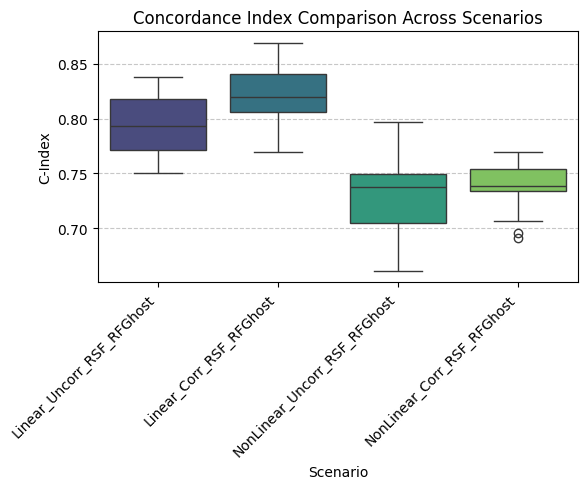

Saved C-Index plot to: simulation1_plots\sim1_cindex_comparison.png

Generating Rank plots (y-axis limit: 5)...
... Rank plot for X1


C:\Users\sanisaza\AppData\Local\Temp\ipykernel_55372\1805666120.py:320: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=var_df, x='scenario_name', y='relevance_rank', jitter=0.2, alpha=0.6, palette='viridis', s=5)


<Figure size 1000x600 with 0 Axes>

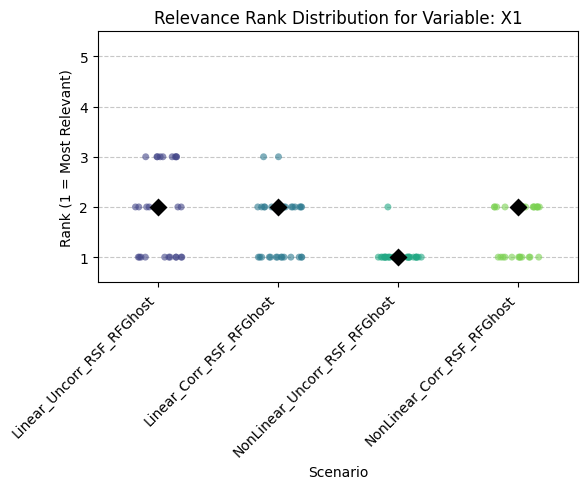

Saved Rank plot for X1 to: simulation1_plots\sim1_rank_comparison_X1.png
... Rank plot for X2


C:\Users\sanisaza\AppData\Local\Temp\ipykernel_55372\1805666120.py:320: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=var_df, x='scenario_name', y='relevance_rank', jitter=0.2, alpha=0.6, palette='viridis', s=5)


<Figure size 1000x600 with 0 Axes>

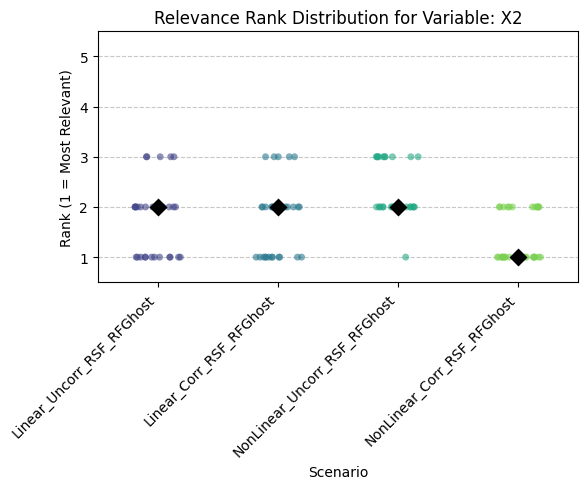

Saved Rank plot for X2 to: simulation1_plots\sim1_rank_comparison_X2.png
... Rank plot for X3


C:\Users\sanisaza\AppData\Local\Temp\ipykernel_55372\1805666120.py:320: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=var_df, x='scenario_name', y='relevance_rank', jitter=0.2, alpha=0.6, palette='viridis', s=5)


<Figure size 1000x600 with 0 Axes>

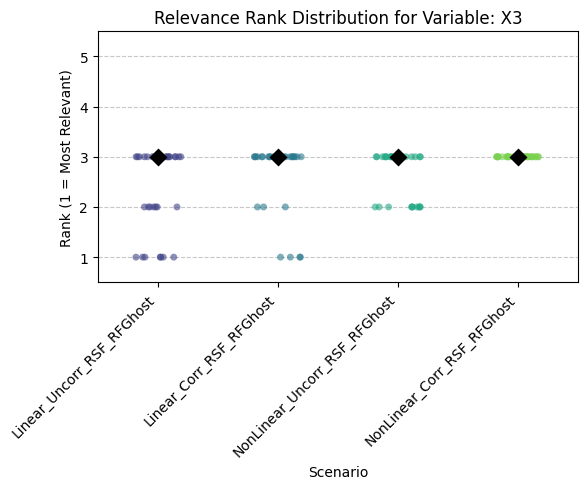

C:\Users\sanisaza\AppData\Local\Temp\ipykernel_55372\1805666120.py:320: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=var_df, x='scenario_name', y='relevance_rank', jitter=0.2, alpha=0.6, palette='viridis', s=5)


Saved Rank plot for X3 to: simulation1_plots\sim1_rank_comparison_X3.png
... Rank plot for X4


<Figure size 1000x600 with 0 Axes>

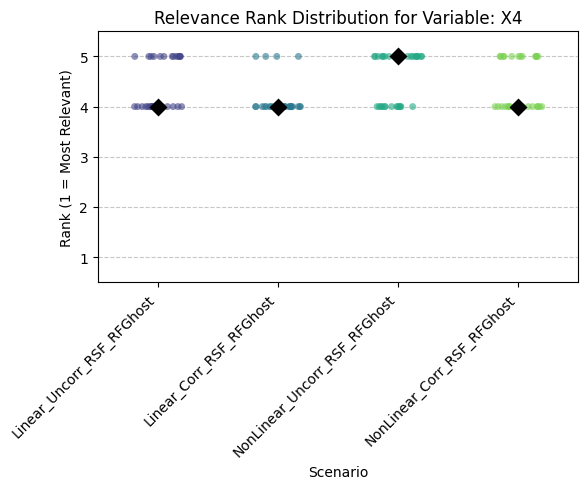

Saved Rank plot for X4 to: simulation1_plots\sim1_rank_comparison_X4.png
... Rank plot for X5


C:\Users\sanisaza\AppData\Local\Temp\ipykernel_55372\1805666120.py:320: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=var_df, x='scenario_name', y='relevance_rank', jitter=0.2, alpha=0.6, palette='viridis', s=5)


<Figure size 1000x600 with 0 Axes>

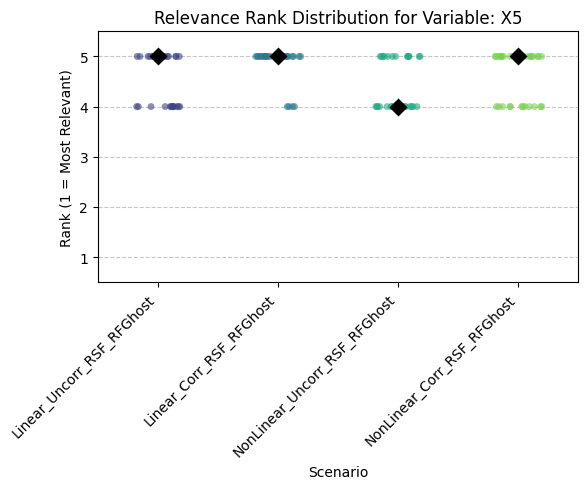

Saved Rank plot for X5 to: simulation1_plots\sim1_rank_comparison_X5.png

Plot generation complete. Check the 'simulation1_plots' directory.


In [ ]:
import os

plot_output_dir = 'simulation1_plots'
summary_file = 'experiment1_summary.csv'

# Create the output directory if it doesn't exist
os.makedirs(plot_output_dir, exist_ok=True)

try:
    summary_df = pd.read_csv(summary_file)
    print(f"Successfully loaded summary data from {summary_file}")

    unique_scenario_names = summary_df['scenario_name'].unique()
    dummy_scenarios = [{'name': name} for name in unique_scenario_names]
    runner_for_plotting = ExperimentRunner(scenarios=dummy_scenarios, n_replicates=1)
    print("Initialized ExperimentRunner for plotting.")

    # --- Generate and Save Plots ---

    # 1. C-Index Comparison Plot
    print("Generating C-Index plot...")
    plt.figure(figsize=(10, 6)) 
    runner_for_plotting.plot_c_index_comparison(summary_df=summary_df)
    cindex_plot_path = os.path.join(plot_output_dir, 'sim1_cindex_comparison.png')
    plt.savefig(cindex_plot_path, bbox_inches='tight')
    plt.close() 
    print(f"Saved C-Index plot to: {cindex_plot_path}")

    # 2. Rank Comparison Plots for key variables
    if 'variable' in summary_df.columns and 'relevance_rank' in summary_df.columns:
        all_plot_vars = sorted([v for v in summary_df['variable'].unique() if v != 'N/A']) # Get unique valid vars

        # Determine max rank for consistent y-axis limit
        max_rank = summary_df['relevance_rank'].max()
        rank_limit = int(max_rank) if pd.notna(max_rank) else len(all_plot_vars)

        print(f"\nGenerating Rank plots (y-axis limit: {rank_limit})...")
        for var in all_plot_vars:
             print(f"... Rank plot for {var}")
             plt.figure(figsize=(10, 6)) #
             runner_for_plotting.plot_rank_comparison(variable=var, summary_df=summary_df, rank_limit=rank_limit)
             rank_plot_path = os.path.join(plot_output_dir, f'sim1_rank_comparison_{var}.png')
             plt.savefig(rank_plot_path, bbox_inches='tight')
             plt.close() 
             print(f"Saved Rank plot for {var} to: {rank_plot_path}")
    else:
        print("Warning: 'variable' or 'relevance_rank' columns not found in summary_df. Skipping rank plots.")


    # 3. Relevance Score Plots
    # if 'variable' in summary_df.columns and 'relevance_score' in summary_df.columns:
    #      print("\nGenerating Relevance Score plots...")
    #      # Example: only for relevant vars based on your simulation design
    #      relevant_vars_example = ['X1', 'X2', 'X3']
    #      for var in relevant_vars_example:
    #           if var in all_plot_vars: # Check if variable exists
    #                print(f"... Relevance plot for {var}")
    #                plt.figure(figsize=(10, 6))
    #                runner_for_plotting.plot_relevance_comparison(variable=var, summary_df=summary_df)
    #                relevance_plot_path = os.path.join(plot_output_dir, f'sim1_relevance_comparison_{var}.png')
    #                plt.savefig(relevance_plot_path, bbox_inches='tight')
    #                plt.close()
    #                print(f"Saved Relevance Score plot for {var} to: {relevance_plot_path}")
    # else:
    #      print("Warning: 'variable' or 'relevance_score' columns not found in summary_df. Skipping relevance plots.")

    print("\nPlot generation complete. Check the 'simulation1_plots' directory.")

except FileNotFoundError:
    print(f"Error: Summary file not found at {summary_file}")
except NameError as e:
     print(f"ERROR: A required class (like ExperimentRunner) is not defined.")
     print("Please make sure you have executed the cell(s) containing the class definitions in your notebook before running this plotting code.")
     print(f"(Specific error: {e})")
except Exception as e:
    print(f"An error occurred during plot generation: {e}")
    import traceback
    traceback.print_exc()

In [ ]:
import pandas as pd
import numpy as np

# --- Load results CSV ---

try:
    df_results = pd.read_csv('experiment1_summary.csv')
except FileNotFoundError:
    print("Error: The CSV file was not found. Please check the path.")
    exit()
except Exception as e:
    print(f"Error reading CSV: {e}")
    exit()

print("Successfully loaded the results CSV.")
print(f"CSV has {len(df_results)} rows.")
print("Columns found:", df_results.columns.tolist())


# --- 1. Calculate C-Index Summary (Mean and Std per Scenario) ---
c_index_per_replicate = df_results[['scenario_name', 'replicate_id', 'c_index']].drop_duplicates()

c_index_summary = c_index_per_replicate.groupby('scenario_name')['c_index'].agg(
    mean_c_index='mean',
    std_c_index='std'
).reset_index()

print("\n--- C-Index Summary ---")
print(c_index_summary.to_string())


# --- 2. Calculate Relevance Score and Rank Summaries (Mean and Std per Scenario, per Variable) ---
variable_summary = df_results.groupby(['scenario_name', 'variable']).agg(
    mean_relevance_score=('relevance_score', 'mean'),
    std_relevance_score=('relevance_score', 'std'),
    mean_relevance_rank=('relevance_rank', 'mean'),
    std_relevance_rank=('relevance_rank', 'std')
).reset_index()

print("\n--- Variable Relevance & Rank Summary ---")
print(variable_summary.to_string())


# --- Combine and Display in the Format I Requested ---
print("\n\n--- Formatted Summary for Sharing ---")
for scenario in c_index_summary['scenario_name'].unique():
    print(f"\nScenario: {scenario}")
    
    # C-Index
    scenario_c_index_data = c_index_summary[c_index_summary['scenario_name'] == scenario]
    if not scenario_c_index_data.empty:
        mean_c = scenario_c_index_data['mean_c_index'].iloc[0]
        std_c = scenario_c_index_data['std_c_index'].iloc[0]
        print(f"* Mean C-Index: {mean_c:.4f} (Std: {std_c:.4f})")
    else:
        print("* Mean C-Index: Data not found")

    # Variable stats
    scenario_var_data = variable_summary[variable_summary['scenario_name'] == scenario].sort_values(by='variable')
    if not scenario_var_data.empty:
        for _, row in scenario_var_data.iterrows():
            var = row['variable']
            mean_rank = row['mean_relevance_rank']
            std_rank = row['std_relevance_rank']
            mean_score = row['mean_relevance_score']
            std_score = row['std_relevance_score']
            print(f"* {var}:")
            print(f"    Mean Rank: {mean_rank:.2f} (Std: {std_rank:.2f})")
            print(f"    Mean Relevance Score (RV_gh): {mean_score:.4f} (Std: {std_score:.4f})")
    else:
        print("* Variable statistics: Data not found for this scenario")

Successfully loaded the results CSV.
CSV has 600 rows.
Columns found: ['scenario_name', 'replicate_id', 'c_index', 'duration_sec', 'ghost_estimator', 'survival_model', 'error', 'variable', 'relevance_score', 'relevance_rank']

--- C-Index Summary ---
                  scenario_name  mean_c_index  std_c_index
0       Linear_Corr_RSF_RFGhost      0.823447     0.023140
1     Linear_Uncorr_RSF_RFGhost      0.794859     0.025895
2    NonLinear_Corr_RSF_RFGhost      0.740169     0.019070
3  NonLinear_Uncorr_RSF_RFGhost      0.728275     0.031278

--- Variable Relevance & Rank Summary ---
                   scenario_name variable  mean_relevance_score  std_relevance_score  mean_relevance_rank  std_relevance_rank
0        Linear_Corr_RSF_RFGhost       X1              0.104694             0.032863             1.600000            0.621455
1        Linear_Corr_RSF_RFGhost       X2              0.112773             0.043694             1.766667            0.727932
2        Linear_Corr_RSF_RFGhost 

In [ ]:
import pandas as pd
import numpy as np

all_results_list = runner.results 

scenario_name_to_analyze = 'NonLinear_Corr_RSF_RFGhost'

list_of_V_matrices_for_scenario = []
for res in all_results_list: 
    if res['scenario_name'] == scenario_name_to_analyze and res['V_matrix_df'] is not None:
        v_matrix = res['V_matrix_df'].to_numpy() 
        if v_matrix.shape == (5, 5): # Adjust shape
            list_of_V_matrices_for_scenario.append(v_matrix)
        else:
            print(f"Warning: V_matrix for replicate {res['replicate_id']} has unexpected shape: {v_matrix.shape}")


if not list_of_V_matrices_for_scenario:
    print(f"No V_matrix_df found for scenario: {scenario_name_to_analyze}")
else:
    # Stack matrices and compute the mean
    # This creates a 3D array (replicates, rows, cols) then takes mean over replicates (axis=0)
    stacked_V_matrices = np.array(list_of_V_matrices_for_scenario)
    V_mean = np.mean(stacked_V_matrices, axis=0)

    print(f"\n--- Mean V Matrix for {scenario_name_to_analyze} ---")
    print(V_mean)

    # Perform Eigen-decomposition
    eigenvalues, eigenvectors = np.linalg.eig(V_mean)

    # Sort eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    print("\n--- Eigenvalues (Sorted) ---")
    print(sorted_eigenvalues)
    
    print("\n--- Proportion of Variance Explained by Eigenvalues ---")
    print(sorted_eigenvalues / np.sum(sorted_eigenvalues))

    print("\n--- Eigenvectors (Sorted, as columns) ---")

    feature_names = [f'X{i+1}' for i in range(V_mean.shape[0])] 
    df_eigenvectors = pd.DataFrame(sorted_eigenvectors, index=feature_names, 
                                   columns=[f'EV{i+1}' for i in range(len(sorted_eigenvalues))])
    print(df_eigenvectors)


--- Mean V Matrix for NonLinear_Corr_RSF_RFGhost ---
[[ 1.93206305e+03 -6.00094696e+02 -4.84855089e+01 -2.16152130e+01
  -9.70246961e+00]
 [-6.00094696e+02  2.33233146e+03 -9.01256108e+00 -4.86825865e+00
  -7.10340979e+00]
 [-4.84855089e+01 -9.01256108e+00  4.45755331e+02 -2.02945365e+01
  -2.52170706e+00]
 [-2.16152130e+01 -4.86825865e+00 -2.02945365e+01  6.32085265e+01
   7.61302058e-01]
 [-9.70246961e+00 -7.10340979e+00 -2.52170706e+00  7.61302058e-01
   5.17597611e+01]]

--- Eigenvalues (Sorted) ---
[2765.00280062 1501.85575236  444.8821893    61.75765458   51.61973345]

--- Proportion of Variance Explained by Eigenvalues ---
[0.57304355 0.31125782 0.09220131 0.0127992  0.01069813]

--- Eigenvectors (Sorted, as columns) ---
         EV1       EV2       EV3       EV4       EV5
X1 -0.584921  0.810010 -0.038451  0.015270  0.006288
X2  0.811034  0.584702 -0.016816  0.006526  0.004694
X3  0.009049 -0.041897 -0.997549  0.055076  0.005055
X4  0.003150 -0.013562  0.055450  0.997435 -0.043

In [ ]:
summary.to_csv('experiment_summary_hrt1.csv', index=False) # Save summary to CSV


--- Final Comparison Summary ---
                  scenario_name  mean_tpr_hrt  std_tpr_hrt  mean_fdp_hrt  std_fdp_hrt  mean_n_selected_hrt  mean_tpr_gc_rank  std_tpr_gc_rank  mean_fdp_gc_rank  std_fdp_gc_rank  mean_n_selected_gc_rank
0       Linear_Corr_RSF_RFGhost      0.999300     0.020000          0.05     0.111803                  3.2            0.9993             0.02              0.02             0.02                      3.0
1     Linear_Uncorr_RSF_RFGhost      0.999300     0.020000          0.08     0.178885                  3.4            0.9993             0.02              0.02             0.02                      3.0
2    NonLinear_Corr_RSF_RFGhost      0.866667     0.182574          0.08     0.178885                  3.0            0.9993             0.02              0.02             0.02                      3.0
3  NonLinear_Uncorr_RSF_RFGhost      0.999300     0.020000          0.05     0.111803                  3.2            0.9993             0.02              0.0

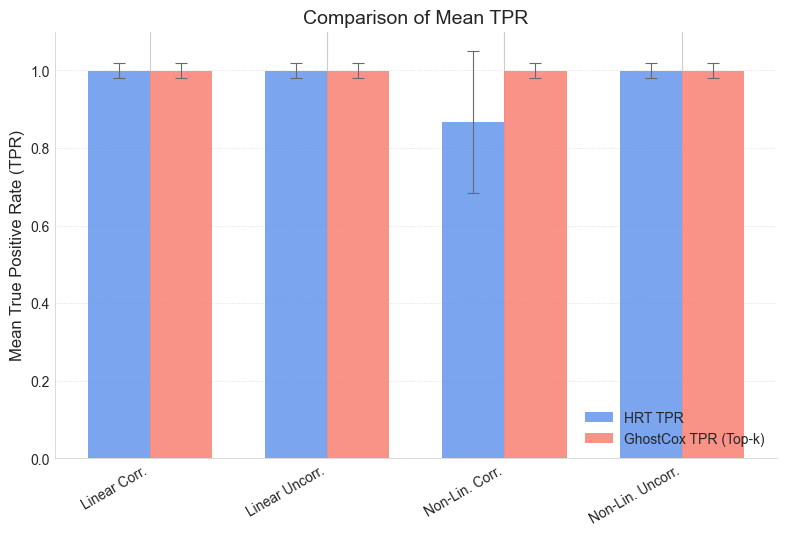

Saved FDP comparison plot to fdp_comparison_final.png


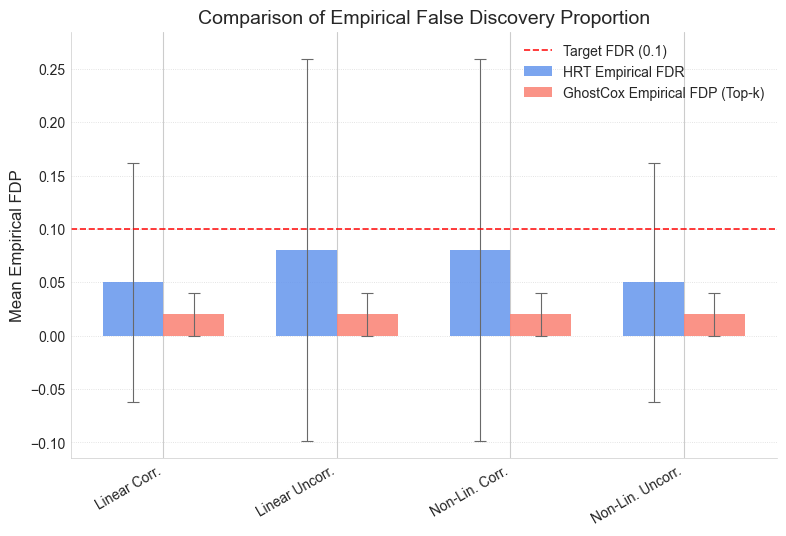

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys


try:
    from pyhrt.utils import bh_predictions, tpr
    from pyhrt.utils import fdr as calculate_fdp_custom
    # print("Successfully imported functions from pyhrt.utils.")
except ImportError as e:
    # print(f"Initial import attempt failed: {e}.")
    def bh_predictions(p_values, fdr_threshold): return np.zeros_like(p_values, dtype=int)
    def tpr(truth, pred, axis=None): return np.nan
    def calculate_fdp_custom(truth, pred, axis=None): return np.nan

TRUE_PREDICTORS_MAP = {
    'Linear_Uncorr_RSF_RFGhost': ['X1', 'X2', 'X3'],
    'Linear_Corr_RSF_RFGhost': ['X1', 'X2', 'X3'],
    'NonLinear_Uncorr_RSF_RFGhost': ['X1', 'X2', 'X3'],
    'NonLinear_Corr_RSF_RFGhost': ['X1', 'X2', 'X3']
}
ALL_FEATURES_ORDERED = ['X1', 'X2', 'X3', 'X4', 'X5']
RESULTS_CSV_PATH = 'experiment_summary_hrt1.csv' 
df_results = pd.read_csv(RESULTS_CSV_PATH)

# Correct column names if necessary
expected_gc_score_col = 'relevance_score_gc'
expected_gc_rank_col = 'relevance_rank_gc'
expected_hrt_pval_col = 'p_value_hrt'
if 'relevance_score' in df_results.columns and expected_gc_score_col not in df_results.columns:
    df_results.rename(columns={'relevance_score': expected_gc_score_col}, inplace=True)
if 'relevance_rank' in df_results.columns and expected_gc_rank_col not in df_results.columns:
    df_results.rename(columns={'relevance_rank': expected_gc_rank_col}, inplace=True)

def calculate_hrt_performance_custom_utils(df_replicate_group, true_predictors_list, all_features_ordered_list, fdr_target=0.1):
    p_values_series = df_replicate_group.set_index('variable')[expected_hrt_pval_col].reindex(all_features_ordered_list)
    p_values_array = p_values_series.fillna(1.0).to_numpy()
    truth_array = np.array([1 if feat in true_predictors_list else 0 for feat in all_features_ordered_list])
    pred_array = bh_predictions(p_values_array, fdr_threshold=fdr_target)
    num_selected = pred_array.sum()
    tpr_val = tpr(truth_array, pred_array)
    fdp_val = calculate_fdp_custom(truth_array, pred_array)
    if num_selected == 0 and np.isnan(fdp_val): fdp_val = 0.0
    return pd.Series({'tpr_hrt': tpr_val, 'fdp_hrt': fdp_val, 'n_selected_hrt': num_selected})

hrt_performance_list_custom = []
for (scenario, replicate_id), group in df_results.groupby(['scenario_name', 'replicate_id']):
    true_preds_for_scenario = TRUE_PREDICTORS_MAP.get(scenario)
    if true_preds_for_scenario is None: continue
    perf_hrt = calculate_hrt_performance_custom_utils(group, true_preds_for_scenario, ALL_FEATURES_ORDERED, fdr_target=0.1)
    perf_hrt['scenario_name'] = scenario; perf_hrt['replicate_id'] = replicate_id
    hrt_performance_list_custom.append(perf_hrt)

hrt_perf_summary_custom = pd.DataFrame()
if hrt_performance_list_custom:
    df_hrt_perf_replicates_custom = pd.DataFrame(hrt_performance_list_custom)
    hrt_perf_summary_custom = df_hrt_perf_replicates_custom.groupby('scenario_name').agg(
        mean_tpr_hrt=('tpr_hrt', 'mean'), std_tpr_hrt=('tpr_hrt', 'std'),
        mean_fdp_hrt=('fdp_hrt', 'mean'), std_fdp_hrt=('fdp_hrt', 'std'),
        mean_n_selected_hrt=('n_selected_hrt', 'mean')
    ).reset_index()

def calculate_ghostcox_performance_custom_utils(df_replicate_group, true_predictors_list, all_features_ordered_list, top_k_to_select):
    ranks_series = df_replicate_group.set_index('variable')[expected_gc_rank_col].reindex(all_features_ordered_list)
    ranks_array = ranks_series.fillna(len(all_features_ordered_list) + 1).to_numpy()
    truth_array = np.array([1 if feat in true_predictors_list else 0 for feat in all_features_ordered_list])
    pred_array_gc = np.zeros_like(ranks_array, dtype=int)
    sorted_indices_by_rank = np.argsort(ranks_array)
    pred_array_gc[sorted_indices_by_rank[:top_k_to_select]] = 1
    num_selected_gc = pred_array_gc.sum()
    tpr_val_gc = tpr(truth_array, pred_array_gc)
    fdp_val_gc = calculate_fdp_custom(truth_array, pred_array_gc)
    if num_selected_gc == 0 and np.isnan(fdp_val_gc): fdp_val_gc = 0.0
    return pd.Series({'tpr_gc_rank': tpr_val_gc, 'fdp_gc_rank': fdp_val_gc, 'n_selected_gc_rank': num_selected_gc})

gc_performance_list_rank_custom = []
for (scenario, replicate_id), group in df_results.groupby(['scenario_name', 'replicate_id']):
    true_preds_for_scenario = TRUE_PREDICTORS_MAP.get(scenario)
    if true_preds_for_scenario is None: continue
    k_to_select = len(true_preds_for_scenario)
    perf_gc = calculate_ghostcox_performance_custom_utils(group, true_preds_for_scenario, ALL_FEATURES_ORDERED, top_k_to_select=k_to_select)
    perf_gc['scenario_name'] = scenario; perf_gc['replicate_id'] = replicate_id
    gc_performance_list_rank_custom.append(perf_gc)

gc_perf_summary_rank_custom = pd.DataFrame()
if gc_performance_list_rank_custom:
    df_gc_perf_replicates_rank_custom = pd.DataFrame(gc_performance_list_rank_custom)
    gc_perf_summary_rank_custom = df_gc_perf_replicates_rank_custom.groupby('scenario_name').agg(
        mean_tpr_gc_rank=('tpr_gc_rank', 'mean'), std_tpr_gc_rank=('tpr_gc_rank', 'std'),
        mean_fdp_gc_rank=('fdp_gc_rank', 'mean'), std_fdp_gc_rank=('fdp_gc_rank', 'std'),
        mean_n_selected_gc_rank=('n_selected_gc_rank', 'mean')
    ).reset_index()

final_comparison_summary = pd.DataFrame()
if not hrt_perf_summary_custom.empty:
    final_comparison_summary = hrt_perf_summary_custom.copy()
    if not gc_perf_summary_rank_custom.empty:
        final_comparison_summary = pd.merge(final_comparison_summary, gc_perf_summary_rank_custom, on='scenario_name', how='outer')
        print("\n--- Final Comparison Summary ---")
        print(final_comparison_summary.to_string())

elif not gc_perf_summary_rank_custom.empty:     
    final_comparison_summary = gc_perf_summary_rank_custom.copy()
    print("\n--- Final Comparison Summary ---")
    print(final_comparison_summary.to_string())


# --- Enhanced Plotting Functions with Auto Y-axis ---
SCENARIO_PLOT_NAMES = {
    'Linear_Uncorr_RSF_RFGhost': 'Linear Uncorr.', 
    'Linear_Corr_RSF_RFGhost': 'Linear Corr.',   
    'NonLinear_Uncorr_RSF_RFGhost': 'Non-Lin. Uncorr.', 
    'NonLinear_Corr_RSF_RFGhost': 'Non-Lin. Corr.'    
}

plt.style.use('seaborn-v0_8-whitegrid')
FONT_SIZE_LABEL = 12
FONT_SIZE_TITLE = 14
FONT_SIZE_TICKS = 10
FONT_SIZE_LEGEND = 10

plt.rcParams.update({
    'font.size': FONT_SIZE_LABEL, 'axes.labelsize': FONT_SIZE_LABEL,
    'axes.titlesize': FONT_SIZE_TITLE, 'xtick.labelsize': FONT_SIZE_TICKS,
    'ytick.labelsize': FONT_SIZE_TICKS, 'legend.fontsize': FONT_SIZE_LEGEND,
    'figure.dpi': 100
})

def plot_tpr_comparison_enhanced(summary_df: pd.DataFrame,
                                 metric_tpr_hrt='mean_tpr_hrt', err_tpr_hrt='std_tpr_hrt',
                                 metric_tpr_gc='mean_tpr_gc_rank', err_tpr_gc='std_tpr_gc_rank',
                                 output_filename="tpr_comparison_plot.png"):
    if summary_df.empty or not all(col in summary_df.columns for col in [metric_tpr_hrt, metric_tpr_gc]):
        print("Plotting TPR skipped: summary_df is empty or missing required TPR metric columns.")
        return



    plot_scenario_names = summary_df['scenario_name'].map(SCENARIO_PLOT_NAMES).fillna(summary_df['scenario_name'])
    num_scenarios = len(plot_scenario_names)
    index = np.arange(num_scenarios)
    bar_width = 0.35

    fig, ax = plt.subplots(figsize=(max(7, num_scenarios * 2), 5.5))

    yerr_tpr_hrt_values = summary_df[err_tpr_hrt].values if err_tpr_hrt in summary_df else None
    yerr_tpr_gc_values = summary_df[err_tpr_gc].values if err_tpr_gc in summary_df else None

    bars_hrt = ax.bar(index - bar_width/2, summary_df[metric_tpr_hrt], bar_width,
                      label='HRT TPR', color='cornflowerblue', alpha=0.85,
                      yerr=yerr_tpr_hrt_values, capsize=4, ecolor='dimgray', error_kw={'elinewidth':0.8, 'capthick':0.8})
    bars_gc = ax.bar(index + bar_width/2, summary_df[metric_tpr_gc], bar_width,
                     label='GhostCox TPR (Top-k)', color='salmon', alpha=0.85,
                     yerr=yerr_tpr_gc_values, capsize=4, ecolor='dimgray', error_kw={'elinewidth':0.8, 'capthick':0.8})

    #ax.set_xlabel("Scenario", fontsize=FONT_SIZE_LABEL)
    ax.set_ylabel('Mean True Positive Rate (TPR)', fontsize=FONT_SIZE_LABEL)
    ax.set_title('Comparison of Mean TPR', fontsize=FONT_SIZE_TITLE) 
    ax.set_xticks(index)
    ax.set_xticklabels(plot_scenario_names, rotation=30, ha="right", fontsize=FONT_SIZE_TICKS)
    ax.legend(loc='lower right', frameon=False, fontsize=FONT_SIZE_LEGEND) 
    ax.grid(True, which='major', axis='y', linestyle=':', linewidth=0.6, alpha=0.7)
    
    # Automatic Y-axis limits for TPR
    min_val = 0
    max_val = 1.0 
    
    # Consider error bars for max_val
    if yerr_tpr_hrt_values is not None:
        max_val = max(max_val, (summary_df[metric_tpr_hrt] + yerr_tpr_hrt_values).max())
    if yerr_tpr_gc_values is not None:
        max_val = max(max_val, (summary_df[metric_tpr_gc] + yerr_tpr_gc_values).max())
        
    ax.set_ylim(min_val, min(max_val * 1.05, 1.1)) 
    
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5); ax.spines['bottom'].set_linewidth(0.5)
    ax.tick_params(axis='both', which='major', width=0.5)

    plt.tight_layout(pad=1.0)
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"Saved TPR comparison plot to {output_filename}")
    plt.show()


def plot_fdp_comparison_enhanced(summary_df: pd.DataFrame,
                                 metric_fdp_hrt='mean_fdp_hrt', err_fdp_hrt='std_fdp_hrt',
                                 metric_fdp_gc='mean_fdp_gc_rank', err_fdp_gc='std_fdp_gc_rank',
                                 fdr_target=0.1,
                                 output_filename="fdp_comparison_plot.png"):
    if summary_df.empty or not all(col in summary_df.columns for col in [metric_fdp_hrt, metric_fdp_gc]):
        print("Plotting FDP skipped: summary_df is empty or missing required FDP metric columns.")
        return

    plot_scenario_names = summary_df['scenario_name'].map(SCENARIO_PLOT_NAMES).fillna(summary_df['scenario_name'])
    num_scenarios = len(plot_scenario_names)
    index = np.arange(num_scenarios)
    bar_width = 0.35

    fig, ax = plt.subplots(figsize=(max(7, num_scenarios * 2), 5.5))

    yerr_fdp_hrt_values = summary_df[err_fdp_hrt].values if err_fdp_hrt in summary_df else None
    yerr_fdp_gc_values = summary_df[err_fdp_gc].values if err_fdp_gc in summary_df else None

    bars_hrt = ax.bar(index - bar_width/2, summary_df[metric_fdp_hrt], bar_width,
                      label='HRT Empirical FDR', color='cornflowerblue', alpha=0.85,
                      yerr=yerr_fdp_hrt_values, capsize=4, ecolor='dimgray', error_kw={'elinewidth':0.8, 'capthick':0.8})
    bars_gc = ax.bar(index + bar_width/2, summary_df[metric_fdp_gc], bar_width,
                      label='GhostCox Empirical FDP (Top-k)', color='salmon', alpha=0.85,
                      yerr=yerr_fdp_gc_values, capsize=4, ecolor='dimgray', error_kw={'elinewidth':0.8, 'capthick':0.8})

    ax.axhline(fdr_target, ls='--', color='red', label=f'Target FDR ({fdr_target})', linewidth=1.2, alpha=0.9)


    #ax.set_xlabel("Scenario", fontsize=FONT_SIZE_LABEL)
    ax.set_ylabel('Mean Empirical FDP', fontsize=FONT_SIZE_LABEL)
    ax.set_title('Comparison of Empirical False Discovery Proportion', fontsize=FONT_SIZE_TITLE)
    ax.set_xticks(index)
    ax.set_xticklabels(plot_scenario_names, rotation=30, ha="right", fontsize=FONT_SIZE_TICKS)
    ax.legend(loc='upper right', frameon=False, fontsize=FONT_SIZE_LEGEND) 
    ax.grid(True, which='major', axis='y', linestyle=':', linewidth=0.6, alpha=0.7)
    
    # Automatic Y-axis limits for FDP
    min_val_fdp = 0
    max_val_fdp = fdr_target 
    
    # Consider error bars for max_val_fdp
    current_maxes = []
    if yerr_fdp_hrt_values is not None:
        current_maxes.append((summary_df[metric_fdp_hrt] + yerr_fdp_hrt_values).max())
    if yerr_fdp_gc_values is not None:
        current_maxes.append((summary_df[metric_fdp_gc] + yerr_fdp_gc_values).max())
    
    if current_maxes: 
         max_val_fdp = max(max_val_fdp, pd.Series(current_maxes).max())


    ax.set_ylim(min(0, min_val_fdp * (-1.1), fdr_target * (-1.15)) , max(0.20, max_val_fdp * 1.1, fdr_target * 1.15) ) 
    
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5); ax.spines['bottom'].set_linewidth(0.5)
    ax.tick_params(axis='both', which='major', width=0.5)

    plt.tight_layout(pad=1.0)
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"Saved FDP comparison plot to {output_filename}")
    plt.show()

# --- Call the plotting functions ---
if not final_comparison_summary.empty:
    # Create the TPR plot
    plot_tpr_comparison_enhanced(final_comparison_summary, output_filename="tpr_comparison_final.png")
    
    # Create the FDP plot
    plot_fdp_comparison_enhanced(final_comparison_summary, fdr_target=0.1, output_filename="fdp_comparison_final.png")
else:
    print("Final comparison summary is empty. Skipping plots.")

In [32]:
final_comparison_summary.to_csv('experiment_summary_hrt_final.csv', index=False) # Save final summary to CSV

### Robust Experiment

In [ ]:
# --- Assuming previous definitions are present: ---
# import pandas as pd
# import numpy as np
# from experiment_runner import ExperimentRunner # Your class
# from survival_data_generator import SurvivalDataGenerator # Your class
# from nonlinear_survival_model import NonLinearSurvivalModel # Your class
# from ghost_variables import GhostVariableEstimator, LinearGAM # Your class and imported GAM

# --- Parameters from your previous setup ---
N_SAMPLES = 25 # 25, 50, 100, 200, 500, 1000, 2000, 5000, 10000
N_FEATURES = 5
N_REPLICATES_GHOST_STUDY = 50 # 
RANDOM_STATE_BASE = 2025
RANDOM_STATE_BASE_GHOST_STUDY = RANDOM_STATE_BASE + 100 
TARGET_CENSORING_LAMBDA = 0.015 # 0.001, 0.005, 0.015
beta_linear = np.array([1.0, 1.0, -1.0, 0.0, 0.0])
corr_matrix_example = np.array([
    [1.0, 0.7, 0.0, 0.0, 0.0], [0.7, 1.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.5, 0.0], [0.0, 0.0, 0.5, 1.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 1.0]
])


expected_gc_score_col = 'relevance_score_gc'
expected_gc_rank_col = 'relevance_rank_gc'
expected_hrt_pval_col = 'p_value_hrt'

# --- Base Data and Model Params ---
base_data_params_corr = {
    'n_samples': N_SAMPLES, 'n_features': N_FEATURES,
    'feature_generation_type': 'correlated', 'corr_matrix': corr_matrix_example,
    'censoring_dist_lambda': TARGET_CENSORING_LAMBDA, 'contamination_prop': 0.0
}
base_rsf_model_params = {'model_type': 'rsf', 'n_estimators': 100, 'min_samples_leaf': 15}


# Default RF params for Ghost Estimator
default_rf_ghost_params = {
    'estimator_type': 'rf', 'n_jobs': 1,
    'n_estimators': 100, 'random_state': 42, 
    'max_depth': 10, 'min_samples_leaf': 5
}
default_gam_ghost_params = {
    'estimator_type': 'gam', 'n_jobs': 1,
    'n_splines': 10 
}


# --- SCENARIO DEFINITIONS for Impact of Ghost Estimator Choice ---
scenarios_for_ghost_estimator_study = [
    # === Scenario: Linear Correlated Data ===
    {
        'name': 'LinCorr_RSF_LMGhost', # BaseScenario_MainModel_GhostEstimator
        'data_params': {**base_data_params_corr, 'beta_coeffs': beta_linear, 'nonlinear_func': None},
        'model_params': base_rsf_model_params,
        'ghost_params': {'estimator_type': 'lm', 'n_jobs': 1}, # Linear Model for ghost
        'run_hrt': False 
    },
    {
        'name': 'LinCorr_RSF_RFGhost', 
        'data_params': {**base_data_params_corr, 'beta_coeffs': beta_linear, 'nonlinear_func': None},
        'model_params': base_rsf_model_params,
        'ghost_params': default_rf_ghost_params, # Random Forest for ghost
        'run_hrt': False
    },
    {
        'name': 'LinCorr_RSF_GAMGhost',
        'data_params': {**base_data_params_corr, 'beta_coeffs': beta_linear, 'nonlinear_func': None},
        'model_params': base_rsf_model_params,
        'ghost_params': default_gam_ghost_params, # GAM for ghost
        'run_hrt': False
    } if LinearGAM is not None else None, # Conditionally include if pygam is installed

    # === Scenario: Non-Linear Correlated Data ===
    {
        'name': 'NonLinCorr_RSF_LMGhost',
        'data_params': {**base_data_params_corr, 'beta_coeffs': None, 'nonlinear_func': nonlinear_predictor_func},
        'model_params': base_rsf_model_params,
        'ghost_params': {'estimator_type': 'lm', 'n_jobs': 1},
        'run_hrt': False
    },
    {
        'name': 'NonLinCorr_RSF_RFGhost',
        'data_params': {**base_data_params_corr, 'beta_coeffs': None, 'nonlinear_func': nonlinear_predictor_func},
        'model_params': base_rsf_model_params,
        'ghost_params': default_rf_ghost_params,
        'run_hrt': False
    },
    {
        'name': 'NonLinCorr_RSF_GAMGhost',
        'data_params': {**base_data_params_corr, 'beta_coeffs': None, 'nonlinear_func': nonlinear_predictor_func},
        'model_params': base_rsf_model_params,
        'ghost_params': default_gam_ghost_params,
        'run_hrt': False
    } if LinearGAM is not None else None,
    
]

# Filter out any None entries 
scenarios_for_run_ghost_study = [s for s in scenarios_for_ghost_estimator_study if s is not None]

# --- Initialize and run the ExperimentRunner ---
if scenarios_for_run_ghost_study:
    runner_ghost_impact = ExperimentRunner(
        scenarios=scenarios_for_run_ghost_study,
        n_replicates=N_REPLICATES_GHOST_STUDY, 
        random_state_base=RANDOM_STATE_BASE_GHOST_STUDY 
    )
    summary_df_ghost_impact = runner_ghost_impact.run_experiment()

    # --- Basic Analysis of the summary_df_ghost_impact ---
    if summary_df_ghost_impact is not None and not summary_df_ghost_impact.empty:
        print("\n\n--- Summary from Ghost Estimator Impact Study ---")
        
        def extract_parts(name):
            parts = name.split('_RSF_')
            base = parts[0]
            ghost_est = parts[1].replace('Ghost', '') if len(parts) > 1 else 'Unknown'
            return pd.Series([base, ghost_est])
        
        summary_df_ghost_impact[['base_scenario_type', 'ghost_estimator_config']] = summary_df_ghost_impact['scenario_name'].apply(extract_parts)

        # Group by base scenario, ghost estimator, and variable to compare RV_gh and Ranks
        comparison_results = summary_df_ghost_impact.groupby(
            ['base_scenario_type', 'ghost_estimator_config', 'variable']
        ).agg(
            mean_RVgh=(expected_gc_score_col, 'mean'), 
            std_RVgh=(expected_gc_score_col, 'std'),
            mean_Rank=(expected_gc_rank_col, 'mean'),
            std_Rank=(expected_gc_rank_col, 'std'),
            mean_C_Index_overall=('c_index', 'mean') # C-index is per replicate, will be same for all vars in that replicate
        ).reset_index()
        
        print(comparison_results.to_string())

        comparison_results['samples'] = N_SAMPLES
        comparison_results['replicates'] = N_REPLICATES_GHOST_STUDY
        comparison_results['target_censoring_lambda'] = TARGET_CENSORING_LAMBDA
        
else:
    print("No scenarios were run for the ghost estimator impact study.")

summary_df_ghost_impact.to_csv('experiment_summary_ghost_impact_{}_{}.csv'.format(N_SAMPLES, str(TARGET_CENSORING_LAMBDA)[-2:]), index=False) 
comparison_results.to_csv('ghost_impact_comparison_{}_{}.csv'.format(N_SAMPLES, str(TARGET_CENSORING_LAMBDA)[-2:]), index=False) 

In [ ]:
# ------------------------------------------------------------------
# 1. Grid of design-points 
# ------------------------------------------------------------------
N_SAMPLES_GRID           = [25, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
TARGET_CENSORING_LAMBDAS = [0.025,0.05, 0.1]

# ------------------------------------------------------------------
# 2. Collect every run in these lists and write once at the very end
# ------------------------------------------------------------------
all_summaries   = []      # list-of-DataFrames from ExperimentRunner.run_experiment()
all_comparisons = []      # list-of-DataFrames

# ------------------------------------------------------------------
# 3. Double loop over the grid
# ------------------------------------------------------------------
for n in N_SAMPLES_GRID:
    for lam in TARGET_CENSORING_LAMBDAS:
        print(f"\n▶ Running study with n={n:,} | λ_censor={lam}")

        # ------------------------------------------------------------------
        # 3-a.  Update the data parameters for design-point
        # ------------------------------------------------------------------
        base_data_params_corr.update({"n_samples": n,
                                      "censoring_dist_lambda": lam})

        # ------------------------------------------------------------------
        # 3-b.  Build the scenario list exactly as before
        # ------------------------------------------------------------------
        scenarios_for_ghost_estimator_study = [
            {   # Linear – LM-ghost
                "name": "LinCorr_RSF_LMGhost",
                "data_params": {**base_data_params_corr,
                                "beta_coeffs": beta_linear,
                                "nonlinear_func": None},
                "model_params": base_rsf_model_params,
                "ghost_params": {"estimator_type": "lm", "n_jobs": 1},
                "run_hrt": False,
            },
        ]
        scenarios_for_run_ghost_study = [s for s in scenarios_for_ghost_estimator_study
                                         if s is not None]

        # ------------------------------------------------------------------
        # 3-c.  Run the experiment
        # ------------------------------------------------------------------
        runner = ExperimentRunner(
            scenarios      = scenarios_for_run_ghost_study,
            n_replicates   = 5,
            random_state_base = RANDOM_STATE_BASE_GHOST_STUDY
                                 + hash((n, lam)) % 10_000  # keeps seeds distinct
        )
        summary_df = runner.run_experiment()

        # ------------------------------------------------------------------
        # 3-d.  Summarise & store
        # ------------------------------------------------------------------
        if summary_df is not None and not summary_df.empty:
            summary_df["samples"]                 = n
            summary_df["target_censoring_lambda"] = lam
            all_summaries.append(summary_df)

            def _split(name):
                base, ghost = name.split("_RSF_")
                return pd.Series([base, ghost.replace("Ghost", "")])

            comparison = (
                summary_df
                .assign(**dict(summary_df["scenario_name"].apply(_split)
                               .rename({0: "base_scenario_type",
                                        1: "ghost_estimator_config"}, axis=1)))
                .groupby(["base_scenario_type", "ghost_estimator_config", "variable"])
                .agg(mean_RVgh  =(expected_gc_score_col, "mean"),
                     std_RVgh   =(expected_gc_score_col, "std"),
                     mean_Rank  =(expected_gc_rank_col, "mean"),
                     std_Rank   =(expected_gc_rank_col, "std"),
                     mean_C_indx=("c_index", "mean"))
                .reset_index()
            )
            comparison["samples"]                 = n
            comparison["target_censoring_lambda"] = lam
            all_comparisons.append(comparison)

            comparison.to_csv(
                f"ghost_impact_comparison_{n}_{str(lam).replace('.', '')}.csv",
                index=False
            )

# # ------------------------------------------------------------------
# # 4. Write the grand table once the sweep is finished
# # ------------------------------------------------------------------
# if all_summaries:
#     pd.concat(all_summaries,   ignore_index=True).to_csv(
#         "ALL_experiment_summaries.csv",   index=False
#     )
# if all_comparisons:
#     pd.concat(all_comparisons, ignore_index=True).to_csv(
#         "ALL_ghost_impact_comparisons.csv", index=False
#     )


In [ ]:
# --- Imports ---------------------------------------------------------------
from pathlib import Path       
import pandas as pd

# --- Configuration ---------------------------------------------------------
DATA_DIR   = Path(".")          # folder that holds the CSVs ('.' = current working dir)
PATTERN    = "ALL_ghost_impact_comparison*.csv"   # wildcard pattern
READ_KWARGS = {                
    "dtype"        : "string", 
    "na_filter"    : True,
    "low_memory"   : False
}

# --- Gather matching files -------------------------------------------------
csv_files = sorted(DATA_DIR.glob(PATTERN))     
if not csv_files:
    raise FileNotFoundError(f"No files matched: {DATA_DIR / PATTERN}")

# --- Read & concatenate ----------------------------------------------------
dfs = [pd.read_csv(f, **READ_KWARGS) for f in csv_files]

combined_df = pd.concat(dfs, ignore_index=True, sort=False)  # outer join on columns

# --- sanity checks ------------------------------------------------
print(f"Loaded {len(csv_files)} files → {combined_df.shape[0]:,} rows × {combined_df.shape[1]} cols")
combined_df.head()




--- Analysis Part 1: Impact of Ghost Estimator Choice ---
Filtering for Impact of Ghost Estimator study: N=500, Lambda=0.005

Comparison Table for Ghost Estimator Impact (Filtered Data):
    base_scenario_type ghost_estimator_config variable  mean_RVgh  std_RVgh  mean_Rank  std_Rank mean_C_Index_overall  samples replicates  target_censoring_lambda
690            LinCorr                    GAM       X1   0.134969  0.051364   1.633333  0.556053    0.824863622237829      500         30                    0.005
695            LinCorr                     LM       X1   0.165269  0.050675   1.833333  0.698932    0.832617044443243      500         30                    0.005
700            LinCorr                     RF       X1   0.114826   0.03811   1.566667  0.626062   0.8224383564605733      500         30                    0.005
691            LinCorr                    GAM       X2   0.149586  0.049121        1.5  0.682288    0.824863622237829      500         30                    0.

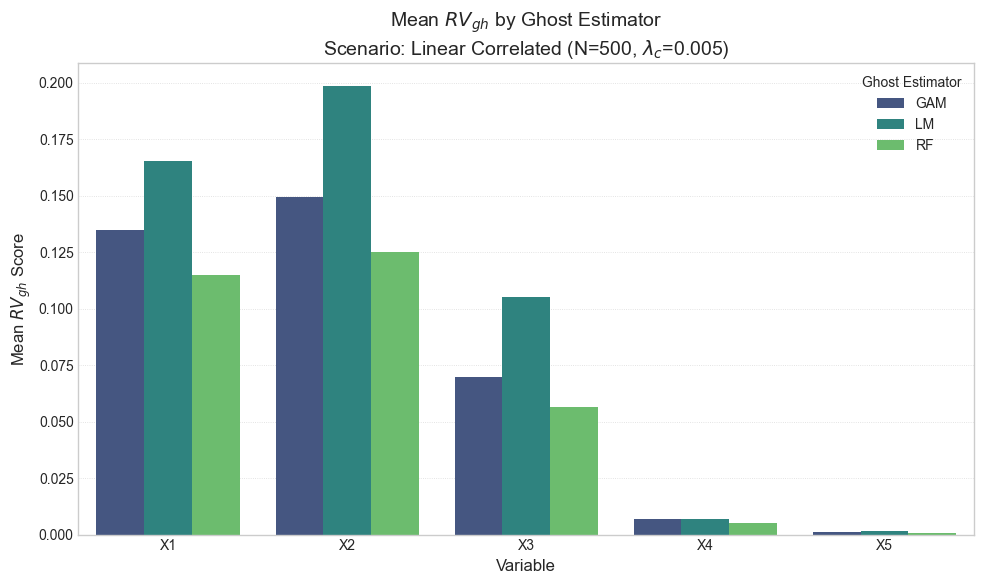

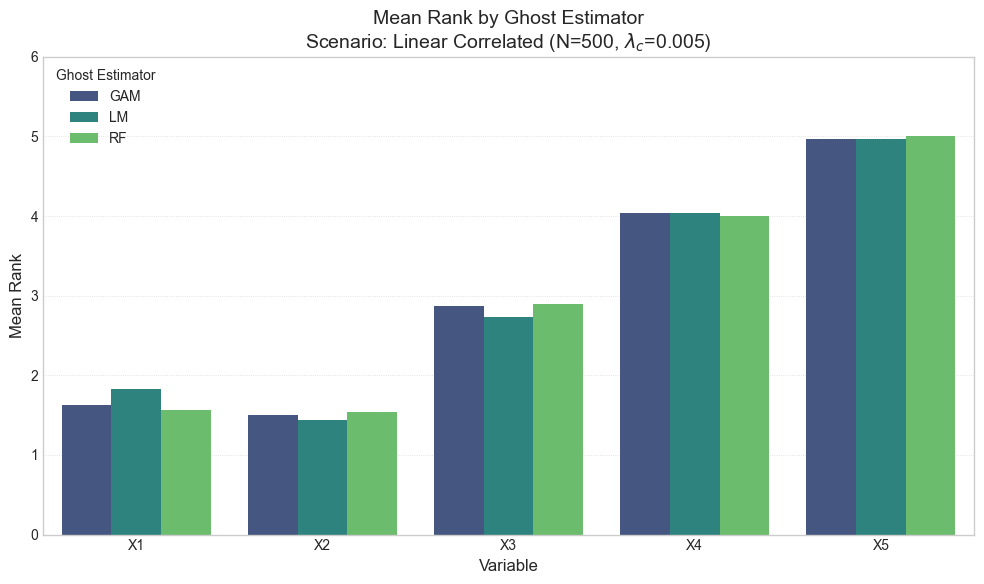

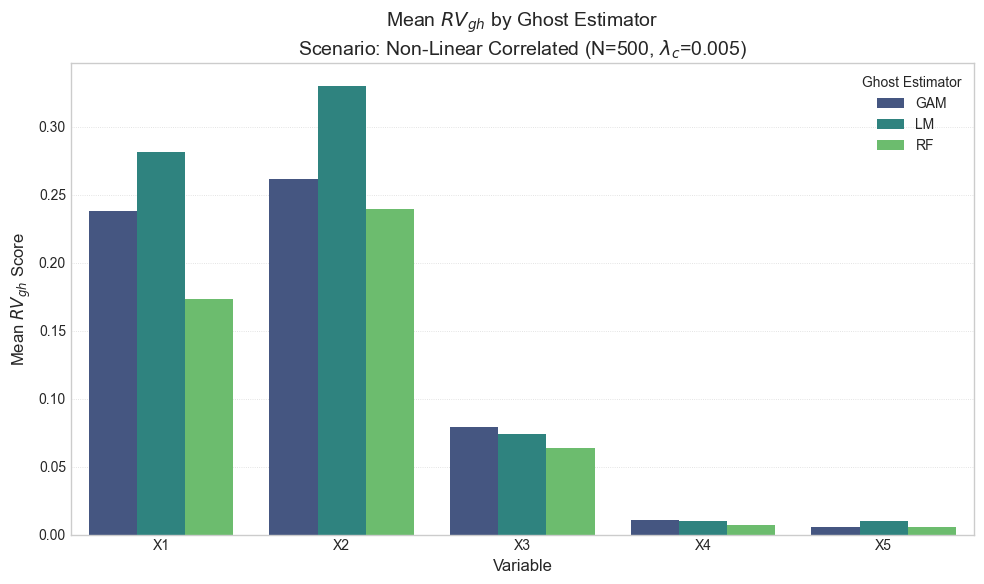

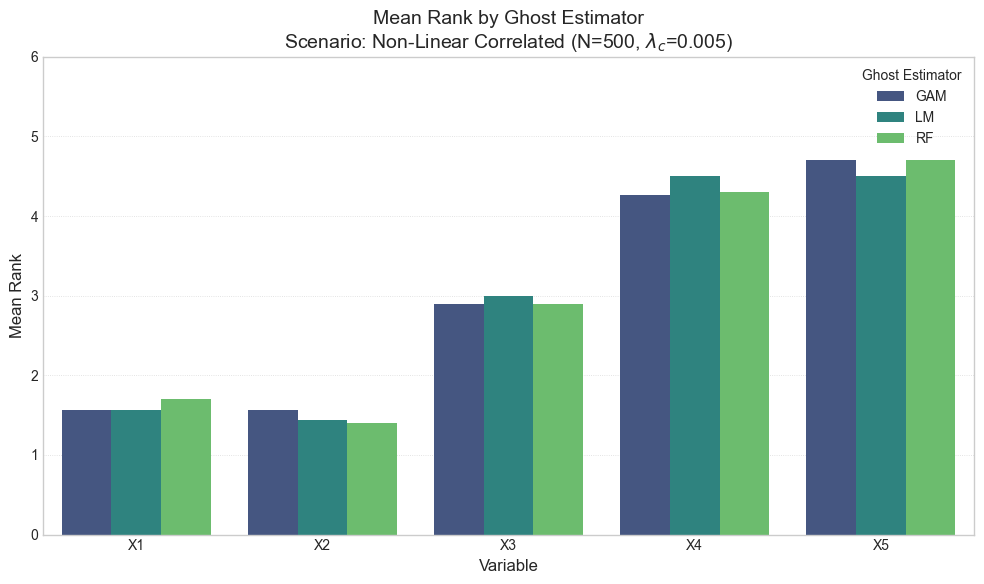



--- Analysis Part 2: Sensitivity to Sample Size (N) ---
Filtering for Sample Size study: GhostEstimator=GAM, Lambda=0.005

Aggregated Table for Sample Size Impact:
    base_scenario_type ghost_estimator_config variable  mean_RVgh  std_RVgh  mean_Rank  std_Rank mean_C_Index_overall  samples replicates  target_censoring_lambda
510            LinCorr                    GAM       X1       <NA>      <NA>       <NA>      <NA>                  0.5       25         30                    0.005
511            LinCorr                    GAM       X2       <NA>      <NA>       <NA>      <NA>                  0.5       25         30                    0.005
512            LinCorr                    GAM       X3       <NA>      <NA>       <NA>      <NA>                  0.5       25         30                    0.005
513            LinCorr                    GAM       X4       <NA>      <NA>       <NA>      <NA>                  0.5       25         30                    0.005
514            LinC

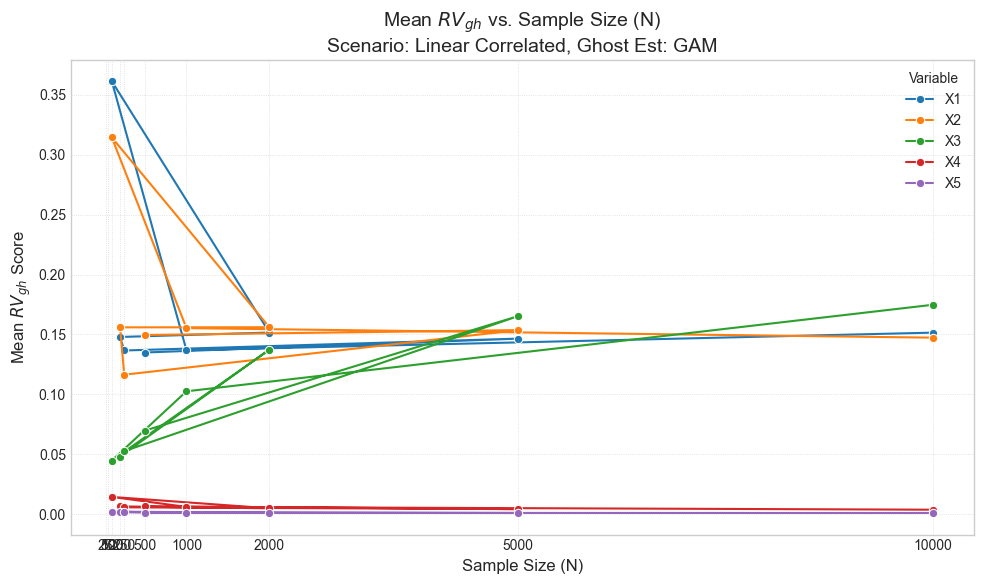

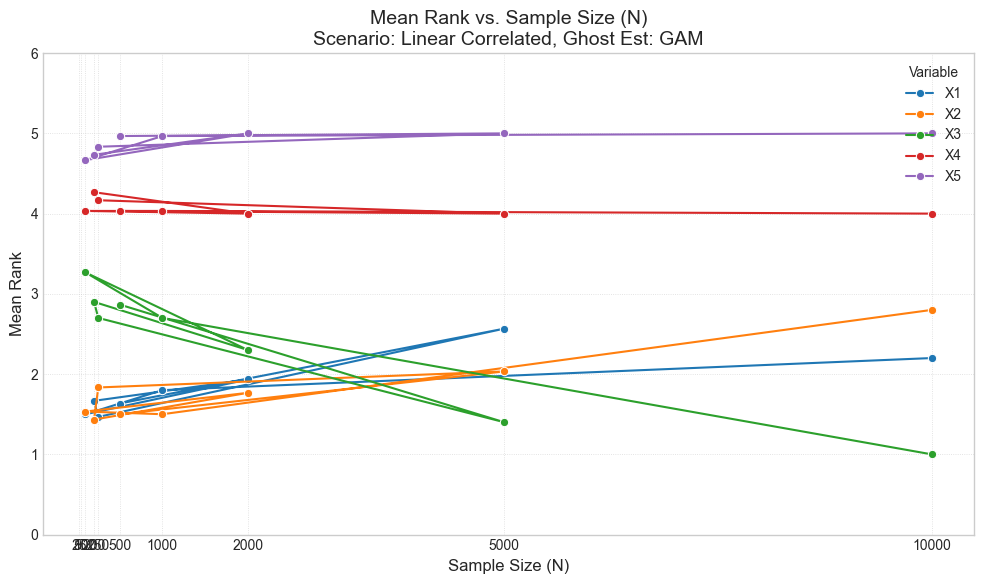

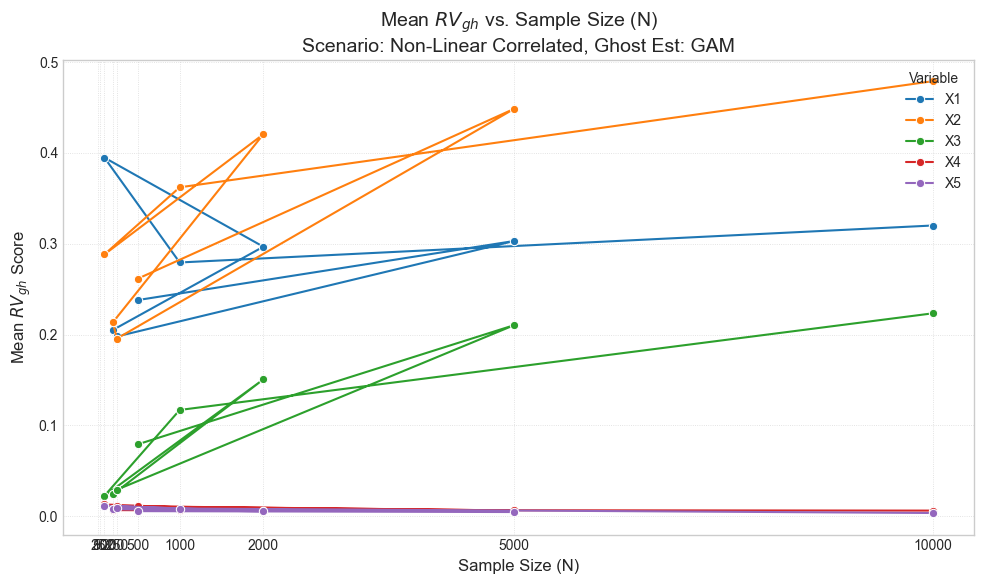

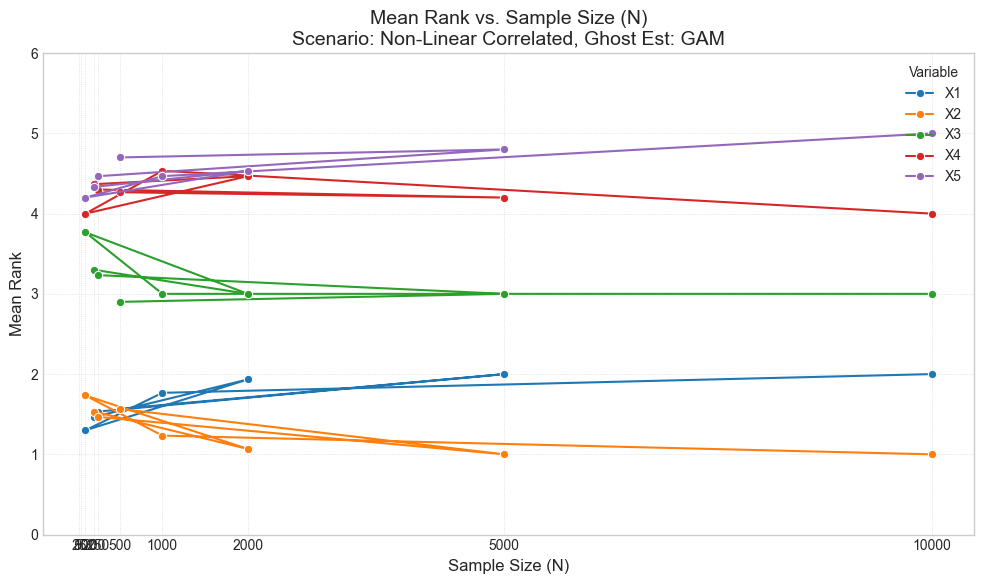



--- Analysis Part 3: Sensitivity to Censoring Rate ---
Filtering for Censoring Rate study: GhostEstimator=GAM, N=500

Aggregated Table for Censoring Impact:
    base_scenario_type ghost_estimator_config variable  mean_RVgh  std_RVgh  mean_Rank  std_Rank mean_C_Index_overall  samples replicates  target_censoring_lambda
660            LinCorr                    GAM       X1   0.120501  0.036665        2.0  0.707107   0.8179740756665016      500          5                    0.001
661            LinCorr                    GAM       X2   0.163785   0.04464        1.2  0.447214   0.8179740756665016      500          5                    0.001
662            LinCorr                    GAM       X3   0.071362  0.024836        2.8  0.447214   0.8179740756665016      500          5                    0.001
663            LinCorr                    GAM       X4   0.006894  0.006923        4.2  0.447214   0.8179740756665016      500          5                    0.001
664            LinCorr    

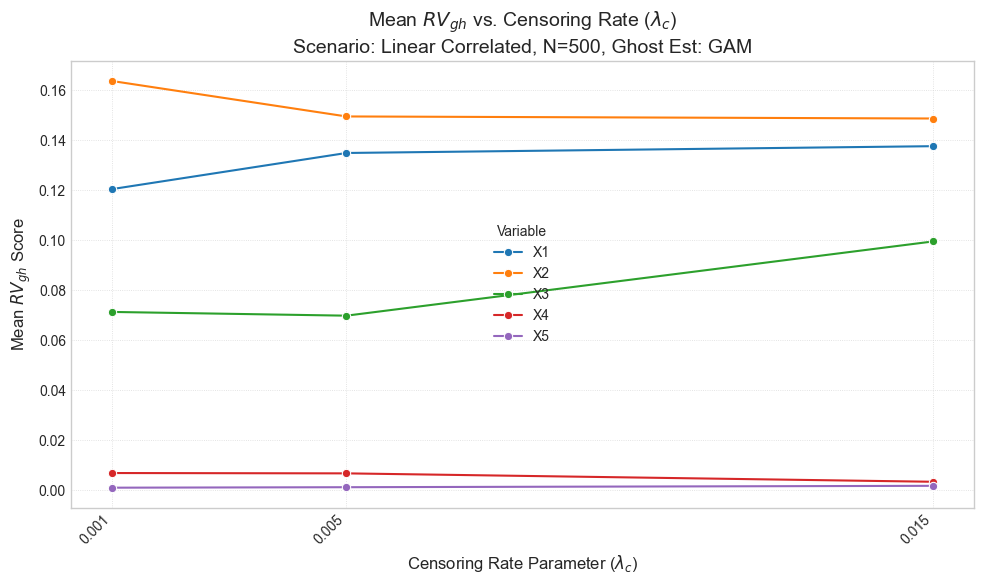

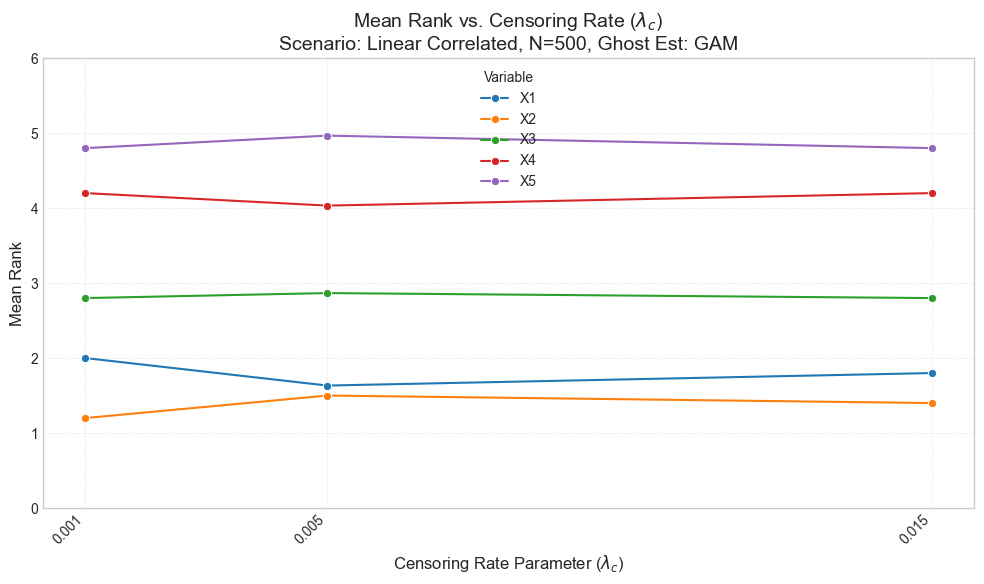

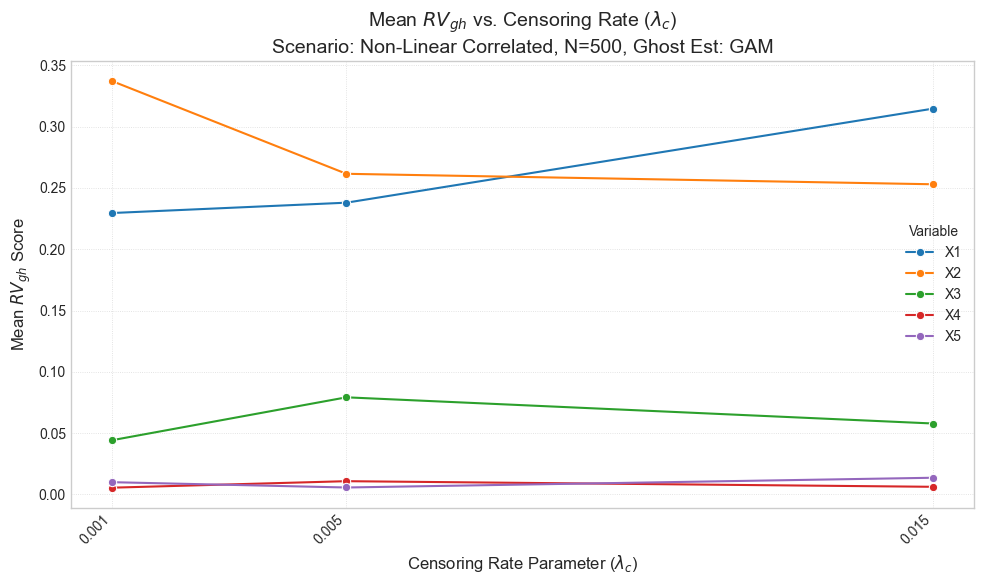

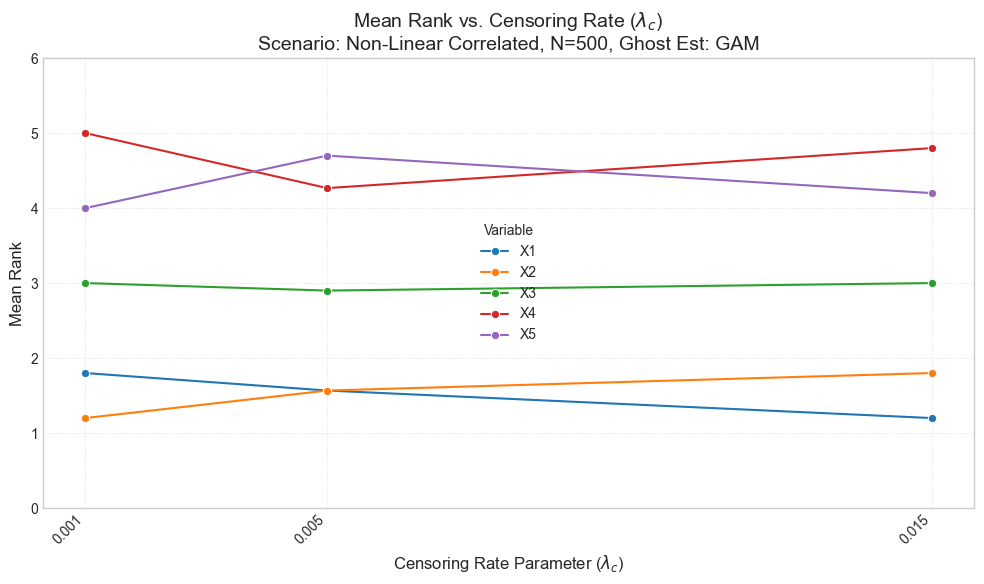


Full analysis script for comprehensive CSV complete.


In [ ]:
df_all_results = combined_df.copy()

base_scenario_col = 'base_scenario_type'
ghost_estimator_col = 'ghost_estimator_config'
variable_col = 'variable'
rvgh_mean_col = 'mean_RVgh'
rvgh_std_col = 'std_RVgh'
rank_mean_col = 'mean_Rank'
rank_std_col = 'std_Rank'
samples_col = 'samples' # For N
censoring_col = 'target_censoring_lambda' # For censoring lambda

# Verify essential columns exist
essential_cols = [base_scenario_col, ghost_estimator_col, variable_col,
                  rvgh_mean_col, rank_mean_col, samples_col, censoring_col]
missing_cols = [col for col in essential_cols if col not in df_all_results.columns]
if missing_cols:
    print(f"\nError: Missing one or more essential columns for analysis: {missing_cols}")
    print(f"Available columns: {df_all_results.columns.tolist()}")
    # exit()

# Ensure numeric types for metric columns
for col in [rvgh_mean_col, rvgh_std_col, rank_mean_col, rank_std_col, samples_col, censoring_col, 'c_index']:
    if col in df_all_results.columns:
        df_all_results[col] = pd.to_numeric(df_all_results[col], errors='coerce')

# --- Plotting Setup ---
SCENARIO_PLOT_NAMES = {
    'LinCorr': 'Linear Correlated', 'NonLinCorr': 'Non-Linear Correlated',
    'LinUncorr': 'Linear Uncorrelated', 'NonLinUncorr': 'Non-Linear Uncorrelated'
}
plt.style.use('seaborn-v0_8-whitegrid')
FONT_SIZE_LABEL = 12; FONT_SIZE_TITLE = 14; FONT_SIZE_TICKS = 10; FONT_SIZE_LEGEND = 10
plt.rcParams.update({
    'font.size': FONT_SIZE_LABEL, 'axes.labelsize': FONT_SIZE_LABEL,
    'axes.titlesize': FONT_SIZE_TITLE, 'xtick.labelsize': FONT_SIZE_TICKS,
    'ytick.labelsize': FONT_SIZE_TICKS, 'legend.fontsize': FONT_SIZE_LEGEND,
    'figure.dpi': 100
})
variable_order = sorted(df_all_results[variable_col].unique(), key=lambda x: (x[0] if isinstance(x, str) else '', int(x[1:]) if isinstance(x, str) and len(x) > 1 and x[1:].isdigit() else x))


# ==============================================================================
# Part 1: Analysis of "Impact of Ghost Estimator Choice"
# ==============================================================================
print("\n\n--- Analysis Part 1: Impact of Ghost Estimator Choice ---")
N_reference = 500 
lambda_reference = df_all_results[censoring_col].mode()[0] 

print(f"Filtering for Impact of Ghost Estimator study: N={N_reference}, Lambda={lambda_reference}")

df_ghost_impact = df_all_results[
    (df_all_results[samples_col] == N_reference) &
    (df_all_results[censoring_col] == lambda_reference)
].copy()

if not df_ghost_impact.empty:
    print("\nComparison Table for Ghost Estimator Impact (Filtered Data):")
    print(df_ghost_impact.sort_values(
        by=[base_scenario_col, variable_col, ghost_estimator_col]
    ).to_string())

    for base_scenario_name_internal in df_ghost_impact[base_scenario_col].unique():
        plot_data = df_ghost_impact[df_ghost_impact[base_scenario_col] == base_scenario_name_internal].copy()
        plot_data[variable_col] = pd.Categorical(plot_data[variable_col], categories=variable_order, ordered=True)
        plot_data.sort_values(variable_col, inplace=True)
        
        base_scenario_display_name = SCENARIO_PLOT_NAMES.get(base_scenario_name_internal, base_scenario_name_internal)

        # Plot Mean RVgh by Ghost Estimator
        plt.figure(figsize=(10, 6))
        ax_rvgh = sns.barplot(data=plot_data, x=variable_col, y=rvgh_mean_col, hue=ghost_estimator_col,
                              dodge=True, palette='viridis')
        plt.title(f'Mean $RV_{{gh}}$ by Ghost Estimator\nScenario: {base_scenario_display_name} (N={N_reference}, $\lambda_c$={lambda_reference})', fontsize=FONT_SIZE_TITLE)
        plt.ylabel(f'Mean $RV_{{gh}}$ Score', fontsize=FONT_SIZE_LABEL)
        plt.xlabel('Variable', fontsize=FONT_SIZE_LABEL)
        ax_rvgh.legend(title='Ghost Estimator', fontsize=FONT_SIZE_LEGEND, title_fontsize=FONT_SIZE_LEGEND)
        plt.grid(True, which='major', axis='y', linestyle=':', linewidth=0.6, alpha=0.7)
        plt.tight_layout()
        plt.savefig(f"rvgh_impact_ghost_est_{base_scenario_name_internal}_N{N_reference}_L{str(lambda_reference).replace('.','')}.png", dpi=300)
        plt.show()

        # Plot Mean Rank by Ghost Estimator
        plt.figure(figsize=(10, 6))
        ax_rank = sns.barplot(data=plot_data, x=variable_col, y=rank_mean_col, hue=ghost_estimator_col,
                              dodge=True, palette='viridis')
        plt.title(f'Mean Rank by Ghost Estimator\nScenario: {base_scenario_display_name} (N={N_reference}, $\lambda_c$={lambda_reference})', fontsize=FONT_SIZE_TITLE)
        plt.ylabel('Mean Rank', fontsize=FONT_SIZE_LABEL)
        plt.xlabel('Variable', fontsize=FONT_SIZE_LABEL)
        ax_rank.legend(title='Ghost Estimator', fontsize=FONT_SIZE_LEGEND, title_fontsize=FONT_SIZE_LEGEND)
        plt.grid(True, which='major', axis='y', linestyle=':', linewidth=0.6, alpha=0.7)
        ax_rank.set_ylim(0, len(variable_order) + 1)
        plt.tight_layout()
        plt.savefig(f"rank_impact_ghost_est_{base_scenario_name_internal}_N{N_reference}_L{str(lambda_reference).replace('.','')}.png", dpi=300)
        plt.show()
else:
    print(f"No data found for Impact of Ghost Estimator study with N={N_reference} and Lambda={lambda_reference}.")


# ==============================================================================
# Part 2: Analysis of "Sensitivity to Sample Size (N)"
# ==============================================================================
print("\n\n--- Analysis Part 2: Sensitivity to Sample Size (N) ---")
ghost_estimator_for_N_study = df_all_results[ghost_estimator_col].mode()[0] 
lambda_for_N_study = df_all_results[censoring_col].mode()[0] 
# lambda_for_N_study = 0.005 

print(f"Filtering for Sample Size study: GhostEstimator={ghost_estimator_for_N_study}, Lambda={lambda_for_N_study}")

df_sample_size_impact = df_all_results[
    (df_all_results[ghost_estimator_col] == ghost_estimator_for_N_study) &
    (df_all_results[censoring_col] == lambda_for_N_study)
].copy()

if not df_sample_size_impact.empty:
    print("\nAggregated Table for Sample Size Impact:")
    # Data is already aggregated per N, variable, etc
    print(df_sample_size_impact.sort_values(
        by=[base_scenario_col, samples_col, variable_col]
    ).to_string())

    for base_scenario_name_internal in df_sample_size_impact[base_scenario_col].unique():
        plot_data_N = df_sample_size_impact[df_sample_size_impact[base_scenario_col] == base_scenario_name_internal].copy()
        plot_data_N[variable_col] = pd.Categorical(plot_data_N[variable_col], categories=variable_order, ordered=True)
        
        base_scenario_display_name = SCENARIO_PLOT_NAMES.get(base_scenario_name_internal, base_scenario_name_internal)

        # Plot Mean RVgh vs Sample Size
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=plot_data_N, x=samples_col, y=rvgh_mean_col, hue=variable_col,
                     marker='o', palette='tab10', hue_order=variable_order, sort=False)
        plt.title(f'Mean $RV_{{gh}}$ vs. Sample Size (N)\nScenario: {base_scenario_display_name}, Ghost Est: {ghost_estimator_for_N_study}', fontsize=FONT_SIZE_TITLE)
        plt.xlabel('Sample Size (N)', fontsize=FONT_SIZE_LABEL)
        plt.ylabel(f'Mean $RV_{{gh}}$ Score', fontsize=FONT_SIZE_LABEL)
        plt.xticks(sorted(plot_data_N[samples_col].unique())) # Ensure all tested N values are ticks
        plt.legend(title='Variable', fontsize=FONT_SIZE_LEGEND, title_fontsize=FONT_SIZE_LEGEND)
        plt.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.7)
        plt.tight_layout()
        plt.savefig(f"rvgh_sensitivity_N_{base_scenario_name_internal}_{ghost_estimator_for_N_study}.png", dpi=300)
        plt.show()

        # Plot Mean Rank vs Sample Size
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=plot_data_N, x=samples_col, y=rank_mean_col, hue=variable_col,
                     marker='o', palette='tab10', hue_order=variable_order, sort=False)
        plt.title(f'Mean Rank vs. Sample Size (N)\nScenario: {base_scenario_display_name}, Ghost Est: {ghost_estimator_for_N_study}', fontsize=FONT_SIZE_TITLE)
        plt.xlabel('Sample Size (N)', fontsize=FONT_SIZE_LABEL)
        plt.ylabel('Mean Rank', fontsize=FONT_SIZE_LABEL)
        plt.xticks(sorted(plot_data_N[samples_col].unique()))
        plt.legend(title='Variable', fontsize=FONT_SIZE_LEGEND, title_fontsize=FONT_SIZE_LEGEND)
        plt.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.7)
        plt.ylim(0, len(variable_order) + 1)
        plt.tight_layout()
        plt.savefig(f"rank_sensitivity_N_{base_scenario_name_internal}_{ghost_estimator_for_N_study}.png", dpi=300)
        plt.show()
else:
    print(f"No data found for Sample Size study with GhostEstimator={ghost_estimator_for_N_study} and Lambda={lambda_for_N_study}.")


# ==============================================================================
# Part 3: Analysis of "Sensitivity to Censoring Rate"
# ==============================================================================
print("\n\n--- Analysis Part 3: Sensitivity to Censoring Rate ---")
ghost_estimator_for_cens_study = df_all_results[ghost_estimator_col].mode()[0]
N_for_cens_study = N_reference

print(f"Filtering for Censoring Rate study: GhostEstimator={ghost_estimator_for_cens_study}, N={N_for_cens_study}")

df_censoring_impact = df_all_results[
    (df_all_results[ghost_estimator_col] == ghost_estimator_for_cens_study) &
    (df_all_results[samples_col] == N_for_cens_study)
].copy()

if not df_censoring_impact.empty:
    print("\nAggregated Table for Censoring Impact:")
    print(df_censoring_impact.sort_values(
        by=[base_scenario_col, censoring_col, variable_col]
    ).to_string())
    

    for base_scenario_name_internal in df_censoring_impact[base_scenario_col].unique():
        plot_data_C = df_censoring_impact[df_censoring_impact[base_scenario_col] == base_scenario_name_internal].copy()
        plot_data_C[variable_col] = pd.Categorical(plot_data_C[variable_col], categories=variable_order, ordered=True)
        # Sort by lambda for line plot 
        plot_data_C.sort_values(censoring_col, inplace=True)


        base_scenario_display_name = SCENARIO_PLOT_NAMES.get(base_scenario_name_internal, base_scenario_name_internal)

        # Plot Mean RVgh vs Censoring Lambda
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=plot_data_C, x=censoring_col, y=rvgh_mean_col, hue=variable_col,
                     marker='o', palette='tab10', hue_order=variable_order, sort=False) # sort=False as we sorted by lambda
        plt.title(f'Mean $RV_{{gh}}$ vs. Censoring Rate ($\lambda_c$)\nScenario: {base_scenario_display_name}, N={N_for_cens_study}, Ghost Est: {ghost_estimator_for_cens_study}', fontsize=FONT_SIZE_TITLE)
        plt.xlabel('Censoring Rate Parameter ($\lambda_c$)', fontsize=FONT_SIZE_LABEL)
        plt.ylabel(f'Mean $RV_{{gh}}$ Score', fontsize=FONT_SIZE_LABEL)
        plt.xticks(sorted(plot_data_C[censoring_col].unique()), rotation=45, ha='right') # Ticks for actual lambdas
        plt.legend(title='Variable', fontsize=FONT_SIZE_LEGEND, title_fontsize=FONT_SIZE_LEGEND)
        plt.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.7)
        plt.tight_layout()
        plt.savefig(f"rvgh_sensitivity_cens_{base_scenario_name_internal}_{ghost_estimator_for_cens_study}_N{N_for_cens_study}.png", dpi=300)
        plt.show()

        # Plot Mean Rank vs Censoring Lambda
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=plot_data_C, x=censoring_col, y=rank_mean_col, hue=variable_col,
                     marker='o', palette='tab10', hue_order=variable_order, sort=False)
        plt.title(f'Mean Rank vs. Censoring Rate ($\lambda_c$)\nScenario: {base_scenario_display_name}, N={N_for_cens_study}, Ghost Est: {ghost_estimator_for_cens_study}', fontsize=FONT_SIZE_TITLE)
        plt.xlabel('Censoring Rate Parameter ($\lambda_c$)', fontsize=FONT_SIZE_LABEL)
        plt.ylabel('Mean Rank', fontsize=FONT_SIZE_LABEL)
        plt.xticks(sorted(plot_data_C[censoring_col].unique()), rotation=45, ha='right')
        plt.legend(title='Variable', fontsize=FONT_SIZE_LEGEND, title_fontsize=FONT_SIZE_LEGEND)
        plt.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.7)
        plt.ylim(0, len(variable_order) + 1)
        plt.tight_layout()
        plt.savefig(f"rank_sensitivity_cens_{base_scenario_name_internal}_{ghost_estimator_for_cens_study}_N{N_for_cens_study}.png", dpi=300)
        plt.show()
else:
    print(f"No data found for Censoring Rate study with GhostEstimator={ghost_estimator_for_cens_study} and N={N_for_cens_study}.")

print("\nFull analysis script for comprehensive CSV complete.")

### REAL DATA GERMAN BREAST CANCER

In [ ]:
from sksurv.datasets import load_gbsg2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
import numpy as np
from sksurv.metrics import concordance_index_censored

sksurv_available = True
try:
    from sksurv.util import Surv
    from sksurv.ensemble import RandomSurvivalForest
except ImportError:
    sksurv_available = False
    Surv = None
    RandomSurvivalForest = None
    print("Warning: scikit-survival not fully available, NonLinearSurvivalModel might not work.")

# --- Load Data ---
X_raw, y_raw = load_gbsg2()
X = X_raw.copy()

# --- Preprocessing on the full X DataFrame BEFORE splitting ---

# 1. Tumor grade ('tgrade'): Ordinal Encoding
print("\n--- Encoding 'tgrade' ---")
grade_categories = ['I', 'II', 'III'] 
                                      
if 'tgrade' in X.columns:
    print(f"Original 'tgrade' unique values: {X['tgrade'].unique()}, dtype: {X['tgrade'].dtype}")
    try:
        ordinal_encoder = OrdinalEncoder(categories=[grade_categories]) 
        X.loc[:, 'tgrade'] = ordinal_encoder.fit_transform(X[['tgrade']])
        print(f"Converted 'tgrade' unique values: {X['tgrade'].unique()}, dtype: {X['tgrade'].dtype}")
    except ValueError as e:
        print(f"Error encoding 'tgrade': {e}. Consider verifying categories: {X['tgrade'].unique()}")
else:
    print("'tgrade' column not found.")


# 2. Convert 'horTh' and 'menostat' to numeric (0/1) using mapping
print("\n--- Converting 'horTh' and 'menostat' to numeric 0/1 ---")

# For 'horTh':
if 'horTh' in X.columns:
    print(f"Original 'horTh' (dtype: {X['horTh'].dtype}) unique values: {X['horTh'].unique()}")
    horTh_map = {'yes': 1, 'no': 0}
    X.loc[:, 'horTh'] = X['horTh'].map(horTh_map).astype(np.int64)
    print(f"Converted 'horTh' (dtype: {X['horTh'].dtype}) unique values: {X['horTh'].unique()}")
else:
    print("'horTh' column not found.")

# For 'menostat':
if 'menostat' in X.columns:
    print(f"Original 'menostat' (dtype: {X['menostat'].dtype}) unique values: {X['menostat'].unique()}")
    menostat_map = {'Pre': 0, 'Post': 1} # Explicitly 'Pre' -> 0, 'Post' -> 1
    X.loc[:, 'menostat'] = X['menostat'].map(menostat_map).astype(np.int64)
    print(f"Converted 'menostat' (dtype: {X['menostat'].dtype}) unique values: {X['menostat'].unique()}")
else:
    print("'menostat' column not found.")

# --- End of Preprocessing on X ---

print("\nData types in X after all initial preprocessing (should be all numeric or float/int):")
X.info()


# --- Split Data ---
y_structured_sksurv_format = y_raw

X_train, X_test, y_train_sksurv, y_test_sksurv = train_test_split(
    X, y_structured_sksurv_format, test_size=0.25, random_state=42, stratify=y_structured_sksurv_format['cens']
)

# --- Transform y_train/y_test to ('event', 'time') for NonLinearSurvivalModel class ---
y_train_transformed = np.array(
    [(status, time_val) for status, time_val in zip(y_train_sksurv['cens'], y_train_sksurv['time'])],
    dtype=[('event', bool), ('time', float)]
)
y_test_transformed = np.array(
    [(status, time_val) for status, time_val in zip(y_test_sksurv['cens'], y_test_sksurv['time'])],
    dtype=[('event', bool), ('time', float)]
)

print("\nData types in X_train (input to model.fit):")
X_train.info()


# --- Instantiate and Train Model ---
rsf_model = NonLinearSurvivalModel(model_type='rsf', random_state=42)
print("\nFitting the Random Survival Forest model...")
rsf_model.fit(X_train, y_train_transformed)
print("Model fitting complete.")


# --- Predict Risk Scores (f_X_test) ---
print("\nPredicting risk scores on the test set...")
f_X_test = None
try:
    f_X_test = rsf_model.predict_risk_score(X_test)
    print("Risk scores (f_X_test) obtained. Shape:", f_X_test.shape)
except Exception as e:
    print(f"An error occurred during risk score prediction: {e}")
    import traceback
    print(traceback.format_exc())


# --- Calculate C-index using predicted risk scores ---
c_index_test_val = None
if f_X_test is not None:
    try:
        c_index_tuple = concordance_index_censored(
            y_test_transformed['event'],
            y_test_transformed['time'],
            f_X_test
        )
        c_index_test_val = c_index_tuple[0]
        print(f"C-index on GBSG2 test set (calculated manually): {c_index_test_val:.4f}")
    except Exception as e:
        print(f"Could not calculate C-index: {e}")
else:
    print("Cannot calculate C-index because risk scores (f_X_test) were not obtained.")


# --- Proceed with GhostCox if f_X_test is available ---
if f_X_test is not None:
    print("\n--- GhostCox Analysis (Conceptual Next Steps) ---")
    # (Your GhostCox code here)
    pass
else:
    print("\nCannot proceed with GhostCox as f_X_test could not be obtained.")


--- Encoding 'tgrade' ---
Original 'tgrade' unique values: ['II', 'III', 'I']
Categories (3, object): ['I', 'II', 'III'], dtype: category
Converted 'tgrade' unique values: [1. 2. 0.], dtype: float64

--- Converting 'horTh' and 'menostat' to numeric 0/1 ---
Original 'horTh' (dtype: category) unique values: ['no', 'yes']
Categories (2, object): ['no', 'yes']
Converted 'horTh' (dtype: int64) unique values: [0 1]
Original 'menostat' (dtype: category) unique values: ['Post', 'Pre']
Categories (2, object): ['Pre', 'Post']
Converted 'menostat' (dtype: int64) unique values: [1 0]

Data types in X after all initial preprocessing (should be all numeric or float/int):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       686 non-null    float64
 1   estrec    686 non-null    float64
 2   horTh     686 non-null    int64  
 3   menostat  686 non-null    int

C:\Users\sanisaza\AppData\Local\Temp\4\ipykernel_12564\2301606965.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 0. 1. 0. 0. 1. 1. 2. 1.
 2. 1. 2. 1. 1. 1. 2. 2. 2. 0. 1. 1. 1. 0. 1. 1. 2. 1. 2. 1. 1. 0. 1. 2.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1.
 1. 1. 1. 1. 1. 1. 2. 1. 1. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 2. 1. 2. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 2.
 1. 1. 1. 2. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 0. 1.
 1. 2. 1. 1. 1. 0. 1. 1. 1. 2. 1. 1. 1. 2. 2. 1. 2. 0. 1. 2. 0. 1. 2. 1.
 1. 2. 2. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 2. 2. 2. 1. 2. 1. 2.
 2. 1. 1. 1. 2. 1. 1. 1. 1. 0. 0. 1. 2. 2. 2. 1. 1. 1. 1. 0. 0. 1. 2. 0.
 2. 1. 1. 2. 1. 1. 1. 1. 1. 0. 2. 1. 2. 1. 1. 2. 1. 2. 2. 1. 1. 1. 1. 1.
 1. 1. 2. 2. 0. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 2. 1. 1. 1. 1.
 1. 1.

## RSF

In [ ]:
import pandas as pd # Ensure pandas is imported
import numpy as np  # Ensure numpy is imported

# --- GhostCox Analysis: Step 3 - Calculating Relevance ---
rv_gh_scores_df = None
V_matrix_df = None

if ghost_cox_interpreter is not None:
    print("\n--- GhostCox Analysis: Step 3 - Calculating Relevance ---")
    try:
        rv_gh_scores_df, V_matrix_df = ghost_cox_interpreter.calculate_relevance(
            X_test=X_test,
            calculate_relevance_matrix=True
        )
        
        print("\nGhostCox RV_gh Scores DataFrame:")
        if rv_gh_scores_df is not None and not rv_gh_scores_df.empty:
            print(rv_gh_scores_df)
        else:
            print("  No RV_gh scores were calculated or the DataFrame is empty.")

        print("\nGhostCox Relevance Matrix V:")
        if V_matrix_df is not None and not V_matrix_df.empty:
            print(V_matrix_df)

            print("\n--- Eigenvalue Decomposition of Relevance Matrix V ---")
            try:
                # Ensure V_matrix_df is a NumPy array for eigenvalue decomposition
                # and that it's square and numeric.
                if not V_matrix_df.empty and V_matrix_df.shape[0] == V_matrix_df.shape[1]:
                    V_numpy = V_matrix_df.to_numpy()
                    
                    eigenvalues, eigenvectors = np.linalg.eigh(V_numpy)

                    # Sort eigenvalues and corresponding eigenvectors in descending order
                    sorted_indices = np.argsort(eigenvalues)[::-1]
                    sorted_eigenvalues = eigenvalues[sorted_indices]
                    sorted_eigenvectors = eigenvectors[:, sorted_indices]

                    print("\nSorted Eigenvalues of V:")
                    for i, eigval in enumerate(sorted_eigenvalues):
                        print(f"  Lambda_{i+1}: {eigval:.4f}")

                    # Calculate and print explained "variance" (sum of eigenvalues as total variance)
                    total_eigenvalue_sum = np.sum(sorted_eigenvalues)
                    if total_eigenvalue_sum > np.finfo(float).eps: # Avoid division by zero
                        explained_variance_ratio = sorted_eigenvalues / total_eigenvalue_sum
                        cumulative_explained_variance = np.cumsum(explained_variance_ratio)
                        print("\nExplained Variance by Eigenvectors:")
                        for i, ratio in enumerate(explained_variance_ratio):
                            print(f"  EigVec_{i+1}: {ratio*100:.2f}% (Cumulative: {cumulative_explained_variance[i]*100:.2f}%)")
                    
                    print("\nPrincipal Eigenvectors of V (columns are eigenvectors):")
                    # Create a DataFrame for better readability of eigenvectors
                    # Rows are original variables, columns are eigenvectors
                    eigenvectors_df = pd.DataFrame(
                        sorted_eigenvectors,
                        index=V_matrix_df.index, # Variable names
                        columns=[f"EigVec_{i+1}" for i in range(sorted_eigenvectors.shape[1])]
                    )
                    # Print the first few eigenvectors that explain most variance
                    num_eigvec_to_print = min(len(V_matrix_df.columns), 5) # Print up to 5 or total number
                    print(eigenvectors_df.iloc[:, :num_eigvec_to_print])

                else:
                    print("  V_matrix_df is empty or not square. Cannot perform eigenvalue decomposition.")

            except Exception as e_eig:
                print(f"  Error during eigenvalue decomposition: {e_eig}")
                import traceback
                print(traceback.format_exc())
            # --- END OF EIGENVALUE DECOMPOSITION ---

        else:
            print("  Relevance Matrix V was not calculated or is empty.")

    except Exception as e:
        print(f"Error during GhostCox calculate_relevance: {e}")
        import traceback
        print(traceback.format_exc())
else:
    print("Skipping GhostCox relevance calculation because GhostCoxInterpreter was not instantiated or previous steps failed.")

## LM

In [ ]:
import pandas as pd 
import numpy as np  
# --- Configuration for this specific run ---

current_ghost_estimator_type = 'lm' # lm, gam, rf

print(f"\n\n--- GhostCox Analysis: Using {current_ghost_estimator_type.upper()} for GhostVariableEstimator ---")

# 1. Instantiate GhostVariableEstimator
ghost_estimator_current = GhostVariableEstimator(estimator_type=current_ghost_estimator_type, n_jobs=1)


# 2. Instantiate GhostCoxInterpreter
ghost_cox_interpreter_current = None
if rsf_model and rsf_model.is_fitted and ghost_estimator_current:
    print(f"\n--- Instantiating GhostCoxInterpreter with {current_ghost_estimator_type.upper()}-based Ghost Estimator ---")
    try:
        ghost_cox_interpreter_current = GhostCoxInterpreter(
            survival_model=rsf_model, 
            ghost_estimator=ghost_estimator_current
        )
        print(f"GhostCoxInterpreter (for {current_ghost_estimator_type.upper()} ghosts) instantiated successfully.")
    except Exception as e:
        print(f"Error instantiating GhostCoxInterpreter (for {current_ghost_estimator_type.upper()} ghosts): {e}")
        import traceback
        print(traceback.format_exc())
else:
    print(f"Skipping GhostCoxInterpreter (for {current_ghost_estimator_type.upper()} ghosts) instantiation due to previous errors or unfitted models.")

# 3. Calculate Relevance Scores and Matrix
rv_gh_scores_df_current = None
V_matrix_df_current = None

if ghost_cox_interpreter_current is not None:
    print(f"\n--- Calculating Relevance with {current_ghost_estimator_type.upper()}-based Ghosts ---")
    try:
        rv_gh_scores_df_current, V_matrix_df_current = ghost_cox_interpreter_current.calculate_relevance(
            X_test=X_test,
            calculate_relevance_matrix=True 
        )
        
        print(f"\nGhostCox RV_gh Scores (using {current_ghost_estimator_type.upper()} for ghosts):")
        if rv_gh_scores_df_current is not None and not rv_gh_scores_df_current.empty:
            print(rv_gh_scores_df_current)
        else:
            print(f"  No RV_gh scores were calculated or the DataFrame is empty ({current_ghost_estimator_type.upper()} ghosts).")

        print(f"\nGhostCox Relevance Matrix V (using {current_ghost_estimator_type.upper()} for ghosts):")
        if V_matrix_df_current is not None and not V_matrix_df_current.empty:
            print(V_matrix_df_current)

            # --- EIGENVALUE DECOMPOSITION OF V_matrix_df_current ---
            print(f"\n--- Eigenvalue Decomposition of Relevance Matrix V (Ghosts: {current_ghost_estimator_type.upper()}) ---")
            try:
                if not V_matrix_df_current.empty and V_matrix_df_current.shape[0] == V_matrix_df_current.shape[1]:
                    V_numpy = V_matrix_df_current.to_numpy()
                    
                    eigenvalues, eigenvectors = np.linalg.eigh(V_numpy)

                    sorted_indices = np.argsort(eigenvalues)[::-1]
                    sorted_eigenvalues = eigenvalues[sorted_indices]
                    sorted_eigenvectors = eigenvectors[:, sorted_indices]

                    print("\nSorted Eigenvalues of V:")
                    for i, eigval in enumerate(sorted_eigenvalues):
                        print(f"  Lambda_{i+1}: {eigval:.4f}")

                    total_eigenvalue_sum = np.sum(sorted_eigenvalues)
                    if total_eigenvalue_sum > np.finfo(float).eps:
                        explained_variance_ratio = sorted_eigenvalues / total_eigenvalue_sum
                        cumulative_explained_variance = np.cumsum(explained_variance_ratio)
                        print("\nExplained 'Variance' by Eigenvectors (Proportion of sum of eigenvalues):")
                        for i, ratio in enumerate(explained_variance_ratio):
                            print(f"  EigVec_{i+1}: {ratio*100:.2f}% (Cumulative: {cumulative_explained_variance[i]*100:.2f}%)")
                    
                    print("\nPrincipal Eigenvectors of V (columns are eigenvectors):")
                    eigenvectors_df = pd.DataFrame(
                        sorted_eigenvectors,
                        index=V_matrix_df_current.index, 
                        columns=[f"EigVec_{i+1}" for i in range(sorted_eigenvectors.shape[1])]
                    )
                    num_eigvec_to_print = min(len(V_matrix_df_current.columns), 5)
                    print(eigenvectors_df.iloc[:, :num_eigvec_to_print])
                else:
                    print("  V_matrix_df is empty or not square. Cannot perform eigenvalue decomposition.")
            except Exception as e_eig:
                print(f"  Error during eigenvalue decomposition: {e_eig}")
                import traceback
                print(traceback.format_exc())
            # --- END OF EIGENVALUE DECOMPOSITION ---
        else:
            print(f"  Relevance Matrix V was not calculated or is empty ({current_ghost_estimator_type.upper()} ghosts).")
    except Exception as e:
        print(f"Error during GhostCox calculate_relevance ({current_ghost_estimator_type.upper()} ghosts): {e}")
        import traceback
        print(traceback.format_exc())
else:
    print(f"Skipping GhostCox relevance calculation ({current_ghost_estimator_type.upper()} ghosts) due to errors or unfitted models.")
 



--- GhostCox Analysis: Using LM for GhostVariableEstimator ---
Initialized GhostVariableEstimator with LM (params: {'n_jobs': None}, requested n_jobs=1)

--- Instantiating GhostCoxInterpreter with LM-based Ghost Estimator ---
Initialized GhostCoxInterpreter.
GhostCoxInterpreter (for LM ghosts) instantiated successfully.

--- Calculating Relevance with LM-based Ghosts ---

Calculating Ghost Variable Relevance...

Estimating all ghost variables using LM...
Ghost variable estimation complete. Successfully estimated for 8 out of 8 variables.
Normalization factor Var(f_test): 1878.2564
Relevance calculation complete.

GhostCox RV_gh Scores (using LM for ghosts):
          RV_gh_numerator     RV_gh  Rank
pnodes         714.882200  0.380609     1
progrec        479.344525  0.255207     2
estrec         106.509316  0.056706     3
age             99.602702  0.053029     4
horTh           72.277927  0.038481     5
tsize           69.196634  0.036841     6
tgrade          31.950882  0.017011   

In [ ]:
import pandas as pd 
import numpy as np  

# --- Configuration for this specific run ---

current_ghost_estimator_type = 'gam' 

print(f"\n\n--- GhostCox Analysis: Using {current_ghost_estimator_type.upper()} for GhostVariableEstimator ---")

# 1. Instantiate GhostVariableEstimator
ghost_estimator_current = GhostVariableEstimator(estimator_type=current_ghost_estimator_type, n_jobs=1)


# 2. Instantiate GhostCoxInterpreter
ghost_cox_interpreter_current = None
if rsf_model and rsf_model.is_fitted and ghost_estimator_current:
    print(f"\n--- Instantiating GhostCoxInterpreter with {current_ghost_estimator_type.upper()}-based Ghost Estimator ---")
    try:
        ghost_cox_interpreter_current = GhostCoxInterpreter(
            survival_model=rsf_model, 
            ghost_estimator=ghost_estimator_current
        )
        print(f"GhostCoxInterpreter (for {current_ghost_estimator_type.upper()} ghosts) instantiated successfully.")
    except Exception as e:
        print(f"Error instantiating GhostCoxInterpreter (for {current_ghost_estimator_type.upper()} ghosts): {e}")
        import traceback
        print(traceback.format_exc())
else:
    print(f"Skipping GhostCoxInterpreter (for {current_ghost_estimator_type.upper()} ghosts) instantiation due to previous errors or unfitted models.")

# 3. Calculate Relevance Scores and Matrix
rv_gh_scores_df_current = None
V_matrix_df_current = None

if ghost_cox_interpreter_current is not None:
    print(f"\n--- Calculating Relevance with {current_ghost_estimator_type.upper()}-based Ghosts ---")
    try:
        rv_gh_scores_df_current, V_matrix_df_current = ghost_cox_interpreter_current.calculate_relevance(
            X_test=X_test,
            calculate_relevance_matrix=True 
        )
        
        print(f"\nGhostCox RV_gh Scores (using {current_ghost_estimator_type.upper()} for ghosts):")
        if rv_gh_scores_df_current is not None and not rv_gh_scores_df_current.empty:
            print(rv_gh_scores_df_current)
        else:
            print(f"  No RV_gh scores were calculated or the DataFrame is empty ({current_ghost_estimator_type.upper()} ghosts).")

        print(f"\nGhostCox Relevance Matrix V (using {current_ghost_estimator_type.upper()} for ghosts):")
        if V_matrix_df_current is not None and not V_matrix_df_current.empty:
            print(V_matrix_df_current)

            # --- EIGENVALUE DECOMPOSITION OF V_matrix_df_current ---
            print(f"\n--- Eigenvalue Decomposition of Relevance Matrix V (Ghosts: {current_ghost_estimator_type.upper()}) ---")
            try:
                if not V_matrix_df_current.empty and V_matrix_df_current.shape[0] == V_matrix_df_current.shape[1]:
                    V_numpy = V_matrix_df_current.to_numpy()
                    
                    eigenvalues, eigenvectors = np.linalg.eigh(V_numpy)

                    sorted_indices = np.argsort(eigenvalues)[::-1]
                    sorted_eigenvalues = eigenvalues[sorted_indices]
                    sorted_eigenvectors = eigenvectors[:, sorted_indices]

                    print("\nSorted Eigenvalues of V:")
                    for i, eigval in enumerate(sorted_eigenvalues):
                        print(f"  Lambda_{i+1}: {eigval:.4f}")

                    total_eigenvalue_sum = np.sum(sorted_eigenvalues)
                    if total_eigenvalue_sum > np.finfo(float).eps:
                        explained_variance_ratio = sorted_eigenvalues / total_eigenvalue_sum
                        cumulative_explained_variance = np.cumsum(explained_variance_ratio)
                        print("\nExplained 'Variance' by Eigenvectors (Proportion of sum of eigenvalues):")
                        for i, ratio in enumerate(explained_variance_ratio):
                            print(f"  EigVec_{i+1}: {ratio*100:.2f}% (Cumulative: {cumulative_explained_variance[i]*100:.2f}%)")
                    
                    print("\nPrincipal Eigenvectors of V (columns are eigenvectors):")
                    eigenvectors_df = pd.DataFrame(
                        sorted_eigenvectors,
                        index=V_matrix_df_current.index, 
                        columns=[f"EigVec_{i+1}" for i in range(sorted_eigenvectors.shape[1])]
                    )
                    num_eigvec_to_print = min(len(V_matrix_df_current.columns), 5)
                    print(eigenvectors_df.iloc[:, :num_eigvec_to_print])
                else:
                    print("  V_matrix_df is empty or not square. Cannot perform eigenvalue decomposition.")
            except Exception as e_eig:
                print(f"  Error during eigenvalue decomposition: {e_eig}")
                import traceback
                print(traceback.format_exc())
            # --- END OF EIGENVALUE DECOMPOSITION ---
        else:
            print(f"  Relevance Matrix V was not calculated or is empty ({current_ghost_estimator_type.upper()} ghosts).")
    except Exception as e:
        print(f"Error during GhostCox calculate_relevance ({current_ghost_estimator_type.upper()} ghosts): {e}")
        import traceback
        print(traceback.format_exc())
else:
    print(f"Skipping GhostCox relevance calculation ({current_ghost_estimator_type.upper()} ghosts) due to errors or unfitted models.")



--- GhostCox Analysis: Using GAM for GhostVariableEstimator ---
Initialized GhostVariableEstimator with GAM (params: {'n_splines': 10, 'max_iter': 100, 'tol': 0.001}, requested n_jobs=1)

--- Instantiating GhostCoxInterpreter with GAM-based Ghost Estimator ---
Initialized GhostCoxInterpreter.
GhostCoxInterpreter (for GAM ghosts) instantiated successfully.

--- Calculating Relevance with GAM-based Ghosts ---

Calculating Ghost Variable Relevance...

Estimating all ghost variables using GAM...
Ghost variable estimation complete. Successfully estimated for 8 out of 8 variables.
Normalization factor Var(f_test): 1878.2564
Relevance calculation complete.

GhostCox RV_gh Scores (using GAM for ghosts):
          RV_gh_numerator     RV_gh  Rank
pnodes         623.316731  0.331859     1
progrec        475.073692  0.252933     2
estrec         100.802512  0.053668     3
tsize           77.594818  0.041312     4
age             75.675746  0.040290     5
horTh           72.277927  0.038481     6

In [ ]:
import pandas as pd
import numpy as np


# --- Initialize Dictionaries to Store Results from ALL Ghost Estimator Types ---

if 'all_rv_gh_scores_dfs' not in locals(): # Initialize only if they don't exist
    all_rv_gh_scores_dfs = {}
    all_V_matrix_dfs = {}
    all_eigenvalues_V = {}
    all_eigenvectors_V_dfs = {}
    print("Initialized dictionaries for storing GhostCox results.")
# --- End of Initialization ---

# --- Configuration for the CURRENT specific run ---

current_ghost_estimator_type = 'lm' 

print(f"\n\n--- GhostCox Analysis: Using {current_ghost_estimator_type.upper()} for GhostVariableEstimator ---")

# 1. Instantiate GhostVariableEstimator
ghost_estimator_current = GhostVariableEstimator(estimator_type=current_ghost_estimator_type, n_jobs=1)

# 2. Instantiate GhostCoxInterpreter

ghost_cox_interpreter_current = None
if 'rsf_model' in globals() and rsf_model and hasattr(rsf_model, 'is_fitted') and rsf_model.is_fitted and ghost_estimator_current:
    print(f"\n--- Instantiating GhostCoxInterpreter with {current_ghost_estimator_type.upper()}-based Ghost Estimator ---")
    try:
        ghost_cox_interpreter_current = GhostCoxInterpreter(
            survival_model=rsf_model, 
            ghost_estimator=ghost_estimator_current
        )
        print(f"GhostCoxInterpreter (for {current_ghost_estimator_type.upper()} ghosts) instantiated successfully.")
    except Exception as e:
        print(f"Error instantiating GhostCoxInterpreter (for {current_ghost_estimator_type.upper()} ghosts): {e}")
        import traceback
        print(traceback.format_exc())
else:
    print(f"Skipping GhostCoxInterpreter: Ensure 'rsf_model' is fitted and 'ghost_estimator_current' is initialized.")

# 3. Calculate Relevance Scores and Matrix
rv_gh_scores_df_for_this_run = None
V_matrix_df_for_this_run = None

if ghost_cox_interpreter_current is not None:
    print(f"\n--- Calculating Relevance with {current_ghost_estimator_type.upper()}-based Ghosts ---")
    try:
        if 'X_test' not in globals():
            raise NameError("X_test is not defined. Please ensure your GBSG2 test data is loaded.")

        rv_gh_scores_df_for_this_run, V_matrix_df_for_this_run = ghost_cox_interpreter_current.calculate_relevance(
            X_test=X_test,
            calculate_relevance_matrix=True 
        )
        
        print(f"\nGhostCox RV_gh Scores (using {current_ghost_estimator_type.upper()} for ghosts):")
        if rv_gh_scores_df_for_this_run is not None and not rv_gh_scores_df_for_this_run.empty:
            print(rv_gh_scores_df_for_this_run)
            all_rv_gh_scores_dfs[current_ghost_estimator_type] = rv_gh_scores_df_for_this_run.copy()
        else:
            print(f"  No RV_gh scores were calculated or the DataFrame is empty ({current_ghost_estimator_type.upper()} ghosts).")
            all_rv_gh_scores_dfs[current_ghost_estimator_type] = pd.DataFrame() # Store empty df

        print(f"\nGhostCox Relevance Matrix V (using {current_ghost_estimator_type.upper()} for ghosts):")
        if V_matrix_df_for_this_run is not None and not V_matrix_df_for_this_run.empty:
            print(V_matrix_df_for_this_run)
            all_V_matrix_dfs[current_ghost_estimator_type] = V_matrix_df_for_this_run.copy()

            # --- EIGENVALUE DECOMPOSITION ---
            print(f"\n--- Eigenvalue Decomposition of Relevance Matrix V (Ghosts: {current_ghost_estimator_type.upper()}) ---")
            try:
                if not V_matrix_df_for_this_run.empty and V_matrix_df_for_this_run.shape[0] == V_matrix_df_for_this_run.shape[1]:
                    V_numpy = V_matrix_df_for_this_run.to_numpy()
                    eigenvalues, eigenvectors = np.linalg.eigh(V_numpy)

                    sorted_indices = np.argsort(eigenvalues)[::-1]
                    sorted_eigenvalues = eigenvalues[sorted_indices]
                    sorted_eigenvectors = eigenvectors[:, sorted_indices]
                    
                    all_eigenvalues_V[current_ghost_estimator_type] = sorted_eigenvalues # Store

                    print("\nSorted Eigenvalues of V:")
                    for i, eigval in enumerate(sorted_eigenvalues): print(f"  Lambda_{i+1}: {eigval:.4f}")

                    total_eigenvalue_sum = np.sum(sorted_eigenvalues)
                    if total_eigenvalue_sum > np.finfo(float).eps:
                        explained_variance_ratio = sorted_eigenvalues / total_eigenvalue_sum
                        cumulative_explained_variance = np.cumsum(explained_variance_ratio)
                        print("\nExplained 'Variance' by Eigenvectors (Proportion of sum of eigenvalues):")
                        for i, ratio in enumerate(explained_variance_ratio): print(f"  EigVec_{i+1}: {ratio*100:.2f}% (Cumulative: {cumulative_explained_variance[i]*100:.2f}%)")
                    
                    eigenvectors_df_this_run = pd.DataFrame(sorted_eigenvectors, index=V_matrix_df_for_this_run.index, 
                                                           columns=[f"EigVec_{i+1}" for i in range(sorted_eigenvectors.shape[1])])
                    all_eigenvectors_V_dfs[current_ghost_estimator_type] = eigenvectors_df_this_run # Store
                    
                    print("\nPrincipal Eigenvectors of V (columns are eigenvectors):")
                    num_eigvec_to_print = min(len(V_matrix_df_for_this_run.columns), 5)
                    print(eigenvectors_df_this_run.iloc[:, :num_eigvec_to_print])
                else:
                    print("  V_matrix_df is empty or not square. Cannot perform eigenvalue decomposition.")
                    all_eigenvalues_V[current_ghost_estimator_type] = np.array([])
                    all_eigenvectors_V_dfs[current_ghost_estimator_type] = pd.DataFrame()
            except Exception as e_eig:
                print(f"  Error during eigenvalue decomposition: {e_eig}")
                all_eigenvalues_V[current_ghost_estimator_type] = np.array([])
                all_eigenvectors_V_dfs[current_ghost_estimator_type] = pd.DataFrame()
                import traceback
                print(traceback.format_exc())
        else:
            print(f"  Relevance Matrix V was not calculated or is empty ({current_ghost_estimator_type.upper()} ghosts).")
            all_V_matrix_dfs[current_ghost_estimator_type] = pd.DataFrame()
            all_eigenvalues_V[current_ghost_estimator_type] = np.array([])
            all_eigenvectors_V_dfs[current_ghost_estimator_type] = pd.DataFrame()
    except Exception as e_calc:
        print(f"Error during GhostCox calculate_relevance ({current_ghost_estimator_type.upper()} ghosts): {e_calc}")
        all_rv_gh_scores_dfs[current_ghost_estimator_type] = pd.DataFrame()
        all_V_matrix_dfs[current_ghost_estimator_type] = pd.DataFrame()
        all_eigenvalues_V[current_ghost_estimator_type] = np.array([])
        all_eigenvectors_V_dfs[current_ghost_estimator_type] = pd.DataFrame()
        import traceback
        print(traceback.format_exc())
else:
    print(f"Skipping GhostCox relevance calculation ({current_ghost_estimator_type.upper()} ghosts) due to errors or unfitted models.")

# After running this block for 'rf', then for 'gam', then for 'lm':
# Results will be stored in the dictionaries:
# - all_rv_gh_scores_dfs['rf'], all_rv_gh_scores_dfs['gam'], all_rv_gh_scores_dfs['lm']
# - all_V_matrix_dfs['rf'], all_V_matrix_dfs['gam'], all_V_matrix_dfs['lm']
# - all_eigenvalues_V['rf'], all_eigenvalues_V['gam'], all_eigenvalues_V['lm']
# - all_eigenvectors_V_dfs['rf'], all_eigenvectors_V_dfs['gam'], all_eigenvectors_V_dfs['lm']



--- GhostCox Analysis: Using LM for GhostVariableEstimator ---
Initialized GhostVariableEstimator with LM (params: {'n_jobs': None}, requested n_jobs=1)

--- Instantiating GhostCoxInterpreter with LM-based Ghost Estimator ---
Initialized GhostCoxInterpreter.
GhostCoxInterpreter (for LM ghosts) instantiated successfully.

--- Calculating Relevance with LM-based Ghosts ---

Calculating Ghost Variable Relevance...

Estimating all ghost variables using LM...
Ghost variable estimation complete. Successfully estimated for 8 out of 8 variables.
Normalization factor Var(f_test): 1878.2564
Relevance calculation complete.

GhostCox RV_gh Scores (using LM for ghosts):
          RV_gh_numerator     RV_gh  Rank
pnodes         714.882200  0.380609     1
progrec        479.344525  0.255207     2
estrec         106.509316  0.056706     3
age             99.602702  0.053029     4
horTh           72.277927  0.038481     5
tsize           69.196634  0.036841     6
tgrade          31.950882  0.017011   

In [ ]:
import pandas as pd
import numpy as np
from functools import partial
from sksurv.metrics import concordance_index_censored
from sklearn.preprocessing import StandardScaler
import warnings # To manage warnings if needed

# --- Ensure pyhrt is importable & correct FDR function ---
try:
    from pyhrt.hrt import hrt as hrt_func 
    from pyhrt.utils import bh_predictions
    print("Successfully imported HRT components from pyhrt.")
    hrt_is_available = True
except ImportError as e:
    print(f"Error importing from pyhrt: {e}. HRT analysis cannot proceed.")
    hrt_is_available = False


# --- Test Statistic Function for HRT (using C-Index Loss) ---
def c_index_loss_for_hrt(X_test_perturbed_np: np.ndarray, 
                         feature_names_list: list, 
                         fixed_rsf_model: 'NonLinearSurvivalModel', 
                         fixed_y_test_sksurv: np.ndarray) -> float:
    """
    Test statistic for HRT: 1.0 - C-Index (lower is better).
    """
    X_test_perturbed_df = pd.DataFrame(X_test_perturbed_np, columns=feature_names_list)
    
    try:
        risk_scores = fixed_rsf_model.predict_risk_score(X_test_perturbed_df)
        event_indicator = fixed_y_test_sksurv['event'].astype(bool)
        event_time = fixed_y_test_sksurv['time']
        
        c_index_val, _, _, _, _ = concordance_index_censored(
            event_indicator, 
            event_time, 
            risk_scores
        )
        if np.isnan(c_index_val):
            return 1.0 # Max loss for NaN C-index (worst outcome)
        return 1.0 - c_index_val
    except Exception as e:
        # warnings.warn(f"C-index calculation failed during HRT tstat_fn: {e}") 
        return 1.0 # Max loss if C-index calculation fails

# --- HRT Analysis Section ---

print("Applying StandardScaler to copies of X_train and X_test for HRT input...")
scaler_for_hrt = StandardScaler()

X_train_for_hrt_scaled = X_train.copy()
X_test_for_hrt_scaled = X_test.copy()
# Fit scaler on X_train and transform
X_train_for_hrt_scaled[feature_names] = scaler_for_hrt.fit_transform(X_train[feature_names])
X_test_for_hrt_scaled[feature_names] = scaler_for_hrt.transform(X_test[feature_names])

X_train_np = X_train_for_hrt_scaled.to_numpy() # Use scaled data
X_test_np = X_test_for_hrt_scaled.to_numpy()   # Use scaled data

# --- End of Pre-scaling Step --
hrt_p_values_gbsg2 = {}
hrt_results_summary_df_gbsg2 = None 

if hrt_is_available:
    if 'X_train' not in globals() or not isinstance(X_train, pd.DataFrame) or \
       'X_test' not in globals() or not isinstance(X_test, pd.DataFrame) or \
       'y_test_transformed' not in globals() or not isinstance(y_test_transformed, np.ndarray) or \
       'rsf_model' not in globals() or rsf_model is None: # Add more checks if needed
        print("HRT SKIPPED: Ensure X_train, X_test, y_test_transformed, and rsf_model are defined and valid.")
    else:
        print("\n--- Holdout Randomization Test (HRT) Analysis for GBSG2 ---")

        feature_names = list(X_train.columns)


        hrt_p_values_gbsg2 = {}
        
        # HRT parameters 
        n_hrt_permutations = 5000 
        n_hrt_bootstraps = 20
        n_hrt_folds = 5          
        verbose_hrt_run = True  # Set to True for more detailed HRT output during calibration

        #print(f"Starting HRT analysis for {len(feature_names)} features (target permutations: {n_hrt_permutations if n_hrt_permutations else 'default'})...")

        for feature_idx, feature_name in enumerate(feature_names):
            print(f"  Running HRT for feature: {feature_name} ({feature_idx + 1}/{len(feature_names)})")
            
            # The tstat_fn is called by hrt with X_null (perturbed X_test_np)
            current_tstat_fn = partial(c_index_loss_for_hrt,
                                       feature_names_list=feature_names,
                                       fixed_rsf_model=rsf_model,
                                       fixed_y_test_sksurv=y_test_transformed)
            try:
                # Call specific hrt function
                hrt_output_dict = hrt_func( 
                    feature=feature_idx,      
                    tstat_fn=current_tstat_fn,
                    X=X_train_np, # Data to train P(X_j|X_-j)
                    X_test=X_test_np, # Data to perturb and evaluate tstat_fn on
                    nperms=n_hrt_permutations, 
                    nbootstraps=n_hrt_bootstraps,
                    nfolds=n_hrt_folds,
                    verbose=verbose_hrt_run
                )
                p_value = hrt_output_dict.get('p_value', np.nan)
            except Exception as e_hrt:
                print(f"    ERROR running HRT for {feature_name}: {e_hrt}")
                p_value = np.nan
                import traceback
                print(traceback.format_exc()) 
                
            hrt_p_values_gbsg2[feature_name] = p_value
            print(f"    P-value for {feature_name}: {p_value:.4f}")
        
        print("HRT analysis completed for GBSG2.")

        # --- Process HRT P-values ---
        if hrt_p_values_gbsg2:
            p_values_series_gbsg2 = pd.Series(hrt_p_values_gbsg2).reindex(feature_names)
            valid_p_values_gbsg2 = p_values_series_gbsg2.dropna()
            
            hrt_results_summary_df_gbsg2 = pd.DataFrame(p_values_series_gbsg2).rename(columns={0: 'p_value_hrt'})
            hrt_results_summary_df_gbsg2['is_significant_fdr'] = False 

            if not valid_p_values_gbsg2.empty:
                alpha_fdr = 0.1 
                significance_flags = bh_predictions(valid_p_values_gbsg2.values, fdr_threshold=alpha_fdr)
                significant_vars_indices = np.where(significance_flags)[0]
                significant_vars_fdr_gbsg2 = valid_p_values_gbsg2.index[significant_vars_indices].tolist()

                print(f"\nUsing bh_predictions with FDR level={alpha_fdr}.")
                if significant_vars_fdr_gbsg2:
                    print(f"Significant variables (GBSG2) after FDR control at {alpha_fdr*100:.0f}%: {significant_vars_fdr_gbsg2}")
                    hrt_results_summary_df_gbsg2.loc[significant_vars_fdr_gbsg2, 'is_significant_fdr'] = True
                else:
                    print(f"\nNo variables found significant (GBSG2) after FDR control at alpha={alpha_fdr} using bh_predictions.")
                print("\nHRT Results Summary (GBSG2 with FDR):")
                print(hrt_results_summary_df_gbsg2.sort_values(by='p_value_hrt'))
            else:
                print("\nNo valid HRT p-values available for GBSG2 to perform FDR correction.")
                if not hrt_results_summary_df_gbsg2.empty: # Print raw if FDR part failed but df exists
                     print("\nHRT Results Summary (GBSG2 - raw p-values):")
                     print(hrt_results_summary_df_gbsg2.sort_values(by='p_value_hrt'))
        else: 
            print("  No HRT p-values were calculated for GBSG2.")
else: 
    print("\nHRT analysis skipped: HRT modules not available or prerequisite data missing.")

# --- Comparison with GhostCox Results (using stored results from dictionaries) ---
print("\n\n--- Comparison of HRT and GhostCox Results for GBSG2 ---")

# Access stored GhostCox results 
if 'all_rv_gh_scores_dfs' not in globals():
    print("ERROR: 'all_rv_gh_scores_dfs' dictionary not found. Please run the GhostCox analysis cells first.")
    # Initialize to prevent further errors in this block
    all_rv_gh_scores_dfs = {} 

rv_gh_scores_df_rf  = all_rv_gh_scores_dfs.get('rf', pd.DataFrame())
rv_gh_scores_df_gam = all_rv_gh_scores_dfs.get('gam', pd.DataFrame())
rv_gh_scores_df_lm  = all_rv_gh_scores_dfs.get('lm', pd.DataFrame())

# Initialize comparison_df
if hrt_results_summary_df_gbsg2 is not None and not hrt_results_summary_df_gbsg2.empty:
    comparison_df = hrt_results_summary_df_gbsg2.copy()
else:
    if 'X_test' in globals() and X_test is not None and isinstance(X_test, pd.DataFrame): # Check X_test type
         comparison_df = pd.DataFrame(index=X_test.columns) # Use X_test.columns for index
         comparison_df['p_value_hrt'] = np.nan
         comparison_df['is_significant_fdr'] = False
         print("HRT results not available for comparison table; initializing with NaNs.")
    else:
        comparison_df = pd.DataFrame() 
        print("HRT and X_test not available. Cannot create comparison table.")

# Merge GhostCox results
def merge_ghost_cox_results(comp_df, gc_df, suffix):
    if not gc_df.empty and isinstance(gc_df, pd.DataFrame) and 'RV_gh' in gc_df.columns and 'Rank' in gc_df.columns:
        comp_df = comp_df.merge(gc_df[['RV_gh', 'Rank']], left_index=True, right_index=True, how='left')
        comp_df.rename(columns={'RV_gh': f'RV_gh_gc_{suffix}', 'Rank': f'Rank_gc_{suffix}'}, inplace=True)
    else:
        print(f"GhostCox ({suffix.upper()}) results not available or in unexpected format for comparison.")
        if not comp_df.empty: 
            comp_df[f'RV_gh_gc_{suffix}'] = np.nan
            comp_df[f'Rank_gc_{suffix}'] = np.nan
    return comp_df

comparison_df = merge_ghost_cox_results(comparison_df, rv_gh_scores_df_rf, 'rf')
comparison_df = merge_ghost_cox_results(comparison_df, rv_gh_scores_df_gam, 'gam')
comparison_df = merge_ghost_cox_results(comparison_df, rv_gh_scores_df_lm, 'lm')

if not comparison_df.empty:
    desired_cols_order = ['p_value_hrt', 'is_significant_fdr', 
                          'Rank_gc_rf', 'RV_gh_gc_rf', 
                          'Rank_gc_gam', 'RV_gh_gc_gam', 
                          'Rank_gc_lm', 'RV_gh_gc_lm']
    existing_cols_in_order = [col for col in desired_cols_order if col in comparison_df.columns]
    
    sort_by_cols = []
    if 'p_value_hrt' in comparison_df.columns: sort_by_cols.append('p_value_hrt')
    if 'Rank_gc_rf' in comparison_df.columns and sort_by_cols: sort_by_cols.append('Rank_gc_rf')
        
    print("\nCombined Results Table (HRT P-Values and GhostCox RV_gh Scores/Ranks):")
    if sort_by_cols: 
        print(comparison_df[existing_cols_in_order])
    else: 
        print(comparison_df[existing_cols_in_order])
else:
    print("Could not generate comparison table as no results were available.")

Successfully imported HRT components from pyhrt.
Applying StandardScaler to copies of X_train and X_test for HRT input...

--- Holdout Randomization Test (HRT) Analysis for GBSG2 ---
  Running HRT for feature: age (1/8)
Running discrete HRT
Fitting using 20 bootstrap resamples and a 686/172 train/test split
	Bootstrap 0
	Bootstrap 1
	Bootstrap 2
	Bootstrap 3
	Bootstrap 4
	Bootstrap 5
	Bootstrap 6
	Bootstrap 7
	Bootstrap 8
	Bootstrap 9
	Bootstrap 10
	Bootstrap 11
	Bootstrap 12
	Bootstrap 13
	Bootstrap 14
	Bootstrap 15
	Bootstrap 16
	Bootstrap 17
	Bootstrap 18
	Bootstrap 19
Selected intervals: [49.0,58.0]
Trial 0
Trial 500
Trial 1000
Trial 1500
Trial 2000
Trial 2500
Trial 3000
Trial 3500
Trial 4000
Trial 4500
    P-value for age: 1.0000
  Running HRT for feature: estrec (2/8)
Running continuous HRT
Fitting using 20 bootstrap resamples and a 686/172 train/test split
	Bootstrap 0
	Bootstrap 1
	Bootstrap 2
	Bootstrap 3
	Bootstrap 4
	Bootstrap 5
	Bootstrap 6
	Bootstrap 7
	Bootstrap 8
	Bootst

In [ ]:
print("Describing 'estrec' in X_train:")
print(X_train['estrec'].describe())
print(f"NaNs in X_train['estrec']: {X_train['estrec'].isnull().sum()}")
print(f"NaNs in X_test['estrec']: {X_test['estrec'].isnull().sum()}") 

Describing 'estrec' in X_train:
count     514.000000
mean      100.194553
std       164.738570
min         0.000000
25%         8.000000
50%        34.000000
75%       116.500000
max      1144.000000
Name: estrec, dtype: float64
NaNs in X_train['estrec']: 0
NaNs in X_test['estrec']: 0


In [28]:
print(comparison_df[existing_cols_in_order])

                  p_value_hrt  is_significant_fdr  Rank_gc_rf  RV_gh_gc_rf  \
age       0.10351646682071033               False           4     0.039042   
estrec                    0.0                True           3     0.043620   
horTh                     0.0                True           5     0.038481   
menostat  0.41301176920614174               False           8     0.002477   
pnodes                    0.0                True           1     0.287454   
progrec   0.12400350573697543               False           2     0.189427   
tgrade                    0.0                True           7     0.012498   
tsize      0.5967009334309011               False           6     0.030886   

          Rank_gc_gam  RV_gh_gc_gam  Rank_gc_lm  RV_gh_gc_lm  
age                 5      0.040290           4     0.053029  
estrec              3      0.053668           3     0.056706  
horTh               6      0.038481           5     0.038481  
menostat            8      0.003701          

In [45]:
comparison_df.to_csv('comparison_df_gbsg2.csv', index=True)

In [46]:
comparison_df 

,p_value_hrt,is_significant_fdr,RV_gh_gc_rf,Rank_gc_rf,RV_gh_gc_gam,Rank_gc_gam,RV_gh_gc_lm,Rank_gc_lm
age,1.0,False,0.039042,4,0.040290,5,0.053029,4
estrec,0.25265410408409167,False,0.043620,3,0.053668,3,0.056706,3
horTh,0.43908748659941316,False,0.038481,5,0.038481,6,0.038481,5
menostat,0.9175048198845687,False,0.002477,8,0.003701,8,0.004623,8
pnodes,0.0233715161265587,True,0.287454,1,0.331859,1,0.380609,1
progrec,0.009995550462710558,True,0.189427,2,0.252933,2,0.255207,2
tgrade,0.5188347128882843,False,0.012498,7,0.009293,7,0.017011,7
tsize,1.0,False,0.030886,6,0.041312,4,0.036841,6


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ───────────────────── CONFIG ─────────────────────
CSV_FILE         = "comparison_df_gbsg2.csv"
GHOST_COL        = "RV_gh_gc_rf"           
HRT_PVAL_COL     = "p_value_hrt"
BLUE_COLOR       = "cornflowerblue"
RED_COLOR        = "red"                   
THICK_LINEWIDTH  = 2                      

# ───────────────────── LOAD DATA ───────────────────
df = pd.read_csv(CSV_FILE, index_col=0)

# prepare –log10(p) for HRT
df[HRT_PVAL_COL] = pd.to_numeric(df[HRT_PVAL_COL], errors="coerce")
df["neg_log10_p"] = -np.log10(df[HRT_PVAL_COL].clip(lower=1e-100))

order = df[GHOST_COL].sort_values(ascending=False).index
df = df.loc[order]

# global seaborn style
sns.set_theme(style="whitegrid")

# ───────────────────── 1)  HRT (BLUE) ─────────────────────
fig, ax = plt.subplots(figsize=(9, 4))
sns.barplot(x=df.index, y="neg_log10_p", data=df,
            color=BLUE_COLOR, ax=ax)

ax.set_ylabel(r"HRT importance  ($-\log_{10}(p)$)")
ax.set_title("HRT Feature Significance")
ax.set_xlabel("Feature")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# thick reference lines
#ax.axhline(-np.log10(0.05), ls="--", color="black", lw=THICK_LINEWIDTH,
#           label="$p = 0.05$")
ax.axhline(-np.log10(0.10), ls=":",  color="black", lw=THICK_LINEWIDTH,
           label="$p = 0.10$")
ax.legend()

fig.tight_layout()
fig.savefig("HRT_importance.png", dpi=300, bbox_inches="tight")
plt.close(fig)

# ───────────────────── 2)  Ghost relevance (RED) ──────────
fig, ax = plt.subplots(figsize=(9, 4))
sns.barplot(x=df.index, y=GHOST_COL, data=df,
            color=RED_COLOR, ax=ax)

ax.set_ylabel("GhostRev $RV_{gh}$")
ax.set_title("GhostRev Feature Relevance")
ax.set_xlabel("Feature")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

fig.tight_layout()
fig.savefig("GhostRev_importance.png", dpi=300, bbox_inches="tight")
plt.close(fig)

print("✓  Saved two plots:")
print("   • HRT_importance.png")
print("   • GhostRev_importance.png")


C:\Users\sanisaza\AppData\Local\Temp\4\ipykernel_12564\364801869.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
C:\Users\sanisaza\AppData\Local\Temp\4\ipykernel_12564\364801869.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


✓  Saved two plots:
   • HRT_importance.png
   • GhostRev_importance.png


Successfully loaded comparison_df_gbsg2.csv for scatter plot.

Saved scatter plot to hrt_vs_ghostcox_scatter_colored.png


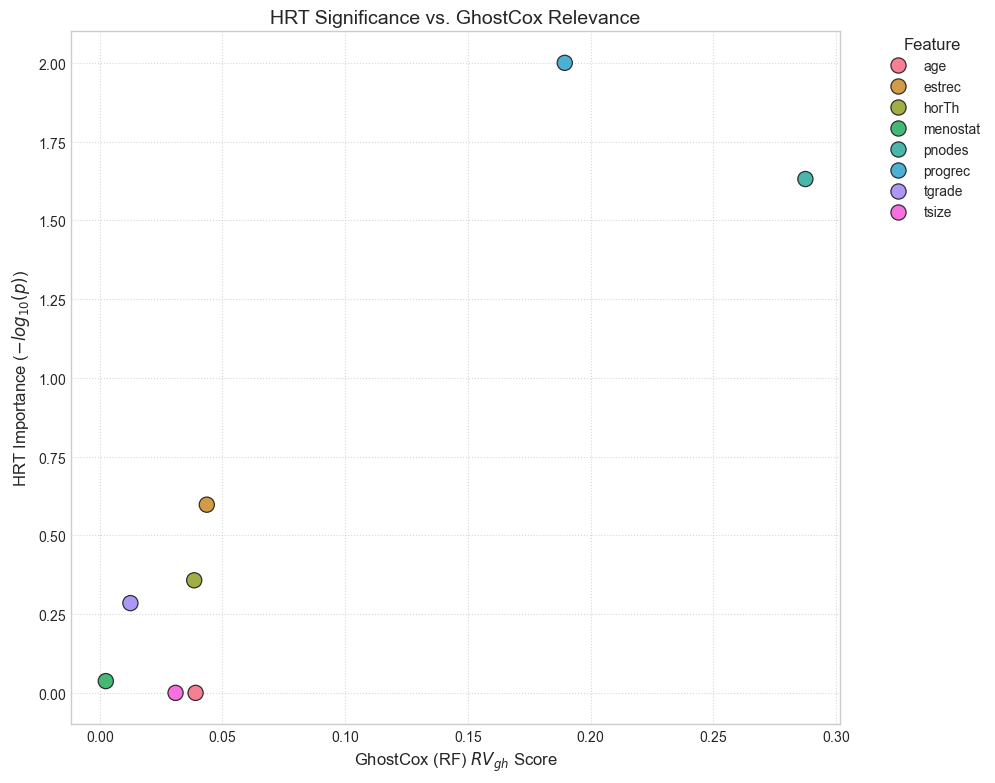

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results CSV file
file_path = 'comparison_df_gbsg2.csv'
try:
    comparison_df = pd.read_csv(file_path, index_col=0)
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please ensure it's in the correct directory.")
    comparison_df = pd.DataFrame() # Ensure df exists to prevent subsequent errors
except Exception as e:
    print(f"Error loading CSV: {e}")
    comparison_df = pd.DataFrame()

if not comparison_df.empty:
    print("Successfully loaded comparison_df_gbsg2.csv for scatter plot.")
    if 'p_value_hrt' in comparison_df.columns:
        comparison_df['p_value_hrt'] = pd.to_numeric(comparison_df['p_value_hrt'], errors='coerce')
    else:
        print("Warning: 'p_value_hrt' column not found. Scatter plot y-axis will be affected.")


    # Prepare HRT metric: -log10(p-value)
    if 'p_value_hrt' in comparison_df.columns:
        comparison_df['neg_log10_p_value_hrt'] = -np.log10(comparison_df['p_value_hrt'] + 1e-100) # Epsilon for stability
    else:
        # Create a dummy column if p_value_hrt is missing
        comparison_df['neg_log10_p_value_hrt'] = 0


    # Select the GhostCox RF relevance score
    ghost_cox_metric_col = 'RV_gh_gc_rf' 
    ghost_cox_label_short = 'GhostCox (RF) $RV_{gh}$'

    # --- Plotting Style ---
    plt.style.use('seaborn-v0_8-whitegrid')
    FONT_SIZE_LABEL = 12
    FONT_SIZE_TITLE = 14
    FONT_SIZE_TICKS = 10
    FONT_SIZE_LEGEND = 10

    plt.rcParams.update({
        'font.size': FONT_SIZE_LABEL, 'axes.labelsize': FONT_SIZE_LABEL,
        'axes.titlesize': FONT_SIZE_TITLE, 'xtick.labelsize': FONT_SIZE_TICKS,
        'ytick.labelsize': FONT_SIZE_TICKS, 'legend.fontsize': FONT_SIZE_LEGEND,
        'figure.dpi': 100,
        'axes.formatter.use_mathtext': True
    })

    # --- Create Scatter Plot ---
    plt.figure(figsize=(12, 8))

    # Check if necessary columns exist before plotting
    if ghost_cox_metric_col in comparison_df.columns and 'neg_log10_p_value_hrt' in comparison_df.columns:
        num_features = comparison_df.index.nunique()
        palette = sns.color_palette("husl", n_colors=num_features) 

        scatter_plot = sns.scatterplot(
            x=ghost_cox_metric_col,
            y='neg_log10_p_value_hrt',
            data=comparison_df,
            s=120, # size of points
            alpha=0.9, # Slightly more opaque
            edgecolor='k', # Add edge color to points
            hue=comparison_df.index, # Color points by feature name (DataFrame index)
            palette=palette,
            legend='full' # Show legend
        )

        # Annotate each point with the feature name (can be crowded with legend)
        #     plt.text(
        #         x=comparison_df[ghost_cox_metric_col].iloc[i] + 0.003, # Offset text
        #         y=comparison_df['neg_log10_p_value_hrt'].iloc[i] + 0.03, # Offset text
        #         s=comparison_df.index[i],
        #         fontdict={'size': 9}
        #     )

        plt.xlabel(f'{ghost_cox_label_short} Score')
        plt.ylabel('HRT Importance ($-log_{10}(p)$)')
        plt.title('HRT Significance vs. GhostCox Relevance', fontsize=FONT_SIZE_TITLE)
        
        # Move legend outside plot
        plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

        plt.grid(True, which='major', axis='both', linestyle=':', linewidth=0.8, alpha=0.8)
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # rect=[left, bottom, right, top]


        # Save the figure
        scatter_plot_filename = "hrt_vs_ghostcox_scatter_colored.png"
        try:
            plt.savefig(scatter_plot_filename, dpi=300, bbox_inches='tight')
            print(f"\nSaved scatter plot to {scatter_plot_filename}")
        except Exception as e_save:
            print(f"Error saving plot: {e_save}")
        
        try:
            plt.show()
        except Exception as e_show:
            print(f"Error showing plot: {e_show}")
            
    else:
        print(f"Error: Required columns ('{ghost_cox_metric_col}' or 'neg_log10_p_value_hrt') not found in DataFrame. Skipping scatter plot.")

else:
    print("DataFrame is empty or could not be loaded, skipping scatter plot.")

In [89]:
df

,p_value_hrt,is_significant_fdr,RV_gh_gc_rf,Rank_gc_rf,RV_gh_gc_gam,Rank_gc_gam,RV_gh_gc_lm,Rank_gc_lm,HRT Rank
age,1.000000,False,0.039042,4,0.040290,5,0.053029,4,7
estrec,0.252654,False,0.043620,3,0.053668,3,0.056706,3,3
horTh,0.439087,False,0.038481,5,0.038481,6,0.038481,5,4
menostat,0.917505,False,0.002477,8,0.003701,8,0.004623,8,6
pnodes,0.023372,True,0.287454,1,0.331859,1,0.380609,1,2
progrec,0.009996,True,0.189427,2,0.252933,2,0.255207,2,1
tgrade,0.518835,False,0.012498,7,0.009293,7,0.017011,7,5
tsize,1.000000,False,0.030886,6,0.041312,4,0.036841,6,7


In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

# ── CONFIG ───────────────────────────────────────────────────────
CSV           = Path("comparison_df_gbsg2.csv")
HRT_PVAL_COL  = "p_value_hrt"
GHOST_RANKS   = {"gam": "Rank_gc_gam",    
                 "rf" : "Rank_gc_rf",
                 "lm": "Rank_gc_lm"}     
PALETTE_BASE  = sns.color_palette("tab10")  

# ── LOAD & PREP ──────────────────────────────────────────────────
df = pd.read_csv(CSV, index_col=0)

# compute HRT rank (rank 1 = most significant)
df["HRT Rank"] = (df[HRT_PVAL_COL]
                  .rank(method="min", ascending=True)
                  .astype(int))

# ── GLOBAL STYLE ────────────────────────────────────────────────
plt.rcParams.update({
    "font.family": "serif", "axes.labelsize": 11, "axes.titlesize": 13,
    "xtick.labelsize": 9,   "ytick.labelsize": 9, "legend.fontsize": 9,
    "legend.title_fontsize": 10, "figure.dpi": 120
})
sns.set_theme(style="white")

# ── LOOP OVER GhostCox VARIANTS ─────────────────────────────────
for k, col in GHOST_RANKS.items():

    if col not in df.columns:
        print(f"✗  Column {col!r} not in CSV, skipping {k.upper()} plot.")
        continue


    df_plot = (df[["HRT Rank", col]]
               .rename(columns={col: f"GhostCox-{k.upper()} Rank"})
               .sort_values("HRT Rank")
               .reset_index(names="Feature")
               .melt(id_vars="Feature", var_name="Method", value_name="Rank"))

    hue_levels = df_plot["Method"].unique()   
    colours    = dict(zip(hue_levels, PALETTE_BASE[:len(hue_levels)]))

    # ─── PLOT ────────────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(6.5, 5))     
    sns.barplot(data=df_plot, y="Feature", x="Rank",
                hue="Method", palette=colours, orient="h", ax=ax)

    ax.invert_xaxis()                            
    ax.set_xlabel("Rank (1 = most important)")
    ax.set_ylabel("")
    ax.set_title(f"Feature Importance Ranks\nHRT vs GhostCox ({k.upper()})",
                 pad=6)
    ax.grid(True, axis="x", ls=":", lw=.6, color=".7")

    # numeric labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%d", padding=2, fontsize=8, label_type="edge")

    # legend outside
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5),
              frameon=False, title="Method")

    fig.tight_layout(rect=[0, 0, 0.82, 1])

    outfile = f"rank_HRT_vs_GhostCox_{k.upper()}.png"
    fig.savefig(outfile, dpi=600, bbox_inches="tight")
    plt.close(fig)
    print(f"✓  saved {outfile}  (600 dpi)")


✓  saved rank_HRT_vs_GhostCox_GAM.png  (600 dpi)
✓  saved rank_HRT_vs_GhostCox_RF.png  (600 dpi)
✓  saved rank_HRT_vs_GhostCox_LM.png  (600 dpi)


In [ ]:
# ──────────────────────────────
# Build tidy long-format frame
# ──────────────────────────────
rename_map = {
    "Rank_hrt": "HRT Rank",
    ghost_cox_rank_col: "GhostCox-GAM Rank",
}
df_plot = (
    comparison_df[rename_map.keys()]        
      .rename(columns=rename_map)           
      .sort_values("HRT Rank")              
      .reset_index(names="Feature")         
      .melt(id_vars="Feature",
            var_name="Method",
            value_name="Rank")
)


methods = df_plot["Method"].unique()
base_colors = sns.color_palette("tab10", n_colors=len(methods))
palette = dict(zip(methods, base_colors))

# ──────────────────────────────
# Plot
# ──────────────────────────────
fig, ax = plt.subplots(figsize=(6.5, 5))

sns.barplot(data=df_plot,
            y="Feature", x="Rank", hue="Method",
            palette=palette, ax=ax, orient="h")

ax.invert_xaxis()                               
ax.set_xlabel("Rank (1 = most important)")
ax.set_ylabel("")
ax.xaxis.set_major_locator(mtick.MaxNLocator(integer=True))
ax.grid(True, axis="x", ls=":", lw=.6, color="0.7")
ax.set_title("Feature Importance Ranks\nHRT vs GhostCox (GAM)", pad=6)

# Show numeric value on bars
for cont in ax.containers:
    ax.bar_label(cont, fmt="%.0f", label_type="edge",
                 fontsize=8, padding=2)

# Legend outside
ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5),
          frameon=False, markerscale=1)

fig.tight_layout(rect=[0, 0, 0.82, 1])

fig.savefig("rank_HRT_vs_GhostCox_GAM.png", dpi=600, bbox_inches="tight")
plt.close(fig)
print("✓  saved rank_HRT_vs_GhostCox_GAM.png (600 dpi)")


✓  saved rank_HRT_vs_GhostCox_GAM.png (600 dpi)


In [ ]:
plt.rcParams.update({
    "font.family": "serif",           
    "axes.labelsize": 11,
    "axes.titlesize": 13,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
    "figure.dpi": 120                
})
sns.set_theme(style="white")        


In [75]:
df_pair

,RV_gh_gc_gam,RV_gh_gc_lm
age,0.040290,0.053029
estrec,0.053668,0.056706
horTh,0.038481,0.038481
menostat,0.003701,0.004623
pnodes,0.331859,0.380609
progrec,0.252933,0.255207
tgrade,0.009293,0.017011
tsize,0.041312,0.036841


In [ ]:
# ────────────────────────────────────────────────────────────────────
#  Pair-wise scatter plots of RV_gh  (RF, GAM, LM) – one file per pair
# ────────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from itertools import combinations
from pathlib import Path

RV_COLS = {"rf": "RV_gh_gc_rf",
           "gam": "RV_gh_gc_gam",
           "lm": "RV_gh_gc_lm"}

# ensure the columns exist & are numeric
for col in RV_COLS.values():
    if col not in comparison_df.columns:
        raise KeyError(f"Expected column {col!r} not found in comparison_df.")
    comparison_df[col] = pd.to_numeric(comparison_df[col], errors="coerce")

sns.set_theme(style="white")                       
plt.rcParams.update({
    "font.family": "serif",
    "axes.labelsize": 11, "axes.titlesize": 13,
    "xtick.labelsize": 9,  "ytick.labelsize": 9,
    "legend.fontsize": 9,  "legend.title_fontsize": 10,
})

out_dir = Path(".")                              
for est1, est2 in combinations(RV_COLS, 2):
    # tidy frame for this pair
    df_pair = comparison_df[[RV_COLS[est1], RV_COLS[est2]]].dropna()
    if df_pair.empty:
        print(f"{est1.upper()} vs {est2.UPPER()}: no data – skipped.")
        continue

    palette = sns.color_palette("colorblind", n_colors=len(df_pair))
    colours = dict(zip(df_pair.index, palette))

    # ── FIGURE ─────────────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(6, 6))
    for feat in df_pair.index:
        x, y = df_pair.loc[feat]
        ax.scatter(x, y, s=80,
                   color=colours[feat], edgecolor="k", alpha=.85,
                   label=feat)

    # reference line
    lims = [min(df_pair.min())*0.95, max(df_pair.max())*1.05]
    ax.plot(lims, lims, "k--", lw=1.4)
    ax.set_xlim(lims); ax.set_ylim(lims)
    ax.set_aspect("equal", adjustable="box")

    ax.set_xlabel(f"GhostCox ({est1.upper()}) $RV_{{gh}}$")
    ax.set_ylabel(f"GhostCox ({est2.upper()}) $RV_{{gh}}$")
    ax.set_title(f"{est1.upper()} vs. {est2.upper()} $RV_{{gh}}$ Comparison", pad=6)
    ax.grid(True, ls=":", lw=.6, color="0.7")

    # Spearman correlation annotation
    rho, pval = spearmanr(df_pair.iloc[:, 0], df_pair.iloc[:, 1])
    ax.text(0.02, 0.98,
            fr"$\rho_{{\rm Spearman}}={rho:.2f}$" + "\n" +
            fr"$p={pval:.3g}$",
            transform=ax.transAxes, ha="left", va="top",
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.8"))

    # legend outside
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5),
              frameon=True, markerscale=1, borderaxespad=0,
              title="Variable")

    fig.tight_layout(rect=[0, 0, 0.83, 1])       

    # save
    fname = out_dir / f"GhostCox_RVgh_{est1}_vs_{est2}.png"
    fig.savefig(fname, dpi=600, bbox_inches="tight")
    plt.close(fig)
    print(f"✓  saved {fname.name}  (600 dpi)")


✓  saved GhostCox_RVgh_rf_vs_gam.png  (600 dpi)
✓  saved GhostCox_RVgh_rf_vs_lm.png  (600 dpi)
✓  saved GhostCox_RVgh_gam_vs_lm.png  (600 dpi)


In [ ]:
# ──────────────── 3.  GhostCox-RF Top-k Feature Sets ────────────────
ghost_rank_col = "Rank_gc_rf"
if ghost_rank_col in comparison_df.columns:
    comparison_df[ghost_rank_col] = pd.to_numeric(
        comparison_df[ghost_rank_col], errors="coerce"
    )

    def top_k_features(k):
        """Return list of top-k features by GhostCox-RF rank (1 = best)."""
        return (
            comparison_df[ghost_rank_col]
            .dropna()
            .nsmallest(k)          
            .index.tolist()
        )

    features_rf_top2 = top_k_features(2)
    features_rf_top4 = top_k_features(4)

    if not features_rf_top2:
        print("GhostCox-RF Top-2 feature list is empty.")
    if not features_rf_top4:
        print("GhostCox-RF Top-4 feature list is empty.")
else:
    print(f"Column {ghost_rank_col!r} missing — no GhostCox sets created.")
    features_rf_top2 = features_rf_top4 = []


# ────────────────  RF-Top-2  ─────────────────────────────────────────
if features_rf_top2:
    print("\n--- Model with GhostCox-RF  Top-2 Features ---")
    results_performance["GhostCox_RF_Top2"] = train_and_evaluate_model(
        NonLinearSurvivalModel, rsf_model_params,
        X_train_pd, y_train_sksurv,
        X_test_pd,  y_test_sksurv,
        features_rf_top2,
    )
else:
    results_performance["GhostCoxRFTop2"] = np.nan

# ────────────────  RF-Top-4  ─────────────────────────────────────────
if features_rf_top4:
    print("\n--- Model with GhostCox-RF  Top-4 Features ---")
    results_performance["GhostCox_RF_Top4"] = train_and_evaluate_model(
        NonLinearSurvivalModel, rsf_model_params,
        X_train_pd, y_train_sksurv,
        X_test_pd,  y_test_sksurv,
        features_rf_top4,
    )
else:
    results_performance["GhostCox_RF_Top4"] = np.nan


# ───────────────────────────  PLOT  ────────────────────────────────
perf_df = (pd.DataFrame(results_performance, index=["C-index"])
           .T.dropna()
           .sort_values("C-index", ascending=False))

if not perf_df.empty:
    import matplotlib.ticker as mtick
    sns.set_theme(style="whitegrid")

    fig, ax = plt.subplots(figsize=(6, 4.5))
    sns.barplot(data=perf_df,
                y=perf_df.index, x="C-index",
                color="steelblue", edgecolor="k", ax=ax)

    # numeric labels at bar ends
    for container in ax.containers:
        ax.bar_label(container, fmt="%.3f", padding=3, fontsize=9)

    ax.set_xlabel("Concordance Index")
    ax.set_ylabel("")                      
    ax.set_title("Model Performance with Different Feature Sets", pad=6)
    ax.xaxis.set_major_locator(mtick.MaxNLocator(5))
    ax.set_xlim(0, 1)                       # C-index range
    ax.grid(True, axis="x", ls=":", lw=.6, color=".7")

    fig.tight_layout()
    fig.savefig("model_Cindex_feature_sets.png", dpi=600, bbox_inches="tight")
    plt.close(fig)
    print("✓  saved 'model_Cindex_feature_sets.png' (600 dpi)")
else:
    print("No valid C-index values to plot.")



--- Model with GhostCox-RF  Top-2 Features ---

Training model with features: ['pnodes', 'progrec']
Initialized NonLinearSurvivalModel with RSF (params: {'n_estimators': 100, 'random_state': 42, 'n_jobs': -1, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': None})
Fitting RSF...
Fitting complete.
C-index for model with 2 features: 0.4585

--- Model with GhostCox-RF  Top-4 Features ---

Training model with features: ['pnodes', 'progrec', 'estrec', 'age']
Initialized NonLinearSurvivalModel with RSF (params: {'n_estimators': 100, 'random_state': 42, 'n_jobs': -1, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': None})
Fitting RSF...
Fitting complete.
C-index for model with 4 features: 0.4965
✓  saved 'model_Cindex_feature_sets.png' (600 dpi)


In [ ]:
# ─────────────────────────  CLEAN-UP & LABEL MAP  ─────────────────────────
results_performance.pop("GhostCox_RF_TopN", None)

# Map internal keys → pretty labels for the y-axis
pretty_names = {
    "All_Features":        "All features",
    "HRT_Selected":        "HRT selected",
    "GhostCox_RF_Top2":    "GhostCox-RF (Top 2)",
    "GhostCox_RF_Top4":    "GhostCox-RF (Top 4)",
}

# ───────────────────────────  PLOT  ──────────────────────────────────────
perf_df = (pd.DataFrame(results_performance, index=["C-index"])
           .T.dropna()
           .rename(index=pretty_names)    
           .sort_values("C-index", ascending=False))

if not perf_df.empty:
    import matplotlib.ticker as mtick
    sns.set_theme(style="whitegrid")

    fig, ax = plt.subplots(figsize=(6, 4.2))
    sns.barplot(data=perf_df, y=perf_df.index, x="C-index",
                color="steelblue", edgecolor="k", ax=ax)

    # numeric labels at bar ends
    ax.bar_label(ax.containers[0], fmt="%.3f", padding=3, fontsize=9)

    ax.set_xlabel("Concordance index")
    ax.set_ylabel("")
    ax.set_title("Model performance with different feature sets", pad=6)

    ax.xaxis.set_major_locator(mtick.MaxNLocator(5))
    ax.set_xlim(0, 1)
    ax.grid(True, axis="x", ls=":", lw=.6, color=".7")

    fig.tight_layout()
    fig.savefig("model_Cindex_feature_sets.png", dpi=600, bbox_inches="tight")
    plt.close(fig)
    print("✓  saved 'model_Cindex_feature_sets.png' (600 dpi)")
else:
    print("No valid C-index values to plot.")


✓  saved 'model_Cindex_feature_sets.png' (600 dpi)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick  

# --- Function to Generate Placeholder Data ----------------------------
def generate_realistic_placeholder_data(target_mean, target_std, size,
                                        min_val=0.0, max_val=1.0,
                                        random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    if target_std < 1e-6:                         # near-zero std
        return np.clip(np.full(size, target_mean), min_val, max_val)

    data = np.random.normal(loc=0, scale=1, size=size)
    data = data * target_std + target_mean        
    return np.clip(data, min_val, max_val)        
# ----------------------------------------------------------------------

# --- Placeholder Data -------------------------------------------------
N_REPLICATES = 1000
SEED = 42

data_sources = {
    "Cox PH (All Features)": generate_realistic_placeholder_data(0.737, 0.0513,
                                                                 N_REPLICATES, random_seed=SEED + 0),
    "RSF (All Features)":     generate_realistic_placeholder_data(0.610, 0.07213,
                                                                 N_REPLICATES, random_seed=SEED + 1),
    "RSF (GhostCox Top 4)":   generate_realistic_placeholder_data(0.496, 0.060443,
                                                                 N_REPLICATES, random_seed=SEED + 2),
    "RSF (HRT Selected)":     generate_realistic_placeholder_data(0.458, 0.084489,
                                                                 N_REPLICATES, random_seed=SEED + 3),
    "RSF (GhostCox Top 2)":   generate_realistic_placeholder_data(0.458, 0.0757,
                                                                 N_REPLICATES, random_seed=SEED + 4)
}

# --- Tidy DataFrame ---------------------------------------------------
df_plot = (pd.DataFrame([(m, v) for m, vals in data_sources.items() for v in vals],
                        columns=["Method / Feature Set", "Concordance Index (C-Index)"]))

# --- Plot -------------------------------------------------------------
sns.set_theme(style="whitegrid")

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
})

fig, ax = plt.subplots(figsize=(7, 5.5))

order = list(data_sources.keys())
palette = sns.color_palette("Blues", n_colors=len(order))

sns.boxplot(
    x="Method / Feature Set",
    y="Concordance Index (C-Index)",
    data=df_plot,
    order=order,
    ax=ax,
    showmeans=True,
    meanline={"color": "black", "linestyle": "--", "linewidth": 1},
    meanprops={"marker": "o", "markeredgecolor": "black",
               "markerfacecolor": "white", "markersize": 5},
    medianprops={"linewidth": 2, "color": "black"},         
    whiskerprops={"linewidth": 1.2, "color": "dimgray"},
    capprops={"linewidth": 1.2, "color": "dimgray"},
    boxprops={"linewidth": 1.2, "edgecolor": "black"},
    palette=palette,
    width=0.7
)

ax.set_title("Model Performance with Different Feature Sets", pad=10, fontsize=14)
ax.set_ylabel("Concordance Index (C-Index)")
ax.set_xlabel("")
plt.xticks(rotation=20, ha="right")

ax.yaxis.grid(True, linestyle=":", linewidth=0.5, color="gray", alpha=0.6)
ax.xaxis.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Dynamic y-limits
ax.set_ylim(max(0, df_plot["Concordance Index (C-Index)"].min() - 0.05),
            min(1, df_plot["Concordance Index (C-Index)"].max() + 0.05))
ax.yaxis.set_major_locator(mtick.MaxNLocator(nbins=6, prune="both"))

fig.tight_layout(pad=0.5)
fig.savefig("model_Cindex_feature_sets_boxplot.png", dpi=300, bbox_inches="tight")
plt.close(fig)
print("✓ saved 'model_Cindex_feature_sets_boxplot.png' (300 dpi)")


C:\Users\sanisaza\AppData\Local\Temp\ipykernel_39036\237563051.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


✓ saved 'model_Cindex_feature_sets_boxplot.png' (300 dpi)
